In [3]:
 
import numpy as np
import cv2
import scipy.io
import os
from numpy.linalg import norm
from matplotlib import pyplot as plt
from numpy.linalg import det
from numpy.linalg import inv
from scipy.linalg import rq
from numpy.linalg import svd
import matplotlib.pyplot as plt
import numpy as np
import math
import random
import sys
from scipy import ndimage, spatial
from tqdm.notebook import tqdm, trange
 
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from skimage import io, transform,data
from torchvision import transforms, utils
import numpy as np
import math
import glob
import matplotlib.pyplot as plt
import time
import os
import copy
import sklearn.svm
import cv2
from matplotlib import pyplot as plt
import numpy as np
from os.path import exists
import pandas as pd
import PIL
import random
from google.colab import drive
from sklearn.metrics.cluster import completeness_score
from sklearn.cluster import KMeans
from tqdm import tqdm, tqdm_notebook
from functools import partial
from torchsummary import summary
from torchvision.datasets import ImageFolder
from torch.utils.data.sampler import SubsetRandomSampler
import h5py as h5
 
#cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
#accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'
 
#print("Accelerator type = ",accelerator)
#print("Pytorch verision: ", torch.__version__)

In [1]:
from google.colab import drive
 
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#!pip install ipython-autotime
 
#%load_ext autotime

In [2]:
!pip install opencv-python==3.4.2.17
!pip install opencv-contrib-python==3.4.2.17

     |████████████████████████████████| 25.0 MB 99 kB/s 
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.1.2.30
    Uninstalling opencv-python-4.1.2.30:
      Successfully uninstalled opencv-python-4.1.2.30
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.
     |████████████████████████████████| 30.6 MB 25 kB/s 
  Attempting uninstall: opencv-contrib-python
    Found existing installation: opencv-contrib-python 4.1.2.30
    Uninstalling opencv-contrib-python-4.1.2.30:
      Successfully uninstalled opencv-contrib-python-4.1.2.30


In [ ]:
#!pip install opencv-python==4.4.0.44
#!pip install opencv-contrib-python==4.4.0.44

In [4]:

class Image:
    def __init__(self, img, position):
        
        self.img = img
        self.position = position

inlier_matchset = []
def features_matching(a,keypointlength,threshold):
  #threshold=0.2
  bestmatch=np.empty((keypointlength),dtype= np.int16)
  img1index=np.empty((keypointlength),dtype=np.int16)
  distance=np.empty((keypointlength))
  index=0
  for j in range(0,keypointlength):
    #For a descriptor fa in Ia, take the two closest descriptors fb1 and fb2 in Ib
    x=a[j]
    listx=x.tolist()
    x.sort()
    minval1=x[0]                                # min 
    minval2=x[1]                                # 2nd min
    itemindex1 = listx.index(minval1)           #index of min val    
    itemindex2 = listx.index(minval2)           #index of second min value 
    ratio=minval1/minval2                       #Ratio Test
    
    if ratio<threshold: 
      #Low distance ratio: fb1 can be a good match
      bestmatch[index]=itemindex1
      distance[index]=minval1
      img1index[index]=j
      index=index+1
  return  [cv2.DMatch(img1index[i],bestmatch[i].astype(int),distance[i]) for i in range(0,index)]
          
   
  
def compute_Homography(im1_pts,im2_pts):
  """
  im1_pts and im2_pts are 2×n matrices with
  4 point correspondences from the two images
  """
  num_matches=len(im1_pts)
  num_rows = 2 * num_matches
  num_cols = 9
  A_matrix_shape = (num_rows,num_cols)
  A = np.zeros(A_matrix_shape)
  a_index = 0
  for i in range(0,num_matches):
    (a_x, a_y) = im1_pts[i]
    (b_x, b_y) = im2_pts[i]
    row1 = [a_x, a_y, 1, 0, 0, 0, -b_x*a_x, -b_x*a_y, -b_x] # First row 
    row2 = [0, 0, 0, a_x, a_y, 1, -b_y*a_x, -b_y*a_y, -b_y] # Second row 

    # place the rows in the matrix
    A[a_index] = row1
    A[a_index+1] = row2

    a_index += 2
    
  U, s, Vt = np.linalg.svd(A)

  #s is a 1-D array of singular values sorted in descending order
  #U, Vt are unitary matrices
  #Rows of Vt are the eigenvectors of A^TA.
  #Columns of U are the eigenvectors of AA^T.
  H = np.eye(3)
  H = Vt[-1].reshape(3,3) # take the last row of the Vt matrix
  return H
  
  
def displayplot(img,title):
  
  plt.figure(figsize=(15,15))
  plt.title(title)
  plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
  plt.show()
  


In [5]:
def get_inliers(f1, f2, matches, H, RANSACthresh):

  inlier_indices = []
  for i in range(len(matches)):
    queryInd = matches[i].queryIdx
    trainInd = matches[i].trainIdx

    #queryInd = matches[i][0]
    #trainInd = matches[i][1]

    queryPoint = np.array([f1[queryInd].pt[0],  f1[queryInd].pt[1], 1]).T 
    trans_query = H.dot(queryPoint) 

   
    comp1 = [trans_query[0]/trans_query[2], trans_query[1]/trans_query[2]] # normalize with respect to z
    comp2 = np.array(f2[trainInd].pt)[:2]
    

    if(np.linalg.norm(comp1-comp2) <= RANSACthresh): # check against threshold
      inlier_indices.append(i)
  return inlier_indices


def RANSAC_alg(f1, f2, matches, nRANSAC, RANSACthresh):

      
    minMatches = 4
    nBest = 0
    best_inliers = []
    H_estimate = np.eye(3,3)
    global inlier_matchset
    inlier_matchset=[]
    for iteration in range(nRANSAC):
      
        #Choose a minimal set of feature matches.
        matchSample = random.sample(matches, minMatches)
        
        #Estimate the Homography implied by these matches
        im1_pts=np.empty((minMatches,2))
        im2_pts=np.empty((minMatches,2))
        for i in range(0,minMatches):
          m = matchSample[i]
          im1_pts[i] = f1[m.queryIdx].pt
          im2_pts[i] = f2[m.trainIdx].pt
          #im1_pts[i] = f1[m[0]].pt
          #im2_pts[i] = f2[m[1]].pt             
          
        H_estimate=compute_Homography(im1_pts,im2_pts)
        
               
        # Calculate the inliers for the H
        inliers = get_inliers(f1, f2, matches, H_estimate, RANSACthresh)

        # if the number of inliers is higher than previous iterations, update the best estimates
        if len(inliers) > nBest:
            nBest= len(inliers)
            best_inliers = inliers

    print("Number of best inliers",len(best_inliers))
    for i in range(len(best_inliers)):
      inlier_matchset.append(matches[best_inliers[i]])
    
    # compute a homography given this set of matches
    im1_pts=np.empty((len(best_inliers),2))
    im2_pts=np.empty((len(best_inliers),2))
    for i in range(0,len(best_inliers)):
      m = inlier_matchset[i]
      im1_pts[i] = f1[m.queryIdx].pt
      im2_pts[i] = f2[m.trainIdx].pt
      #im1_pts[i] = f1[m[0]].pt
      #im2_pts[i] = f2[m[1]].pt

    M=compute_Homography(im1_pts,im2_pts)
    return M, best_inliers




In [6]:






tqdm = partial(tqdm, position=0, leave=True)


In [7]:



from zipfile import  ZipFile
file_name = '/content/drive/MyDrive/rgb-images.zip'

with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print('Done')

Done


In [8]:

files_all=[]
for file in os.listdir("/content/RGB Images"):
    if file.endswith(".JPG"):
      files_all.append(file)


files_all.sort()
folder_path = '/content/RGB Images/'

#centre_file = folder_path + files_all[50]
left_files_path_rev = []
right_files_path = []


#Change this according to your dataset split

for file in files_all[:int(len(files_all)/2)+1]:
  left_files_path_rev.append(folder_path + file)

left_files_path = left_files_path_rev[::-1]

for file in files_all[int(len(files_all)/2):]:
  right_files_path.append(folder_path + file)


In [9]:

print(len(files_all))

113


In [10]:
from multiprocessing import Pool

In [11]:
#pool = Pool(4)

#images_left_bgr = pool.map(get_images, left_files_path)

In [12]:

import multiprocessing
print(multiprocessing.cpu_count())

4


In [13]:
gridsize = 8
clahe = cv2.createCLAHE(clipLimit=2.0,tileGridSize=(gridsize,gridsize))

images_left_bgr = []
images_right_bgr = []

images_left = []
images_right = []

for file in tqdm(left_files_path):
  left_image_sat= cv2.imread(file)
  lab = cv2.cvtColor(left_image_sat, cv2.COLOR_BGR2LAB)
  lab[...,0] = clahe.apply(lab[...,0])
  left_image_sat = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
  left_img = cv2.resize(left_image_sat,None,fx=0.75, fy=0.75, interpolation = cv2.INTER_CUBIC )
  #images_left.append(cv2.cvtColor(left_img, cv2.COLOR_BGR2GRAY).astype('float32')/255.)
  images_left_bgr.append(left_img)


for file in tqdm(right_files_path):
  right_image_sat= cv2.imread(file)
  lab = cv2.cvtColor(right_image_sat, cv2.COLOR_BGR2LAB)
  lab[...,0] = clahe.apply(lab[...,0])
  right_image_sat = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
  right_img = cv2.resize(right_image_sat,None,fx=0.75,fy=0.75, interpolation = cv2.INTER_CUBIC )
  #images_right.append(cv2.cvtColor(right_img, cv2.COLOR_BGR2GRAY).astype('float32')/255.)
  images_right_bgr.append(right_img)



100%|██████████| 57/57 [00:35<00:00,  1.59it/s]


In [14]:
Dataset = 'Industrial_Estate'

In [15]:
f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','w')
t0=time.time()
f.create_dataset('data',data=images_left_bgr + images_right_bgr)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize(f'drive/MyDrive/all_images_bgr_{Dataset}.h5')/1.e6,'MB')

HDF5  w/o comp.: 86.25358748435974 [s] ... size 3840.164096 MB


In [16]:
f=h5.File(f'drive/MyDrive/all_images_gray_{Dataset}.h5','w')
t0=time.time()
f.create_dataset('data',data=images_left + images_right)
f.close()                                                                             
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize(f'drive/MyDrive/all_images_gray_{Dataset}.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.008817195892333984 [s] ... size 0.0014 MB


In [17]:


#images_left_bgr_no_enhance = []
#images_right_bgr_no_enhance = []

#for file in tqdm(left_files_path):
#  left_image_sat= cv2.imread(file)
#  left_img = cv2.resize(left_image_sat,None,fx=0.35, fy=0.35, interpolation = cv2.INTER_CUBIC)
#  images_left_bgr_no_enhance.append(left_img)

#for file in tqdm(right_files_path):
#  right_image_sat= cv2.imread(file)
#  right_img = cv2.resize(right_image_sat,None,fx=0.35,fy=0.35, interpolation = cv2.INTER_CUBIC)
#  images_right_bgr_no_enhance.append(right_img)


In [18]:



from timeit import default_timer as timer


In [19]:
time_all = []

In [20]:

num_kps_sift = []
num_kps_brisk = []
num_kps_agast = []
num_kps_kaze = []
num_kps_akaze = []
num_kps_orb = []
num_kps_mser = []
num_kps_daisy = []
num_kps_surfsift = []
num_kps_fast = []
num_kps_freak = []
num_kps_gftt = []
num_kps_briefstar = []
num_kps_surf = []
num_kps_rootsift = []
num_kps_superpoint = []

###**BRISK**

In [ ]:
Threshl=60;
Octaves=6; 
#PatternScales=1.0f;

start = timer()

brisk = cv2.BRISK_create(Threshl,Octaves)


keypoints_all_left_brisk = []
descriptors_all_left_brisk = []
points_all_left_brisk=[]

keypoints_all_right_brisk = []
descriptors_all_right_brisk = []
points_all_right_brisk=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()  
  kpt = brisk.detect(imgs,None)
  kpt,descrip =  brisk.compute(imgs, kpt)
  keypoints_all_left_brisk.append(kpt)
  descriptors_all_left_brisk.append(descrip)
  #points_all_left_brisk.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = brisk.detect(imgs,None)
  kpt,descrip =  brisk.compute(imgs, kpt)
  keypoints_all_right_brisk.append(kpt)
  descriptors_all_right_brisk.append(descrip)
  #points_all_right_brisk.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 57/57 [02:25<00:00,  2.55s/it]


In [ ]:


for j in tqdm(keypoints_all_left_brisk + keypoints_all_right_brisk[1:]):
  num_kps_brisk.append(len(j))



100%|██████████| 113/113 [00:00<00:00, 320457.30it/s]


In [ ]:
all_feat_brisk_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_brisk):
  all_feat_brisk_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_brisk[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_brisk_left_each.append(temp)
  all_feat_brisk_left.append(all_feat_brisk_left_each)
      

In [ ]:


all_feat_brisk_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_brisk):
  all_feat_brisk_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_brisk[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_brisk_right_each.append(temp)
  all_feat_brisk_right.append(all_feat_brisk_right_each)      

In [ ]:
del keypoints_all_left_brisk, keypoints_all_right_brisk, descriptors_all_left_brisk, descriptors_all_right_brisk

In [ ]:

import pickle
Fdb = open('all_feat_brisk_left.dat', 'wb')
pickle.dump(all_feat_brisk_left,Fdb,-1)
Fdb.close()

In [ ]:


import pickle
Fdb = open('all_feat_brisk_right.dat', 'wb')
pickle.dump(all_feat_brisk_right,Fdb,-1)
Fdb.close()

In [ ]:
del Fdb, all_feat_brisk_left, all_feat_brisk_right


###**ORB**

In [ ]:

orb = cv2.ORB_create(20000)

start = timer()


keypoints_all_left_orb = []
descriptors_all_left_orb = []
points_all_left_orb=[]

keypoints_all_right_orb = []
descriptors_all_right_orb = []
points_all_right_orb=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()    
  kpt = orb.detect(imgs,None)
  kpt,descrip =  orb.compute(imgs, kpt)
  keypoints_all_left_orb.append(kpt)
  descriptors_all_left_orb.append(descrip)
  #points_all_left_orb.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = orb.detect(imgs,None)
  kpt,descrip =  orb.compute(imgs, kpt)
  keypoints_all_right_orb.append(kpt)
  descriptors_all_right_orb.append(descrip)
  #points_all_right_orb.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

In [ ]:


for j in tqdm(keypoints_all_left_orb + keypoints_all_right_orb[1:]):
  num_kps_orb.append(len(j))



In [ ]:
all_feat_orb_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_orb):
  all_feat_orb_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_orb[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_orb_left_each.append(temp)
  all_feat_orb_left.append(all_feat_orb_left_each)
      

In [ ]:
all_feat_orb_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_orb):
  all_feat_orb_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_orb[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_orb_right_each.append(temp)
  all_feat_orb_right.append(all_feat_orb_right_each)      

In [ ]:

del keypoints_all_left_orb, keypoints_all_right_orb, descriptors_all_left_orb, descriptors_all_right_orb

In [ ]:
import pickle
Fdb = open('all_feat_orb_left.dat', 'wb')
pickle.dump(all_feat_orb_left,Fdb,-1)
Fdb.close()

In [ ]:
import pickle
Fdb = open('all_feat_orb_right.dat', 'wb')
pickle.dump(all_feat_orb_right,Fdb,-1)
Fdb.close()

In [ ]:
del Fdb, all_feat_orb_left, all_feat_orb_right



###**KAZE**

In [ ]:
start = timer()

kaze = cv2.KAZE_create()


keypoints_all_left_kaze = []
descriptors_all_left_kaze = []
points_all_left_kaze=[]

keypoints_all_right_kaze = []
descriptors_all_right_kaze = []
points_all_right_kaze=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = kaze.detect(imgs,None)
  kpt,descrip =  kaze.compute(imgs, kpt)
  keypoints_all_left_kaze.append(kpt)
  descriptors_all_left_kaze.append(descrip)
  #points_all_left_kaze.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = kaze.detect(imgs,None)
  kpt,descrip =  kaze.compute(imgs, kpt)
  keypoints_all_right_kaze.append(kpt)
  descriptors_all_right_kaze.append(descrip)
  #points_all_right_kaze.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 57/57 [22:23<00:00, 23.56s/it]


In [ ]:

for j in tqdm(keypoints_all_left_kaze + keypoints_all_right_kaze[1:]):
  num_kps_kaze.append(len(j))
  

100%|██████████| 113/113 [00:00<00:00, 68352.52it/s]


In [ ]:
all_feat_kaze_left = []                                          
for cnt,kpt_all in enumerate(keypoints_all_left_kaze):
  all_feat_kaze_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_kaze[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_kaze_left_each.append(temp)
  all_feat_kaze_left.append(all_feat_kaze_left_each)
      

In [ ]:
all_feat_kaze_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_kaze):
  all_feat_kaze_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_kaze[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_kaze_right_each.append(temp)
  all_feat_kaze_right.append(all_feat_kaze_right_each)      

In [ ]:
del keypoints_all_left_kaze, keypoints_all_right_kaze, descriptors_all_left_kaze, descriptors_all_right_kaze

In [ ]:
import pickle
Fdb = open('all_feat_kaze_left.dat', 'wb')
pickle.dump(all_feat_kaze_left,Fdb,-1)
Fdb.close()

In [ ]:
import pickle
Fdb = open('all_feat_kaze_right.dat', 'wb')
pickle.dump(all_feat_kaze_right,Fdb,-1)
Fdb.close()

In [ ]:

del Fdb, all_feat_kaze_left, all_feat_kaze_right

###**AKAZE**

In [ ]:
from functools import partial
from tqdm import tqdm
tqdm = partial(tqdm, position=0, leave=True)

In [ ]:
start = timer()

akaze = cv2.AKAZE_create()


keypoints_all_left_akaze = []
descriptors_all_left_akaze = []
points_all_left_akaze=[]

keypoints_all_right_akaze = []
descriptors_all_right_akaze = []
points_all_right_akaze=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = akaze.detect(imgs,None)
  kpt,descrip =  akaze.compute(imgs, kpt)
  keypoints_all_left_akaze.append(kpt)
  descriptors_all_left_akaze.append(descrip)
  #points_all_left_akaze.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = akaze.detect(imgs,None)
  kpt,descrip = akaze.compute(imgs, kpt)
  keypoints_all_right_akaze.append(kpt)
  descriptors_all_right_akaze.append(descrip)
  #points_all_right_akaze.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 57/57 [03:39<00:00,  3.85s/it]


In [ ]:

for j in tqdm(keypoints_all_left_akaze + keypoints_all_right_akaze[1:]):
  num_kps_akaze.append(len(j))                           


100%|██████████| 113/113 [00:00<00:00, 88063.24it/s]


In [ ]:
all_feat_akaze_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_akaze):
  all_feat_akaze_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_akaze[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_akaze_left_each.append(temp)
  all_feat_akaze_left.append(all_feat_akaze_left_each)
      

In [ ]:
all_feat_akaze_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_akaze):
  all_feat_akaze_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_akaze[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_akaze_right_each.append(temp)
  all_feat_akaze_right.append(all_feat_akaze_right_each)      

In [ ]:
del keypoints_all_left_akaze, keypoints_all_right_akaze, descriptors_all_left_akaze, descriptors_all_right_akaze

In [ ]:

import pickle
Fdb = open('all_feat_akaze_left.dat', 'wb')
pickle.dump(all_feat_akaze_left,Fdb,-1)
Fdb.close()

In [ ]:
import pickle
Fdb = open('all_feat_akaze_right.dat', 'wb')
pickle.dump(all_feat_akaze_right,Fdb,-1)
Fdb.close()

In [ ]:
del Fdb, all_feat_akaze_left, all_feat_akaze_right

###**STAR + BRIEF**

In [ ]:
start = timer()

star = cv2.xfeatures2d.StarDetector_create()
brief = cv2.xfeatures2d.BriefDescriptorExtractor_create()

keypoints_all_left_star = []
descriptors_all_left_brief = []
points_all_left_star=[]

keypoints_all_right_star = []
descriptors_all_right_brief = []
points_all_right_star=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = star.detect(imgs,None)
  kpt,descrip =  brief.compute(imgs, kpt)
  keypoints_all_left_star.append(kpt)
  descriptors_all_left_brief.append(descrip)
  #points_all_left_star.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = star.detect(imgs,None)
  kpt,descrip =  brief.compute(imgs, kpt)
  keypoints_all_right_star.append(kpt)
  descriptors_all_right_brief.append(descrip)
  #points_all_right_star.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 57/57 [02:31<00:00,  2.66s/it]


In [ ]:

for j in tqdm(keypoints_all_left_star + keypoints_all_right_star[1:]):
  num_kps_briefstar.append(len(j))

100%|██████████| 113/113 [00:00<00:00, 405090.90it/s]


In [ ]:
all_feat_star_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_star):
  all_feat_star_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_brief[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_star_left_each.append(temp)
  all_feat_star_left.append(all_feat_star_left_each)
      

In [ ]:
all_feat_star_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_star):
  all_feat_star_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_brief[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_star_right_each.append(temp)
  all_feat_star_right.append(all_feat_star_right_each)      

In [ ]:
del keypoints_all_left_star, keypoints_all_right_star, descriptors_all_left_brief, descriptors_all_right_brief

In [ ]:
import pickle
Fdb = open('all_feat_star_left.dat', 'wb')
pickle.dump(all_feat_star_left,Fdb,-1)
Fdb.close()

In [ ]:
import pickle
Fdb = open('all_feat_star_right.dat', 'wb')
pickle.dump(all_feat_star_right,Fdb,-1)
Fdb.close()

In [ ]:
del Fdb, all_feat_star_left, all_feat_star_right

###**BRISK + FREAK**

In [21]:
start = timer()
 
Threshl=100;
Octaves=6; 
#PatternScales=1.0f;
brisk = cv2.BRISK_create(Threshl,Octaves)
 
freak = cv2.xfeatures2d.FREAK_create()
keypoints_all_left_freak = []
descriptors_all_left_freak = [] 
points_all_left_freak=[]
 
keypoints_all_right_freak = []
descriptors_all_right_freak = []
points_all_right_freak=[]
 
 
for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = brisk.detect(imgs)
  kpt,descrip =  freak.compute(imgs, kpt)
  keypoints_all_left_freak.append(kpt)
  descriptors_all_left_freak.append(descrip)
  #points_all_left_freak.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))
 
for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = brisk.detect(imgs,None)
  kpt,descrip =  freak.compute(imgs, kpt)
  keypoints_all_right_freak.append(kpt)
  descriptors_all_right_freak.append(descrip)
  #points_all_right_freak.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))
 
end = timer()
 
time_all.append(end-start)

100%|██████████| 57/57 [00:42<00:00,  1.33it/s]


In [22]:
for j in tqdm(keypoints_all_left_freak + keypoints_all_right_freak[1:]):
  num_kps_freak.append(len(j))

100%|██████████| 113/113 [00:00<00:00, 379772.72it/s]


In [23]:
all_feat_freak_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_freak):
  all_feat_freak_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_freak[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_freak_left_each.append(temp)
  all_feat_freak_left.append(all_feat_freak_left_each)

In [24]:
 
all_feat_freak_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_freak):
  all_feat_freak_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_freak[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_freak_right_each.append(temp)
  all_feat_freak_right.append(all_feat_freak_right_each)

In [25]:
del keypoints_all_left_freak, keypoints_all_right_freak, descriptors_all_left_freak, descriptors_all_right_freak

In [26]:
import pickle
Fdb = open('all_feat_freak_left.dat', 'wb')
pickle.dump(all_feat_freak_left,Fdb,-1)
Fdb.close()

In [27]:
import pickle
Fdb = open('all_feat_freak_right.dat', 'wb')
pickle.dump(all_feat_freak_right,Fdb,-1)
Fdb.close()

In [28]:
del Fdb, all_feat_freak_left, all_feat_freak_right

###**MSER + SIFT**

In [ ]:
start = timer()

mser = cv2.MSER_create(_delta = 76)
sift = cv2.xfeatures2d.SIFT_create()

keypoints_all_left_mser = []
descriptors_all_left_mser = []
points_all_left_mser=[]

keypoints_all_right_mser = []
descriptors_all_right_mser = []
points_all_right_mser=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = mser.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_left_mser.append(kpt)
  descriptors_all_left_mser.append(descrip)
  #points_all_left_mser.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = mser.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_right_mser.append(kpt)
  descriptors_all_right_mser.append(descrip)
  #points_all_right_mser.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 57/57 [13:53<00:00, 14.62s/it]


In [ ]:

for j in tqdm(keypoints_all_left_mser + keypoints_all_right_mser[1:]):
  num_kps_mser.append(len(j))


100%|██████████| 113/113 [00:00<00:00, 483135.93it/s]


In [ ]:
all_feat_mser_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_mser):
  all_feat_mser_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_mser[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_mser_left_each.append(temp)
  all_feat_mser_left.append(all_feat_mser_left_each)
      

In [ ]:
all_feat_mser_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_mser):
  all_feat_mser_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_mser[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_mser_right_each.append(temp)
  all_feat_mser_right.append(all_feat_mser_right_each)      

In [ ]:
del keypoints_all_left_mser, keypoints_all_right_mser, descriptors_all_left_mser, descriptors_all_right_mser

In [ ]:
import pickle
Fdb = open('all_feat_mser_left.dat', 'wb')
pickle.dump(all_feat_mser_left,Fdb,-1)
Fdb.close()

In [ ]:
import pickle
Fdb = open('all_feat_mser_right.dat', 'wb')
pickle.dump(all_feat_mser_right,Fdb,-1)
Fdb.close()

In [ ]:
del Fdb, all_feat_mser_left, all_feat_mser_right

###**AGAST + SIFT**

In [29]:
start = timer()

agast = cv2.AgastFeatureDetector_create(threshold = 80)
sift = cv2.xfeatures2d.SIFT_create(nfeatures=3500, contrastThreshold =0.99, edgeThreshold=4)

keypoints_all_left_agast = []
descriptors_all_left_agast = []
points_all_left_agast=[]

keypoints_all_right_agast = []
descriptors_all_right_agast = []
points_all_right_agast=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = agast.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_left_agast.append(kpt)
  descriptors_all_left_agast.append(descrip)
  #points_all_left_agast.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = agast.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_right_agast.append(kpt)
  descriptors_all_right_agast.append(descrip)
  #points_all_right_agast.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 57/57 [01:45<00:00,  1.86s/it]


In [30]:

for j in tqdm(keypoints_all_left_agast + keypoints_all_right_agast[1:]):
  num_kps_agast.append(len(j))                                                                         

100%|██████████| 113/113 [00:00<00:00, 112099.42it/s]


In [31]:
all_feat_agast_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_agast):
  all_feat_agast_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_agast[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_agast_left_each.append(temp)
  all_feat_agast_left.append(all_feat_agast_left_each)
      

In [32]:
all_feat_agast_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_agast):
  all_feat_agast_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_agast[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_agast_right_each.append(temp)
  all_feat_agast_right.append(all_feat_agast_right_each)      

In [33]:

del keypoints_all_left_agast, keypoints_all_right_agast, descriptors_all_left_agast, descriptors_all_right_agast

In [34]:
import pickle
Fdb = open('all_feat_agast_left.dat', 'wb')
pickle.dump(all_feat_agast_left,Fdb,-1)
Fdb.close()

In [35]:
del Fdb, all_feat_agast_left

In [36]:

import pickle
Fdb = open('all_feat_agast_right.dat', 'wb')
pickle.dump(all_feat_agast_right,Fdb,-1)
Fdb.close()

In [37]:
del Fdb, all_feat_agast_right

###**FAST + SIFT**

In [38]:
start = timer()
 
 
fast = cv2.FastFeatureDetector_create(threshold = 80, nonmaxSuppression= True)
sift = cv2.xfeatures2d.SIFT_create(nfeatures=3000, contrastThreshold =0.08, edgeThreshold=7)
 
keypoints_all_left_fast = []
descriptors_all_left_fast = []
points_all_left_fast=[]
 
keypoints_all_right_fast = []
descriptors_all_right_fast = []
points_all_right_fast=[]
 
for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = fast.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_left_fast.append(kpt)
  descriptors_all_left_fast.append(descrip)
  points_all_left_fast.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))
 
for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = fast.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_right_fast.append(kpt)
  descriptors_all_right_fast.append(descrip)
  points_all_right_fast.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))
 
end = timer()
 
time_all.append(end-start)

100%|██████████| 57/57 [01:39<00:00,  1.74s/it]


In [39]:
 
for j in tqdm(keypoints_all_left_fast + keypoints_all_right_fast[1:]):
  num_kps_fast.append(len(j))

100%|██████████| 113/113 [00:00<00:00, 378861.99it/s]


In [40]:
all_feat_fast_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_fast):
  all_feat_fast_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_fast[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_fast_left_each.append(temp)
  all_feat_fast_left.append(all_feat_fast_left_each)

In [41]:
all_feat_fast_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_fast):
  all_feat_fast_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_fast[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_fast_right_each.append(temp)
  all_feat_fast_right.append(all_feat_fast_right_each)

In [42]:
del keypoints_all_left_fast, keypoints_all_right_fast, descriptors_all_left_fast, descriptors_all_right_fast

In [43]:
import pickle
Fdb = open('all_feat_fast_left.dat', 'wb')
pickle.dump(all_feat_fast_left,Fdb,-1)
Fdb.close()

In [44]:
import pickle
Fdb = open('all_feat_fast_right.dat', 'wb')
pickle.dump(all_feat_fast_right,Fdb,-1)
Fdb.close()

In [45]:
del Fdb, all_feat_fast_left, all_feat_fast_right

###**GFTT + SIFT**

In [ ]:
start = timer()

gftt = cv2.GFTTDetector_create()
sift = cv2.xfeatures2d.SIFT_create(nfeatures=2000, contrastThreshold =0.02, edgeThreshold=4)

keypoints_all_left_gftt = []
descriptors_all_left_gftt = []
points_all_left_gftt=[]

keypoints_all_right_gftt = []
descriptors_all_right_gftt = []
points_all_right_gftt=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = gftt.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_left_gftt.append(kpt)
  descriptors_all_left_gftt.append(descrip)
  #points_all_left_gftt.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = gftt.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_right_gftt.append(kpt)
  descriptors_all_right_gftt.append(descrip)
  #points_all_right_gftt.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 57/57 [00:58<00:00,  1.03s/it]


In [ ]:


for j in tqdm(keypoints_all_left_gftt + keypoints_all_right_gftt[1:]):
  num_kps_gftt.append(len(j))



100%|██████████| 113/113 [00:00<00:00, 358786.03it/s]


In [ ]:
all_feat_gftt_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_gftt):
  all_feat_gftt_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_gftt[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_gftt_left_each.append(temp)
  all_feat_gftt_left.append(all_feat_gftt_left_each)
      

In [ ]:
all_feat_gftt_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_gftt):
  all_feat_gftt_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_gftt[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_gftt_right_each.append(temp)
  all_feat_gftt_right.append(all_feat_gftt_right_each)      

In [ ]:
del keypoints_all_left_gftt, keypoints_all_right_gftt, descriptors_all_left_gftt, descriptors_all_right_gftt

In [ ]:
import pickle
Fdb = open('all_feat_gftt_left.dat', 'wb')
pickle.dump(all_feat_gftt_left,Fdb,-1)
Fdb.close()

In [ ]:
import pickle
Fdb = open('all_feat_gftt_right.dat', 'wb')
pickle.dump(all_feat_gftt_right,Fdb,-1)
Fdb.close()

In [ ]:
del Fdb, all_feat_gftt_left, all_feat_gftt_right

###**DAISY + SIFT**

In [ ]:
start = timer()

daisy = cv2.xfeatures2d.DAISY_create()
sift = cv2.xfeatures2d.SIFT_create(nfeatures=2000, contrastThreshold =0.02, edgeThreshold=4)

keypoints_all_left_daisy = []
descriptors_all_left_daisy = []
points_all_left_daisy=[]

keypoints_all_right_daisy = []
descriptors_all_right_daisy = []
points_all_right_daisy=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = sift.detect(imgs,None)
  kpt,descrip =  daisy.compute(imgs, kpt)
  keypoints_all_left_daisy.append(kpt)
  descriptors_all_left_daisy.append(descrip)
  #points_all_left_daisy.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = sift.detect(imgs,None)
  kpt,descrip =  daisy.compute(imgs, kpt)
  keypoints_all_right_daisy.append(kpt)
  descriptors_all_right_daisy.append(descrip)
  #points_all_right_daisy.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()


time_all.append(end-start)

100%|██████████| 57/57 [04:45<00:00,  5.01s/it]


In [ ]:
for j in tqdm(keypoints_all_left_daisy + keypoints_all_right_daisy[1:]):
  num_kps_daisy.append(len(j))   
      

100%|██████████| 113/113 [00:00<00:00, 123910.16it/s]


In [ ]:
all_feat_daisy_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_daisy):
  all_feat_daisy_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_daisy[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_daisy_left_each.append(temp)
  all_feat_daisy_left.append(all_feat_daisy_left_each)
      

In [ ]:
all_feat_daisy_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_daisy):
  all_feat_daisy_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_daisy[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_daisy_right_each.append(temp)
  all_feat_daisy_right.append(all_feat_daisy_right_each)      

In [ ]:
del keypoints_all_left_daisy, keypoints_all_right_daisy, descriptors_all_left_daisy, descriptors_all_right_daisy

In [ ]:
import pickle
Fdb = open('all_feat_daisy_left.dat', 'wb')
pickle.dump(all_feat_daisy_left,Fdb,-1)
Fdb.close()

In [ ]:
import pickle
Fdb = open('all_feat_daisy_right.dat', 'wb')
pickle.dump(all_feat_daisy_right,Fdb,-1)
Fdb.close()

In [ ]:
del Fdb, all_feat_daisy_left, all_feat_daisy_right

###**SURF + SIFT**

In [ ]:

start = timer()

surf = cv2.xfeatures2d.SURF_create(upright=10)
sift = cv2.xfeatures2d.SIFT_create(contrastThreshold = 0.01, edgeThreshold = 30)

keypoints_all_left_surfsift = []
descriptors_all_left_surfsift = []
points_all_left_surfsift=[]

keypoints_all_right_surfsift = []
descriptors_all_right_surfsift = []
points_all_right_surfsift=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = surf.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_left_surfsift.append(kpt)
  descriptors_all_left_surfsift.append(descrip)
  #points_all_left_surfsift.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = surf.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_right_surfsift.append(kpt)
  descriptors_all_right_surfsift.append(descrip)
  #points_all_right_surfsift.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)


100%|██████████| 57/57 [33:45<00:00, 35.53s/it]


In [ ]:
for j in tqdm(keypoints_all_left_surfsift + keypoints_all_right_surfsift[1:]):
  num_kps_surfsift.append(len(j))
  

100%|██████████| 113/113 [00:00<00:00, 573103.21it/s]


In [ ]:

all_feat_surfsift_left = []                                            
for cnt,kpt_all in enumerate(keypoints_all_left_surfsift):
  all_feat_surfsift_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_surfsift[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_surfsift_left_each.append(temp)
  all_feat_surfsift_left.append(all_feat_surfsift_left_each)


In [ ]:

all_feat_surfsift_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_surfsift):
  all_feat_surfsift_right_each = []      
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_surfsift[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_surfsift_right_each.append(temp)
  all_feat_surfsift_right.append(all_feat_surfsift_right_each)      


In [ ]:
del keypoints_all_left_surfsift, keypoints_all_right_surfsift, descriptors_all_left_surfsift, descriptors_all_right_surfsift

In [ ]:

import pickle
Fdb = open('all_feat_surfsift_left.dat', 'wb')
pickle.dump(all_feat_surfsift_left,Fdb,-1)
Fdb.close()


In [ ]:

import pickle
Fdb = open('all_feat_surfsift_right.dat', 'wb')
pickle.dump(all_feat_surfsift_right,Fdb,-1)
Fdb.close()


In [ ]:
#del Fdb, all_feat_surfsift_left, all_feat_surfsift_right

###**SIFT**

In [ ]:
print(len(left_files_path))

In [ ]:
print(len(right_files_path))

In [ ]:
# H5 file w/o compression
#t0=time.time()
#f=h5.File('drive/MyDrive/all_images_bgr_sift.h5','r')
#print('HDF5  w/o comp.: data shape =',len(f['data'][0]),time.time()-t0,'[s]')
#f.close()

In [ ]:
#del f

In [21]:
start = timer()

sift = cv2.xfeatures2d.SIFT_create(nfeatures=2000, contrastThreshold =0.098, edgeThreshold=3)
keypoints_all_left_sift = []
descriptors_all_left_sift = []
points_all_left_sift=[]

keypoints_all_right_sift = []
descriptors_all_right_sift = []
points_all_right_sift=[]


for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()
  kpt = sift.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_left_sift.append(kpt)
  descriptors_all_left_sift.append(descrip)
  points_all_left_sift.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()
  kpt = sift.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_right_sift.append(kpt)
  descriptors_all_right_sift.append(descrip)
  points_all_right_sift.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 57/57 [04:17<00:00,  4.52s/it]


In [22]:
for j in tqdm(keypoints_all_left_sift + keypoints_all_right_sift[1:]):
  num_kps_sift.append(len(j))                          

100%|██████████| 113/113 [00:00<00:00, 409996.84it/s]


In [23]:
all_feat_sift_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_sift):
  all_feat_sift_left_each = []    
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_sift[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_sift_left_each.append(temp)
  all_feat_sift_left.append(all_feat_sift_left_each)
      

In [24]:

all_feat_sift_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_sift):
  all_feat_sift_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_sift[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_sift_right_each.append(temp)
  all_feat_sift_right.append(all_feat_sift_right_each)      

In [25]:
del keypoints_all_left_sift,descriptors_all_left_sift


In [26]:
del keypoints_all_right_sift,descriptors_all_right_sift 

In [27]:
import pickle
Fdb = open('all_feat_sift_left.dat', 'wb')
pickle.dump(all_feat_sift_left,Fdb,-1)
Fdb.close()

In [28]:
import pickle
Fdb = open('all_feat_sift_right.dat', 'wb')
pickle.dump(all_feat_sift_right,Fdb,-1)
Fdb.close()

In [29]:
del Fdb, all_feat_sift_left, all_feat_sift_right

###**SURF**

In [47]:
start = timer()

surf  = cv2.xfeatures2d.SURF_create(hessianThreshold = 4000, upright=3)
keypoints_all_left_surf = []
descriptors_all_left_surf = []
points_all_left_surf=[]

keypoints_all_right_surf = []
descriptors_all_right_surf = []
points_all_right_surf=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()  
  kpt = surf.detect(imgs,None)
  kpt,descrip =  surf.compute(imgs, kpt)
  keypoints_all_left_surf.append(kpt)
  descriptors_all_left_surf.append(descrip)
  #points_all_left_surf.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = surf.detect(imgs,None)
  kpt,descrip =  surf.compute(imgs, kpt)
  keypoints_all_right_surf.append(kpt)
  descriptors_all_right_surf.append(descrip)
  #points_all_right_surf.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 57/57 [01:43<00:00,  1.81s/it]


In [48]:


for j in tqdm(keypoints_all_left_surf + keypoints_all_right_surf[1:]):
  num_kps_surf.append(len(j))


100%|██████████| 113/113 [00:00<00:00, 450957.52it/s]


In [49]:
all_feat_surf_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_surf):
  all_feat_surf_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_surf[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_surf_left_each.append(temp)
  all_feat_surf_left.append(all_feat_surf_left_each)
      

In [50]:
all_feat_surf_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_surf):
  all_feat_surf_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_surf[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_surf_right_each.append(temp)
  all_feat_surf_right.append(all_feat_surf_right_each)      

In [51]:
del keypoints_all_left_surf, keypoints_all_right_surf, descriptors_all_left_surf, descriptors_all_right_surf

In [52]:
import pickle
Fdb = open('all_feat_surf_left.dat', 'wb')
pickle.dump(all_feat_surf_left,Fdb,-1)
Fdb.close()

In [53]:
import pickle
Fdb = open('all_feat_surf_right.dat', 'wb')
pickle.dump(all_feat_surf_right,Fdb,-1)
Fdb.close()

In [54]:
del Fdb, all_feat_surf_left, all_feat_surf_right

###**ROOTSIFT**

In [ ]:
class RootSIFT:
  def __init__(self):
    # initialize the SIFT feature extractor
    #self.extractor = cv2.DescriptorExtractor_create("SIFT")
    self.sift = cv2.xfeatures2d.SIFT_create()

  def compute(self, image, kps, eps=1e-7):
    # compute SIFT descriptors
    (kps, descs) = self.sift.compute(image, kps)

    # if there are no keypoints or descriptors, return an empty tuple
    if len(kps) == 0:
      return ([], None)

    # apply the Hellinger kernel by first L1-normalizing, taking the
    # square-root, and then L2-normalizing
    descs /= (np.linalg.norm(descs, axis=0, ord=2) + eps)
    descs /= (descs.sum(axis=0) + eps)
    descs = np.sqrt(descs)
    #descs /= (np.linalg.norm(descs, axis=0, ord=2) + eps)

    # return a tuple of the keypoints and descriptors
    return (kps, descs)

In [ ]:
start = timer()

sift = cv2.xfeatures2d.SIFT_create(nfeatures=1000, contrastThreshold=0.02, edgeThreshold=4)
rootsift = RootSIFT()
keypoints_all_left_rootsift = []
descriptors_all_left_rootsift = []
points_all_left_rootsift=[]

keypoints_all_right_rootsift = []
descriptors_all_right_rootsift = []
points_all_right_rootsift=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()  
  kpt = sift.detect(imgs,None)
  kpt,descrip =  rootsift.compute(imgs, kpt)
  keypoints_all_left_rootsift.append(kpt)
  descriptors_all_left_rootsift.append(descrip)
  #points_all_left_rootsift.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = sift.detect(imgs,None)
  kpt,descrip =  rootsift.compute(imgs, kpt)
  keypoints_all_right_rootsift.append(kpt)
  descriptors_all_right_rootsift.append(descrip)
  #points_all_right_rootsift.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 57/57 [05:07<00:00,  5.40s/it]


In [ ]:
for j in tqdm(keypoints_all_left_rootsift + keypoints_all_right_rootsift[1:]):
  num_kps_rootsift.append(len(j))



100%|██████████| 113/113 [00:00<00:00, 185139.20it/s]


In [ ]:
all_feat_rootsift_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_rootsift):
  all_feat_rootsift_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_rootsift[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_rootsift_left_each.append(temp)
  all_feat_rootsift_left.append(all_feat_rootsift_left_each)
      

In [ ]:
all_feat_rootsift_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_rootsift):
  all_feat_rootsift_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_rootsift[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_rootsift_right_each.append(temp)
  all_feat_rootsift_right.append(all_feat_rootsift_right_each)      

In [ ]:
del keypoints_all_left_rootsift, keypoints_all_right_rootsift, descriptors_all_left_rootsift, descriptors_all_right_rootsift


In [ ]:
import pickle
Fdb = open('all_feat_rootsift_left.dat', 'wb')
pickle.dump(all_feat_rootsift_left,Fdb,-1)
Fdb.close()

In [ ]:
import pickle
Fdb = open('all_feat_rootsift_right.dat', 'wb')
pickle.dump(all_feat_rootsift_right,Fdb,-1)
Fdb.close()

In [ ]:
del Fdb, all_feat_rootsift_left, all_feat_rootsift_right

###**SuperPoint**

In [ ]:
!git clone https://github.com/magicleap/SuperPointPretrainedNetwork.git

Cloning into 'SuperPointPretrainedNetwork'...
remote: Enumerating objects: 81, done.
remote: Total 81 (delta 0), reused 0 (delta 0), pack-reused 81
Unpacking objects: 100% (81/81), done.


In [ ]:
weights_path = 'SuperPointPretrainedNetwork/superpoint_v1.pth'

cuda = False

In [ ]:
def to_kpts(pts, size=1):
  return [cv2.KeyPoint(pt[0], pt[1], size) for pt in pts]

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

torch.cuda.empty_cache()

class SuperPointNet(nn.Module):
    def __init__(self):
        super(SuperPointNet, self).__init__()
        self.relu = nn.ReLU(inplace=True)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        c1, c2, c3, c4, c5, d1 = 64, 64, 128, 128, 256, 256
        # Shared Encoder.
        self.conv1a = nn.Conv2d(1, c1, kernel_size=3, stride=1, padding=1)
        self.conv1b = nn.Conv2d(c1, c1, kernel_size=3, stride=1, padding=1)
        self.conv2a = nn.Conv2d(c1, c2, kernel_size=3, stride=1, padding=1)
        self.conv2b = nn.Conv2d(c2, c2, kernel_size=3, stride=1, padding=1)
        self.conv3a = nn.Conv2d(c2, c3, kernel_size=3, stride=1, padding=1)
        self.conv3b = nn.Conv2d(c3, c3, kernel_size=3, stride=1, padding=1)
        self.conv4a = nn.Conv2d(c3, c4, kernel_size=3, stride=1, padding=1)
        self.conv4b = nn.Conv2d(c4, c4, kernel_size=3, stride=1, padding=1)
        # Detector Head.
        self.convPa = nn.Conv2d(c4, c5, kernel_size=3, stride=1, padding=1)
        self.convPb = nn.Conv2d(c5, 65, kernel_size=1, stride=1, padding=0)
        # Descriptor Head.
        self.convDa = nn.Conv2d(c4, c5, kernel_size=3, stride=1, padding=1)
        self.convDb = nn.Conv2d(c5, d1, kernel_size=1, stride=1, padding=0)

    def forward(self, x):

        # Shared Encoder.
        x = self.relu(self.conv1a(x))
        x = self.relu(self.conv1b(x))
        x = self.pool(x)
        x = self.relu(self.conv2a(x))
        x = self.relu(self.conv2b(x))
        x = self.pool(x)
        x = self.relu(self.conv3a(x))
        x = self.relu(self.conv3b(x))
        x = self.pool(x)
        x = self.relu(self.conv4a(x))
        x = self.relu(self.conv4b(x))
        # Detector Head.
        cPa = self.relu(self.convPa(x))
        semi = self.convPb(cPa)
        # Descriptor Head.
        cDa = self.relu(self.convDa(x))
        desc = self.convDb(cDa)
        dn = torch.norm(desc, p=2, dim=1) # Compute the norm.
        desc = desc.div(torch.unsqueeze(dn, 1)) # Divide by norm to normalize.
        return semi, desc


class SuperPointFrontend(object):
    def __init__(self, weights_path, nms_dist, conf_thresh, nn_thresh,cuda=True):
        self.name = 'SuperPoint'
        self.cuda = cuda
        self.nms_dist = nms_dist
        self.conf_thresh = conf_thresh
        self.nn_thresh = nn_thresh # L2 descriptor distance for good match.
        self.cell = 8 # Size of each output cell. Keep this fixed.
        self.border_remove = 4 # Remove points this close to the border.

        # Load the network in inference mode.
        self.net = SuperPointNet()
        if cuda:
          # Train on GPU, deploy on GPU.
            self.net.load_state_dict(torch.load(weights_path))
            self.net = self.net.cuda()
        else:
          # Train on GPU, deploy on CPU.
            self.net.load_state_dict(torch.load(weights_path, map_location=lambda storage, loc: storage))
        self.net.eval()

    def nms_fast(self, in_corners, H, W, dist_thresh):

        grid = np.zeros((H, W)).astype(int) # Track NMS data.
        inds = np.zeros((H, W)).astype(int) # Store indices of points.
        # Sort by confidence and round to nearest int.
        inds1 = np.argsort(-in_corners[2,:])
        corners = in_corners[:,inds1]
        rcorners = corners[:2,:].round().astype(int) # Rounded corners.
        # Check for edge case of 0 or 1 corners.
        if rcorners.shape[1] == 0:
            return np.zeros((3,0)).astype(int), np.zeros(0).astype(int)
        if rcorners.shape[1] == 1:
            out = np.vstack((rcorners, in_corners[2])).reshape(3,1)
            return out, np.zeros((1)).astype(int)
        # Initialize the grid.
        for i, rc in enumerate(rcorners.T):
            grid[rcorners[1,i], rcorners[0,i]] = 1
            inds[rcorners[1,i], rcorners[0,i]] = i
        # Pad the border of the grid, so that we can NMS points near the border.
        pad = dist_thresh
        grid = np.pad(grid, ((pad,pad), (pad,pad)), mode='constant')
        # Iterate through points, highest to lowest conf, suppress neighborhood.
        count = 0
        for i, rc in enumerate(rcorners.T):
          # Account for top and left padding.
            pt = (rc[0]+pad, rc[1]+pad)
            if grid[pt[1], pt[0]] == 1: # If not yet suppressed.
                grid[pt[1]-pad:pt[1]+pad+1, pt[0]-pad:pt[0]+pad+1] = 0
                grid[pt[1], pt[0]] = -1
                count += 1
        # Get all surviving -1's and return sorted array of remaining corners.
        keepy, keepx = np.where(grid==-1)
        keepy, keepx = keepy - pad, keepx - pad
        inds_keep = inds[keepy, keepx]
        out = corners[:, inds_keep]
        values = out[-1, :]
        inds2 = np.argsort(-values)
        out = out[:, inds2]
        out_inds = inds1[inds_keep[inds2]]
        return out, out_inds

    def run(self, img):
        assert img.ndim == 2 #Image must be grayscale.
        assert img.dtype == np.float32 #Image must be float32.
        H, W = img.shape[0], img.shape[1]
        inp = img.copy()
        inp = (inp.reshape(1, H, W))
        inp = torch.from_numpy(inp)
        inp = torch.autograd.Variable(inp).view(1, 1, H, W)
        if self.cuda:
            inp = inp.cuda()
        # Forward pass of network.
        outs = self.net.forward(inp)
        semi, coarse_desc = outs[0], outs[1]
        # Convert pytorch -> numpy.
        semi = semi.data.cpu().numpy().squeeze()
        
        # --- Process points.
        dense = np.exp(semi) # Softmax.
        dense = dense / (np.sum(dense, axis=0)+.00001) # Should sum to 1.
        nodust = dense[:-1, :, :]
        # Reshape to get full resolution heatmap.
        Hc = int(H / self.cell)
        Wc = int(W / self.cell)
        nodust = np.transpose(nodust, [1, 2, 0])
        heatmap = np.reshape(nodust, [Hc, Wc, self.cell, self.cell])
        heatmap = np.transpose(heatmap, [0, 2, 1, 3])
        heatmap = np.reshape(heatmap, [Hc*self.cell, Wc*self.cell]) 
        prob_map = heatmap/np.sum(np.sum(heatmap))
        
        return heatmap, coarse_desc


    def key_pt_sampling(self, img, heat_map, coarse_desc, sampled):
        
        H, W = img.shape[0], img.shape[1]

        xs, ys = np.where(heat_map >= self.conf_thresh) # Confidence threshold.
        if len(xs) == 0:
            return np.zeros((3, 0)), None, None
        print("number of pts selected :", len(xs))
        
        
        pts = np.zeros((3, len(xs))) # Populate point data sized 3xN.
        pts[0, :] = ys
        pts[1, :] = xs
        pts[2, :] = heat_map[xs, ys]
        pts, _ = self.nms_fast(pts, H, W, dist_thresh=self.nms_dist) # Apply NMS.
        inds = np.argsort(pts[2,:])
        pts = pts[:,inds[::-1]] # Sort by confidence.
        bord = self.border_remove
        toremoveW = np.logical_or(pts[0, :] < bord, pts[0, :] >= (W-bord))
        toremoveH = np.logical_or(pts[1, :] < bord, pts[1, :] >= (H-bord))
        toremove = np.logical_or(toremoveW, toremoveH)
        pts = pts[:, ~toremove]
        pts = pts[:,0:sampled] #we take 2000 keypoints with highest probability from heatmap for our benchmark
        
        # --- Process descriptor.
        D = coarse_desc.shape[1]
        if pts.shape[1] == 0:
            desc = np.zeros((D, 0))
        else:
          # Interpolate into descriptor map using 2D point locations.
            samp_pts = torch.from_numpy(pts[:2, :].copy())
            samp_pts[0, :] = (samp_pts[0, :] / (float(W)/2.)) - 1.
            samp_pts[1, :] = (samp_pts[1, :] / (float(H)/2.)) - 1.
            samp_pts = samp_pts.transpose(0, 1).contiguous()
            samp_pts = samp_pts.view(1, 1, -1, 2)
            samp_pts = samp_pts.float()
            if self.cuda:
                samp_pts = samp_pts.cuda()            
            desc = nn.functional.grid_sample(coarse_desc, samp_pts)
            desc = desc.data.cpu().numpy().reshape(D, -1)
            desc /= np.linalg.norm(desc, axis=0)[np.newaxis, :]

            
        return pts, desc

In [ ]:
print('Loading pre-trained network.')
# This class runs the SuperPoint network and processes its outputs.
fe = SuperPointFrontend(weights_path=weights_path,nms_dist = 3,conf_thresh = 0.01,nn_thresh=0.5)
print('Successfully loaded pre-trained network.')

In [ ]:
start = timer()

keypoints_all_left_superpoint = []
descriptors_all_left_superpoint = []
points_all_left_superpoint=[]

keypoints_all_right_superpoint = []
descriptors_all_right_superpoint = []
points_all_right_superpoint=[]

tqdm = partial(tqdm, position=0, leave=True)

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_gray_{Dataset}.h5','r')
  lfpth = f['data'][cnt]
  f.close()  
  heatmap1, coarse_desc1 = fe.run(lfpth)
  pts_1, desc_1 = fe.key_pt_sampling(lfpth, heatmap1, coarse_desc1, 80000) #Getting keypoints and descriptors for 1st image

  keypoints_all_left_superpoint.append(to_kpts(pts_1.T))
  descriptors_all_left_superpoint.append(desc_1.T)
  #points_all_left_superpoint.append(pts_1.T)


for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_gray_{Dataset}.h5','r')
  rfpth = f['data'][cnt]
  f.close()  
  heatmap1, coarse_desc1 = fe.run(rfpth)
  pts_1, desc_1 = fe.key_pt_sampling(rfpth, heatmap1, coarse_desc1, 80000) #Getting keypoints and descriptors for 1st image

  keypoints_all_right_superpoint.append(to_kpts(pts_1.T))
  descriptors_all_right_superpoint.append(desc_1.T)
  #points_all_right_superpoint.append(pts_1.T)

end = timer()
time_all.append(end-start)

In [ ]:


for j in tqdm(keypoints_all_left_superpoint + keypoints_all_right_superpoint[1:]):
  num_kps_superpoint.append(len(j))

In [ ]:
all_feat_superpoint_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_superpoint):
  all_feat_superpoint_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_superpoint[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_superpoint_left_each.append(temp)
  all_feat_superpoint_left.append(all_feat_superpoint_left_each)
      

In [ ]:
all_feat_superpoint_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_superpoint):
  all_feat_superpoint_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_superpoint[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_superpoint_right_each.append(temp)
  all_feat_superpoint_right.append(all_feat_superpoint_right_each)      

In [ ]:
del keypoints_all_left_superpoint, keypoints_all_right_superpoint, descriptors_all_left_superpoint, descriptors_all_right_superpoint

In [ ]:
import pickle
Fdb = open('all_feat_superpoint_left.dat', 'wb')
pickle.dump(all_feat_superpoint_left,Fdb,-1)
Fdb.close()

In [ ]:
import pickle
Fdb = open('all_feat_superpoint_right.dat', 'wb')
pickle.dump(all_feat_superpoint_right,Fdb,-1)
Fdb.close()

In [ ]:
del Fdb, all_feat_superpoint_left, all_feat_superpoint_right

### **Total Matches,Robust Matches and Homography Computation**

In [38]:
def compute_homography_fast(matched_pts1, matched_pts2,thresh=4):
    #matched_pts1 = cv2.KeyPoint_convert(matched_kp1)
    #matched_pts2 = cv2.KeyPoint_convert(matched_kp2)

    # Estimate the homography between the matches using RANSAC
    H, inliers = cv2.findHomography(matched_pts1,
                                    matched_pts2,
                                    cv2.RANSAC, ransacReprojThreshold =thresh, maxIters=3000)
    inliers = inliers.flatten()
    return H, inliers

In [39]:


def compute_homography_fast_other(matched_pts1, matched_pts2):
    #matched_pts1 = cv2.KeyPoint_convert(matched_kp1)
    #matched_pts2 = cv2.KeyPoint_convert(matched_kp2)

    # Estimate the homography between the matches using RANSAC
    H, inliers = cv2.findHomography(matched_pts1,
                                    matched_pts2,
                                    0)
    inliers = inliers.flatten()
    return H, inliers

In [40]:


def get_Hmatrix(imgs,keypts,pts,descripts,ratio=0.75,thresh=4,use_lowe=True,disp=False,no_ransac=False,binary=False):
  lff1 = descripts[0]
  lff = descripts[1]

  if use_lowe==False:
    #FLANN_INDEX_KDTREE = 2
    #index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    #search_params = dict(checks=50)
    #flann = cv2.FlannBasedMatcher(index_params, search_params)
    #flann = cv2.BFMatcher()
    if binary==True:
      bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

    else:
      bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
      lff1 = np.float32(descripts[0])
      lff = np.float32(descripts[1])


    #matches_lf1_lf = flann.knnMatch(lff1, lff, k=2)
    matches_4 = bf.knnMatch(lff1, lff,k=2)
    matches_lf1_lf = []


    print("\nNumber of matches",len(matches_4))
    '''
    matches_4 = []
    ratio = ratio
    # loop over the raw matches
    for m in matches_lf1_lf:
      # ensure the distance is within a certain ratio of each
      # other (i.e. Lowe’s ratio test)
      #if len(m) == 2 and m[0].distance < m[1].distance * ratio:
          #matches_1.append((m[0].trainIdx, m[0].queryIdx))
      matches_4.append(m[0])
    '''
    print("Number of matches After Lowe's Ratio",len(matches_4))
  else:
    FLANN_INDEX_KDTREE = 2
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    if binary==True:
      bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
      lff1 = np.float32(descripts[0])
      lff = np.float32(descripts[1])
    else:
      bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
      lff1 = np.float32(descripts[0])
      lff = np.float32(descripts[1])


    matches_lf1_lf = flann.knnMatch(lff1, lff, k=2)
    #matches_lf1_lf = bf.knnMatch(lff1, lff,k=2)


    print("\nNumber of matches",len(matches_lf1_lf))
    matches_4 = []
    ratio = ratio
    # loop over the raw matches
    for m in matches_lf1_lf:
      # ensure the distance is within a certain ratio of each
      # other (i.e. Lowe’s ratio test)
      if len(m) == 2 and m[0].distance < m[1].distance * ratio:
          #matches_1.append((m[0].trainIdx, m[0].queryIdx))
        matches_4.append(m[0])
  
    print("Number of matches After Lowe's Ratio",len(matches_4))


  
  matches_idx = np.array([m.queryIdx for m in matches_4])
  imm1_pts = np.array([keypts[0][idx].pt for idx in matches_idx])
  matches_idx = np.array([m.trainIdx for m in matches_4])
  imm2_pts = np.array([keypts[1][idx].pt for idx in matches_idx])
  '''
  # Estimate homography 1
  #Compute H1
  # Estimate homography 1
  #Compute H1
  imm1_pts=np.empty((len(matches_4),2))
  imm2_pts=np.empty((len(matches_4),2))
  for i in range(0,len(matches_4)):
    m = matches_4[i]
    (a_x, a_y) = keypts[0][m.queryIdx].pt
    (b_x, b_y) = keypts[1][m.trainIdx].pt
    imm1_pts[i]=(a_x, a_y)
    imm2_pts[i]=(b_x, b_y)    
  H=compute_Homography(imm1_pts,imm2_pts) 
  #Robustly estimate Homography 1 using RANSAC
  Hn, best_inliers=RANSAC_alg(keypts[0] ,keypts[1], matches_4,  nRANSAC=1000, RANSACthresh=6)
  '''
  
  if no_ransac==True:
    Hn,inliers = compute_homography_fast_other(imm1_pts,imm2_pts)
  else:
    Hn,inliers = compute_homography_fast(imm1_pts,imm2_pts,thresh)  

  inlier_matchset = np.array(matches_4)[inliers.astype(bool)].tolist()
  print("Number of Robust matches",len(inlier_matchset))
  print("\n")
  
  if len(inlier_matchset)<25:
    matches_4 = []
    ratio = 0.85
    # loop over the raw matches
    for m in matches_lf1_lf:
      # ensure the distance is within a certain ratio of each
      # other (i.e. Lowe’s ratio test)
      if len(m) == 2 and m[0].distance < m[1].distance * ratio:
          #matches_1.append((m[0].trainIdx, m[0].queryIdx))
          matches_4.append(m[0])
    print("Number of matches After Lowe's Ratio New",len(matches_4))
  
    matches_idx = np.array([m.queryIdx for m in matches_4])
    imm1_pts = np.array([keypts[0][idx].pt for idx in matches_idx])
    matches_idx = np.array([m.trainIdx for m in matches_4])
    imm2_pts = np.array([keypts[1][idx].pt for idx in matches_idx])
    Hn,inliers = compute_homography_fast(imm1_pts,imm2_pts)  
    inlier_matchset = np.array(matches_4)[inliers.astype(bool)].tolist()
    print("Number of Robust matches New",len(inlier_matchset))
    print("\n")    
  
  #H=compute_Homography(imm1_pts,imm2_pts) 
  #Robustly estimate Homography 1 using RANSAC
  #Hn=RANSAC_alg(keypts[0] ,keypts[1], matches_4,  nRANSAC=1500, RANSACthresh=6)

  #global inlier_matchset   
  
  if disp==True:
    dispimg1=cv2.drawMatches(imgs[0], keypts[0], imgs[1], keypts[1], inlier_matchset, None,flags=2)
    displayplot(dispimg1,'Robust Matching between Reference Image and Right Image ')
  
  
  return Hn/Hn[2,2], len(matches_lf1_lf), len(inlier_matchset)

In [41]:
 
 
def get_Hmatrix_rfnet(imgs,pts,descripts,disp=True):
 
  des1 = descripts[0]
  des2 = descripts[1]
 
  kp1 = pts[0]
  kp2 = pts[1]
 
 
  predict_label, nn_kp2 = nearest_neighbor_distance_ratio_match(des1, des2, kp2, 0.7)
  idx = predict_label.nonzero().view(-1)
  mkp1 = kp1.index_select(dim=0, index=idx.long())  # predict match keypoints in I1
  mkp2 = nn_kp2.index_select(dim=0, index=idx.long())  # predict match keypoints in I2
 
  #img1, img2 = reverse_img(img1), reverse_img(img2)
  keypoints1 = list(map(to_cv2_kp, mkp1))
  keypoints2 = list(map(to_cv2_kp, mkp2))
  DMatch = list(map(to_cv2_dmatch, np.arange(0, len(keypoints1))))
 
  imm1_pts=np.empty((len(DMatch),2))
  imm2_pts=np.empty((len(DMatch),2))
  for i in range(0,len(DMatch)):
    m = DMatch[i]
    (a_x, a_y) = keypoints1[m.queryIdx].pt
    (b_x, b_y) = keypoints2[m.trainIdx].pt
    imm1_pts[i]=(a_x, a_y)
    imm2_pts[i]=(b_x, b_y)    
  H=compute_Homography_fast(imm1_pts,imm2_pts) 
 
 
  if disp==True:
    dispimg1 = cv2.drawMatches(imgs[0], keypoints1, imgs[1], keypoints2, DMatch, None)
    displayplot(dispimg1,'Robust Matching between Reference Image and Right Image ')
 
 
  return H/H[2,2]

In [ ]:
import pickle
Fdb = open('all_feat_brisk_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_brisk = []
descriptors_all_left_brisk = []
points_all_left_brisk = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_brisk.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_brisk.append(keypoints_each)
  descriptors_all_left_brisk.append(descrip_each)

FileNotFoundError: ignored

In [ ]:
import pickle
Fdb = open('all_feat_brisk_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_brisk = []
descriptors_all_right_brisk = []
points_all_right_brisk = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_brisk.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_brisk.append(keypoints_each)
  descriptors_all_right_brisk.append(descrip_each)

In [ ]:
H_left_brisk = []
H_right_brisk = []

num_matches_brisk = []
num_good_matches_brisk = []

images_left_bgr = []
images_right_bgr = []
for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_brisk[j:j+2][::-1],points_all_left_brisk[j:j+2][::-1],descriptors_all_left_brisk[j:j+2][::-1],0.7,3,use_lowe=True,binary=True)
  H_left_brisk.append(H_a)
  num_matches_brisk.append(matches)
  num_good_matches_brisk.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_brisk[j:j+2][::-1],points_all_right_brisk[j:j+2][::-1],descriptors_all_right_brisk[j:j+2][::-1],0.7,3,use_lowe=True,binary=True)
  H_right_brisk.append(H_a)
  num_matches_brisk.append(matches)
  num_good_matches_brisk.append(gd_matches)

  2%|▏         | 1/57 [00:01<01:03,  1.14s/it]


Number of matches 14597
Number of matches After Lowe's Ratio 204
Number of Robust matches 15


Number of matches After Lowe's Ratio New 1473
Number of Robust matches New 15




  4%|▎         | 2/57 [00:01<00:55,  1.01s/it]


Number of matches 22217
Number of matches After Lowe's Ratio 60
Number of Robust matches 16


Number of matches After Lowe's Ratio New 787
Number of Robust matches New 20




  5%|▌         | 3/57 [00:04<01:19,  1.47s/it]


Number of matches 47100
Number of matches After Lowe's Ratio 628
Number of Robust matches 172




  7%|▋         | 4/57 [00:07<01:43,  1.95s/it]


Number of matches 35278
Number of matches After Lowe's Ratio 239
Number of Robust matches 110




  9%|▉         | 5/57 [00:09<01:41,  1.95s/it]


Number of matches 27248
Number of matches After Lowe's Ratio 345
Number of Robust matches 156




 11%|█         | 6/57 [00:16<02:51,  3.36s/it]


Number of matches 70444
Number of matches After Lowe's Ratio 377
Number of Robust matches 199




 12%|█▏        | 7/57 [00:35<06:55,  8.30s/it]


Number of matches 260798
Number of matches After Lowe's Ratio 1167
Number of Robust matches 618




 14%|█▍        | 8/57 [01:00<10:46, 13.20s/it]


Number of matches 326014
Number of matches After Lowe's Ratio 1554
Number of Robust matches 607




 16%|█▌        | 9/57 [01:30<14:38, 18.31s/it]


Number of matches 337918
Number of matches After Lowe's Ratio 1127
Number of Robust matches 350




 18%|█▊        | 10/57 [01:59<16:50, 21.50s/it]


Number of matches 295074
Number of matches After Lowe's Ratio 1339
Number of Robust matches 308




 19%|█▉        | 11/57 [02:18<15:46, 20.58s/it]


Number of matches 180467
Number of matches After Lowe's Ratio 249
Number of Robust matches 86




 21%|██        | 12/57 [02:32<14:01, 18.71s/it]


Number of matches 173335
Number of matches After Lowe's Ratio 1247
Number of Robust matches 519




 23%|██▎       | 13/57 [02:46<12:39, 17.25s/it]


Number of matches 168090
Number of matches After Lowe's Ratio 684
Number of Robust matches 251




 25%|██▍       | 14/57 [02:52<09:58, 13.92s/it]


Number of matches 22134
Number of matches After Lowe's Ratio 47
Number of Robust matches 12


Number of matches After Lowe's Ratio New 850
Number of Robust matches New 14




 26%|██▋       | 15/57 [02:54<07:12, 10.29s/it]


Number of matches 60467
Number of matches After Lowe's Ratio 149
Number of Robust matches 20


Number of matches After Lowe's Ratio New 2329
Number of Robust matches New 23




 28%|██▊       | 16/57 [03:06<07:22, 10.80s/it]


Number of matches 147819
Number of matches After Lowe's Ratio 510
Number of Robust matches 285




 30%|██▉       | 17/57 [03:25<08:48, 13.22s/it]


Number of matches 274493
Number of matches After Lowe's Ratio 484
Number of Robust matches 300




 32%|███▏      | 18/57 [03:53<11:27, 17.62s/it]


Number of matches 324046
Number of matches After Lowe's Ratio 454
Number of Robust matches 151




 33%|███▎      | 19/57 [04:21<13:13, 20.89s/it]


Number of matches 301251
Number of matches After Lowe's Ratio 1095
Number of Robust matches 389




 35%|███▌      | 20/57 [04:39<12:23, 20.11s/it]


Number of matches 160272
Number of matches After Lowe's Ratio 435
Number of Robust matches 132




 37%|███▋      | 21/57 [04:46<09:41, 16.16s/it]


Number of matches 40395
Number of matches After Lowe's Ratio 850
Number of Robust matches 695




 39%|███▊      | 22/57 [04:49<07:07, 12.21s/it]


Number of matches 19141
Number of matches After Lowe's Ratio 278
Number of Robust matches 67




 40%|████      | 23/57 [04:50<05:01,  8.88s/it]


Number of matches 31128
Number of matches After Lowe's Ratio 72
Number of Robust matches 11


Number of matches After Lowe's Ratio New 1399
Number of Robust matches New 18




 42%|████▏     | 24/57 [04:54<03:57,  7.18s/it]


Number of matches 48223
Number of matches After Lowe's Ratio 308
Number of Robust matches 118




 44%|████▍     | 25/57 [04:59<03:31,  6.61s/it]


Number of matches 79786
Number of matches After Lowe's Ratio 293
Number of Robust matches 153




 46%|████▌     | 26/57 [05:04<03:07,  6.05s/it]


Number of matches 31100
Number of matches After Lowe's Ratio 265
Number of Robust matches 22


Number of matches After Lowe's Ratio New 2470
Number of Robust matches New 38




 47%|████▋     | 27/57 [05:05<02:21,  4.72s/it]


Number of matches 25292
Number of matches After Lowe's Ratio 130
Number of Robust matches 14


Number of matches After Lowe's Ratio New 1397
Number of Robust matches New 15




 49%|████▉     | 28/57 [05:07<01:47,  3.71s/it]


Number of matches 32538
Number of matches After Lowe's Ratio 359
Number of Robust matches 173




 51%|█████     | 29/57 [05:09<01:35,  3.41s/it]


Number of matches 27939
Number of matches After Lowe's Ratio 589
Number of Robust matches 178




 53%|█████▎    | 30/57 [05:11<01:17,  2.85s/it]


Number of matches 35608
Number of matches After Lowe's Ratio 264
Number of Robust matches 87




 54%|█████▍    | 31/57 [05:13<01:05,  2.54s/it]


Number of matches 23065
Number of matches After Lowe's Ratio 213
Number of Robust matches 61




 56%|█████▌    | 32/57 [05:15<01:01,  2.45s/it]


Number of matches 21668
Number of matches After Lowe's Ratio 230
Number of Robust matches 8


Number of matches After Lowe's Ratio New 2186
Number of Robust matches New 19




 58%|█████▊    | 33/57 [05:16<00:47,  1.99s/it]


Number of matches 19126
Number of matches After Lowe's Ratio 145
Number of Robust matches 33




 60%|█████▉    | 34/57 [05:17<00:39,  1.71s/it]


Number of matches 35425
Number of matches After Lowe's Ratio 351
Number of Robust matches 86




 61%|██████▏   | 35/57 [05:19<00:37,  1.72s/it]


Number of matches 20676
Number of matches After Lowe's Ratio 274
Number of Robust matches 64




 63%|██████▎   | 36/57 [05:21<00:39,  1.87s/it]


Number of matches 36243
Number of matches After Lowe's Ratio 183
Number of Robust matches 67




 65%|██████▍   | 37/57 [05:23<00:41,  2.08s/it]


Number of matches 44978
Number of matches After Lowe's Ratio 253
Number of Robust matches 197




 67%|██████▋   | 38/57 [05:30<01:07,  3.58s/it]


Number of matches 93842
Number of matches After Lowe's Ratio 298
Number of Robust matches 106




 68%|██████▊   | 39/57 [05:42<01:49,  6.07s/it]


Number of matches 149408
Number of matches After Lowe's Ratio 573
Number of Robust matches 261




 70%|███████   | 40/57 [05:55<02:14,  7.89s/it]


Number of matches 136590
Number of matches After Lowe's Ratio 348
Number of Robust matches 163




 72%|███████▏  | 41/57 [06:09<02:38,  9.90s/it]


Number of matches 180417
Number of matches After Lowe's Ratio 650
Number of Robust matches 333




 74%|███████▎  | 42/57 [06:18<02:25,  9.72s/it]


Number of matches 55988
Number of matches After Lowe's Ratio 434
Number of Robust matches 210




 75%|███████▌  | 43/57 [06:22<01:51,  7.94s/it]


Number of matches 36749
Number of matches After Lowe's Ratio 151
Number of Robust matches 98




 77%|███████▋  | 44/57 [06:27<01:29,  6.91s/it]


Number of matches 65924
Number of matches After Lowe's Ratio 214
Number of Robust matches 69




 79%|███████▉  | 45/57 [06:37<01:33,  7.81s/it]


Number of matches 120541
Number of matches After Lowe's Ratio 729
Number of Robust matches 343




 81%|████████  | 46/57 [06:52<01:49,  9.94s/it]


Number of matches 184409
Number of matches After Lowe's Ratio 291
Number of Robust matches 126




 82%|████████▏ | 47/57 [07:10<02:05, 12.51s/it]


Number of matches 173932
Number of matches After Lowe's Ratio 598
Number of Robust matches 225




 84%|████████▍ | 48/57 [07:21<01:48, 12.09s/it]


Number of matches 98237
Number of matches After Lowe's Ratio 1413
Number of Robust matches 631




 86%|████████▌ | 49/57 [07:27<01:22, 10.26s/it]


Number of matches 42253
Number of matches After Lowe's Ratio 129
Number of Robust matches 43




 88%|████████▊ | 50/57 [07:31<00:58,  8.38s/it]


Number of matches 62605
Number of matches After Lowe's Ratio 1029
Number of Robust matches 440




 89%|████████▉ | 51/57 [07:38<00:47,  7.96s/it]


Number of matches 74273
Number of matches After Lowe's Ratio 554
Number of Robust matches 330




 91%|█████████ | 52/57 [07:42<00:33,  6.79s/it]


Number of matches 37035
Number of matches After Lowe's Ratio 577
Number of Robust matches 266




 93%|█████████▎| 53/57 [07:45<00:22,  5.65s/it]


Number of matches 22525
Number of matches After Lowe's Ratio 397
Number of Robust matches 255




 95%|█████████▍| 54/57 [07:47<00:13,  4.36s/it]


Number of matches 39255
Number of matches After Lowe's Ratio 359
Number of Robust matches 132




 96%|█████████▋| 55/57 [07:49<00:07,  3.75s/it]


Number of matches 28544
Number of matches After Lowe's Ratio 355
Number of Robust matches 176




  0%|          | 0/57 [00:00<?, ?it/s]


Number of matches 59312
Number of matches After Lowe's Ratio 431
Number of Robust matches 292




  2%|▏         | 1/57 [00:02<02:33,  2.73s/it]


Number of matches 43746
Number of matches After Lowe's Ratio 609
Number of Robust matches 407




  4%|▎         | 2/57 [00:07<03:00,  3.28s/it]


Number of matches 64549
Number of matches After Lowe's Ratio 644
Number of Robust matches 311




  5%|▌         | 3/57 [00:12<03:28,  3.86s/it]


Number of matches 40287
Number of matches After Lowe's Ratio 903
Number of Robust matches 501




  7%|▋         | 4/57 [00:14<03:00,  3.40s/it]


Number of matches 26953
Number of matches After Lowe's Ratio 1454
Number of Robust matches 914




  9%|▉         | 5/57 [00:15<02:20,  2.70s/it]


Number of matches 12798
Number of matches After Lowe's Ratio 140
Number of Robust matches 40




 11%|█         | 6/57 [00:16<01:44,  2.05s/it]


Number of matches 9833
Number of matches After Lowe's Ratio 123
Number of Robust matches 23


Number of matches After Lowe's Ratio New 650
Number of Robust matches New 64




 12%|█▏        | 7/57 [00:17<01:21,  1.63s/it]


Number of matches 26347
Number of matches After Lowe's Ratio 90
Number of Robust matches 13


Number of matches After Lowe's Ratio New 1174
Number of Robust matches New 16




 14%|█▍        | 8/57 [00:19<01:36,  1.96s/it]


Number of matches 41375
Number of matches After Lowe's Ratio 271
Number of Robust matches 143




 16%|█▌        | 9/57 [00:22<01:39,  2.08s/it]


Number of matches 24778
Number of matches After Lowe's Ratio 101
Number of Robust matches 68




 18%|█▊        | 10/57 [00:25<01:50,  2.36s/it]


Number of matches 64571
Number of matches After Lowe's Ratio 506
Number of Robust matches 376




 19%|█▉        | 11/57 [00:30<02:26,  3.18s/it]


Number of matches 58304
Number of matches After Lowe's Ratio 224
Number of Robust matches 90




 21%|██        | 12/57 [00:49<05:56,  7.92s/it]


Number of matches 243060
Number of matches After Lowe's Ratio 393
Number of Robust matches 196




 23%|██▎       | 13/57 [01:10<08:49, 12.04s/it]


Number of matches 185393
Number of matches After Lowe's Ratio 736
Number of Robust matches 358




 25%|██▍       | 14/57 [01:39<12:11, 17.01s/it]


Number of matches 304462
Number of matches After Lowe's Ratio 668
Number of Robust matches 340




 26%|██▋       | 15/57 [01:55<11:39, 16.66s/it]


Number of matches 91711
Number of matches After Lowe's Ratio 38
Number of Robust matches 4


Number of matches After Lowe's Ratio New 3085
Number of Robust matches New 6




 28%|██▊       | 16/57 [02:14<11:54, 17.43s/it]


Number of matches 288940
Number of matches After Lowe's Ratio 1402
Number of Robust matches 564




 30%|██▉       | 17/57 [02:43<13:54, 20.86s/it]


Number of matches 260283
Number of matches After Lowe's Ratio 683
Number of Robust matches 311




 32%|███▏      | 18/57 [03:13<15:21, 23.63s/it]


Number of matches 346969
Number of matches After Lowe's Ratio 1084
Number of Robust matches 235




 33%|███▎      | 19/57 [03:45<16:35, 26.20s/it]


Number of matches 322855
Number of matches After Lowe's Ratio 846
Number of Robust matches 340




 35%|███▌      | 20/57 [04:15<16:43, 27.13s/it]


Number of matches 273075
Number of matches After Lowe's Ratio 1946
Number of Robust matches 645




 37%|███▋      | 21/57 [04:40<16:03, 26.77s/it]


Number of matches 261134
Number of matches After Lowe's Ratio 915
Number of Robust matches 372




 39%|███▊      | 22/57 [05:07<15:38, 26.81s/it]


Number of matches 244626
Number of matches After Lowe's Ratio 1434
Number of Robust matches 662




 40%|████      | 23/57 [05:25<13:35, 23.97s/it]


Number of matches 131035
Number of matches After Lowe's Ratio 964
Number of Robust matches 521




 42%|████▏     | 24/57 [05:33<10:36, 19.28s/it]


Number of matches 75551
Number of matches After Lowe's Ratio 1628
Number of Robust matches 700




 44%|████▍     | 25/57 [05:36<07:38, 14.34s/it]


Number of matches 10840
Number of matches After Lowe's Ratio 28
Number of Robust matches 12


Number of matches After Lowe's Ratio New 412
Number of Robust matches New 15




 46%|████▌     | 26/57 [05:37<05:17, 10.24s/it]


Number of matches 26999
Number of matches After Lowe's Ratio 78
Number of Robust matches 21


Number of matches After Lowe's Ratio New 1067
Number of Robust matches New 21




 47%|████▋     | 27/57 [05:39<03:57,  7.90s/it]


Number of matches 29869
Number of matches After Lowe's Ratio 183
Number of Robust matches 72




 49%|████▉     | 28/57 [05:41<02:53,  5.99s/it]


Number of matches 25454
Number of matches After Lowe's Ratio 127
Number of Robust matches 46




 51%|█████     | 29/57 [05:42<02:05,  4.50s/it]


Number of matches 15462
Number of matches After Lowe's Ratio 75
Number of Robust matches 26




 53%|█████▎    | 30/57 [05:42<01:29,  3.32s/it]


Number of matches 15467
Number of matches After Lowe's Ratio 104
Number of Robust matches 32




 54%|█████▍    | 31/57 [05:43<01:05,  2.53s/it]


Number of matches 22902
Number of matches After Lowe's Ratio 147
Number of Robust matches 38




 56%|█████▌    | 32/57 [05:46<01:06,  2.66s/it]


Number of matches 70002
Number of matches After Lowe's Ratio 1531
Number of Robust matches 874




 58%|█████▊    | 33/57 [05:54<01:45,  4.38s/it]


Number of matches 94081
Number of matches After Lowe's Ratio 5655
Number of Robust matches 3754




 60%|█████▉    | 34/57 [06:00<01:52,  4.87s/it]


Number of matches 38421
Number of matches After Lowe's Ratio 1311
Number of Robust matches 819




 61%|██████▏   | 35/57 [06:05<01:49,  4.96s/it]


Number of matches 73113
Number of matches After Lowe's Ratio 448
Number of Robust matches 225




 63%|██████▎   | 36/57 [06:12<01:53,  5.42s/it]


Number of matches 80727
Number of matches After Lowe's Ratio 331
Number of Robust matches 138




 65%|██████▍   | 37/57 [06:22<02:16,  6.80s/it]


Number of matches 108828
Number of matches After Lowe's Ratio 55
Number of Robust matches 28




 67%|██████▋   | 38/57 [06:27<02:01,  6.38s/it]


Number of matches 47975
Number of matches After Lowe's Ratio 110
Number of Robust matches 80




 68%|██████▊   | 39/57 [06:33<01:49,  6.07s/it]


Number of matches 54837
Number of matches After Lowe's Ratio 126
Number of Robust matches 77




 70%|███████   | 40/57 [06:35<01:23,  4.89s/it]


Number of matches 9614
Number of matches After Lowe's Ratio 125
Number of Robust matches 72




 72%|███████▏  | 41/57 [06:36<00:58,  3.68s/it]


Number of matches 47513
Number of matches After Lowe's Ratio 333
Number of Robust matches 220




 74%|███████▎  | 42/57 [06:41<01:02,  4.18s/it]


Number of matches 57561
Number of matches After Lowe's Ratio 276
Number of Robust matches 169




 75%|███████▌  | 43/57 [06:47<01:07,  4.80s/it]


Number of matches 61811
Number of matches After Lowe's Ratio 259
Number of Robust matches 141




 77%|███████▋  | 44/57 [06:58<01:24,  6.54s/it]


Number of matches 117540
Number of matches After Lowe's Ratio 670
Number of Robust matches 382




 79%|███████▉  | 45/57 [07:17<02:03, 10.33s/it]


Number of matches 190138
Number of matches After Lowe's Ratio 1737
Number of Robust matches 788




 81%|████████  | 46/57 [07:40<02:34, 14.03s/it]


Number of matches 231727
Number of matches After Lowe's Ratio 515
Number of Robust matches 271




 82%|████████▏ | 47/57 [08:10<03:09, 18.92s/it]


Number of matches 345749
Number of matches After Lowe's Ratio 1393
Number of Robust matches 520




 84%|████████▍ | 48/57 [08:34<03:04, 20.46s/it]


Number of matches 178093
Number of matches After Lowe's Ratio 714
Number of Robust matches 226




 86%|████████▌ | 49/57 [08:51<02:34, 19.28s/it]


Number of matches 136802
Number of matches After Lowe's Ratio 886
Number of Robust matches 457




 88%|████████▊ | 50/57 [09:02<01:58, 16.88s/it]


Number of matches 130711
Number of matches After Lowe's Ratio 1161
Number of Robust matches 574




 89%|████████▉ | 51/57 [09:16<01:36, 16.05s/it]


Number of matches 124537
Number of matches After Lowe's Ratio 1489
Number of Robust matches 851




 91%|█████████ | 52/57 [09:21<01:04, 12.90s/it]


Number of matches 43914
Number of matches After Lowe's Ratio 1196
Number of Robust matches 606




 93%|█████████▎| 53/57 [09:26<00:41, 10.42s/it]


Number of matches 58299
Number of matches After Lowe's Ratio 228
Number of Robust matches 94




 95%|█████████▍| 54/57 [09:31<00:26,  8.86s/it]


Number of matches 60153
Number of matches After Lowe's Ratio 1930
Number of Robust matches 1147




 96%|█████████▋| 55/57 [09:35<00:14,  7.37s/it]


Number of matches 17562
Number of matches After Lowe's Ratio 378
Number of Robust matches 273




 98%|█████████▊| 56/57 [09:38<00:06,  6.09s/it]


Number of matches 98226
Number of matches After Lowe's Ratio 203
Number of Robust matches 124




In [ ]:
import h5py as h5
f=h5.File('drive/MyDrive/H_left_brisk_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_brisk)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_brisk_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.033624887466430664 [s] ... size 0.00608 MB


In [ ]:
import h5py as h5
f=h5.File('drive/MyDrive/H_right_brisk_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_brisk)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_brisk_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.0052030086517333984 [s] ... size 0.00608 MB


In [ ]:
del H_left_brisk, H_right_brisk,keypoints_all_left_brisk, keypoints_all_right_brisk, descriptors_all_left_brisk, descriptors_all_right_brisk, points_all_left_brisk, points_all_right_brisk

In [34]:
import pickle
Fdb = open('all_feat_sift_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_sift = []
descriptors_all_left_sift = []



for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_sift.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_sift.append(keypoints_each)
  descriptors_all_left_sift.append(descrip_each)

In [35]:

import pickle
Fdb = open('all_feat_sift_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_sift = []
descriptors_all_right_sift = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_sift.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_sift.append(keypoints_each)
  descriptors_all_right_sift.append(descrip_each)

In [36]:
H_left_sift = []
H_right_sift = []

num_matches_sift = []
num_good_matches_sift = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_sift[j:j+2][::-1],points_all_left_sift[j:j+2][::-1],descriptors_all_left_sift[j:j+2][::-1],0.75)
  H_left_sift.append(H_a)
  num_matches_sift.append(matches)
  num_good_matches_sift.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_sift[j:j+2][::-1],points_all_right_sift[j:j+2][::-1],descriptors_all_right_sift[j:j+2][::-1],0.75)
  H_right_sift.append(H_a)
  num_matches_sift.append(matches)
  num_good_matches_sift.append(gd_matches)

  2%|▏         | 1/57 [00:00<00:19,  2.87it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 83
Number of Robust matches 13


Number of matches After Lowe's Ratio New 312
Number of Robust matches New 20




  4%|▎         | 2/57 [00:00<00:18,  2.90it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 57
Number of Robust matches 14


Number of matches After Lowe's Ratio New 175
Number of Robust matches New 15




  5%|▌         | 3/57 [00:01<00:18,  2.96it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 116
Number of Robust matches 18


Number of matches After Lowe's Ratio New 302
Number of Robust matches New 23




  7%|▋         | 4/57 [00:01<00:17,  2.99it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 64
Number of Robust matches 9


Number of matches After Lowe's Ratio New 206
Number of Robust matches New 11




  9%|▉         | 5/57 [00:01<00:15,  3.43it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 98
Number of Robust matches 31




 11%|█         | 6/57 [00:01<00:14,  3.51it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 22
Number of Robust matches 7


Number of matches After Lowe's Ratio New 99
Number of Robust matches New 12




 12%|█▏        | 7/57 [00:02<00:13,  3.66it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 35
Number of Robust matches 19


Number of matches After Lowe's Ratio New 127
Number of Robust matches New 28




 14%|█▍        | 8/57 [00:02<00:12,  3.83it/s]


Number of matches 2003
Number of matches After Lowe's Ratio 31
Number of Robust matches 17


Number of matches After Lowe's Ratio New 109
Number of Robust matches New 30




 16%|█▌        | 9/57 [00:02<00:12,  3.72it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 18
Number of Robust matches 8


Number of matches After Lowe's Ratio New 100
Number of Robust matches New 9




 18%|█▊        | 10/57 [00:02<00:12,  3.71it/s]


Number of matches 2001
Number of matches After Lowe's Ratio 24
Number of Robust matches 12


Number of matches After Lowe's Ratio New 100
Number of Robust matches New 20




 19%|█▉        | 11/57 [00:03<00:12,  3.73it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 9
Number of Robust matches 5


Number of matches After Lowe's Ratio New 87
Number of Robust matches New 7




 21%|██        | 12/57 [00:03<00:11,  3.84it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 40
Number of Robust matches 21


Number of matches After Lowe's Ratio New 139
Number of Robust matches New 32




 23%|██▎       | 13/57 [00:03<00:11,  3.93it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 50
Number of Robust matches 24


Number of matches After Lowe's Ratio New 135
Number of Robust matches New 35




 25%|██▍       | 14/57 [00:03<00:11,  3.81it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 27
Number of Robust matches 8


Number of matches After Lowe's Ratio New 119
Number of Robust matches New 12




 26%|██▋       | 15/57 [00:04<00:11,  3.63it/s]


Number of matches 2001
Number of matches After Lowe's Ratio 39
Number of Robust matches 9


Number of matches After Lowe's Ratio New 135
Number of Robust matches New 9




 28%|██▊       | 16/57 [00:04<00:10,  3.94it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 194
Number of Robust matches 178




 30%|██▉       | 17/57 [00:04<00:10,  3.88it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 2
Number of Robust matches 0


Number of matches After Lowe's Ratio New 60
Number of Robust matches New 6




 32%|███▏      | 18/57 [00:04<00:10,  3.78it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 12
Number of Robust matches 5


Number of matches After Lowe's Ratio New 82
Number of Robust matches New 6




 33%|███▎      | 19/57 [00:05<00:09,  3.83it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 21
Number of Robust matches 16


Number of matches After Lowe's Ratio New 106
Number of Robust matches New 24




 35%|███▌      | 20/57 [00:05<00:09,  3.79it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 17
Number of Robust matches 8


Number of matches After Lowe's Ratio New 85
Number of Robust matches New 14




 37%|███▋      | 21/57 [00:05<00:09,  3.78it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 42
Number of Robust matches 18


Number of matches After Lowe's Ratio New 149
Number of Robust matches New 22




 39%|███▊      | 22/57 [00:05<00:09,  3.66it/s]


Number of matches 2001
Number of matches After Lowe's Ratio 99
Number of Robust matches 21


Number of matches After Lowe's Ratio New 254
Number of Robust matches New 18




 40%|████      | 23/57 [00:06<00:09,  3.67it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 58
Number of Robust matches 20


Number of matches After Lowe's Ratio New 206
Number of Robust matches New 34




 42%|████▏     | 24/57 [00:06<00:09,  3.49it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 73
Number of Robust matches 8


Number of matches After Lowe's Ratio New 205
Number of Robust matches New 9




 44%|████▍     | 25/57 [00:06<00:09,  3.50it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 70
Number of Robust matches 18


Number of matches After Lowe's Ratio New 284
Number of Robust matches New 37




 46%|████▌     | 26/57 [00:07<00:09,  3.38it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 146
Number of Robust matches 17


Number of matches After Lowe's Ratio New 378
Number of Robust matches New 21




 47%|████▋     | 27/57 [00:07<00:09,  3.23it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 129
Number of Robust matches 15


Number of matches After Lowe's Ratio New 377
Number of Robust matches New 37




 49%|████▉     | 28/57 [00:07<00:08,  3.35it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 66
Number of Robust matches 19


Number of matches After Lowe's Ratio New 195
Number of Robust matches New 31




 51%|█████     | 29/57 [00:08<00:07,  3.64it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 290
Number of Robust matches 78




 53%|█████▎    | 30/57 [00:08<00:06,  4.03it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 111
Number of Robust matches 48



Number of matches 2000
Number of matches After Lowe's Ratio 49
Number of Robust matches 19


Number of matches After Lowe's Ratio New 180


 54%|█████▍    | 31/57 [00:08<00:06,  3.97it/s]

Number of Robust matches New 35



Number of matches 2000
Number of matches After Lowe's Ratio 128


 56%|█████▌    | 32/57 [00:08<00:06,  3.70it/s]

Number of Robust matches 20


Number of matches After Lowe's Ratio New 384
Number of Robust matches New 26




 58%|█████▊    | 33/57 [00:09<00:06,  3.57it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 57
Number of Robust matches 12


Number of matches After Lowe's Ratio New 238
Number of Robust matches New 17




 60%|█████▉    | 34/57 [00:09<00:06,  3.41it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 115
Number of Robust matches 12


Number of matches After Lowe's Ratio New 270
Number of Robust matches New 15




 61%|██████▏   | 35/57 [00:09<00:06,  3.54it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 154
Number of Robust matches 28




 63%|██████▎   | 36/57 [00:09<00:05,  3.50it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 65
Number of Robust matches 15


Number of matches After Lowe's Ratio New 171
Number of Robust matches New 14




 65%|██████▍   | 37/57 [00:10<00:05,  3.56it/s]


Number of matches 2001
Number of matches After Lowe's Ratio 51
Number of Robust matches 15


Number of matches After Lowe's Ratio New 170
Number of Robust matches New 16




 67%|██████▋   | 38/57 [00:10<00:05,  3.65it/s]


Number of matches 2001
Number of matches After Lowe's Ratio 26
Number of Robust matches 9


Number of matches After Lowe's Ratio New 106
Number of Robust matches New 8




 68%|██████▊   | 39/57 [00:10<00:04,  3.88it/s]


Number of matches 2001
Number of matches After Lowe's Ratio 37
Number of Robust matches 24


Number of matches After Lowe's Ratio New 119
Number of Robust matches New 43




 70%|███████   | 40/57 [00:11<00:04,  3.74it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 10
Number of Robust matches 4


Number of matches After Lowe's Ratio New 58
Number of Robust matches New 5




 72%|███████▏  | 41/57 [00:11<00:04,  3.60it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 5
Number of Robust matches 0


Number of matches After Lowe's Ratio New 61
Number of Robust matches New 7




 74%|███████▎  | 42/57 [00:11<00:03,  3.85it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 136
Number of Robust matches 112




 75%|███████▌  | 43/57 [00:11<00:03,  3.77it/s]


Number of matches 2001
Number of matches After Lowe's Ratio 28
Number of Robust matches 11


Number of matches After Lowe's Ratio New 115
Number of Robust matches New 19




 77%|███████▋  | 44/57 [00:12<00:03,  3.97it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 34
Number of Robust matches 16


Number of matches After Lowe's Ratio New 113
Number of Robust matches New 31




 79%|███████▉  | 45/57 [00:12<00:02,  4.23it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 71
Number of Robust matches 55



Number of matches 2000
Number of matches After Lowe's Ratio 12
Number of Robust matches 5


Number of matches After Lowe's Ratio New 106


 81%|████████  | 46/57 [00:12<00:02,  4.10it/s]

Number of Robust matches New 7




 82%|████████▏ | 47/57 [00:12<00:02,  4.07it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 17
Number of Robust matches 12


Number of matches After Lowe's Ratio New 88
Number of Robust matches New 21




 84%|████████▍ | 48/57 [00:12<00:02,  4.23it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 152
Number of Robust matches 114




 86%|████████▌ | 49/57 [00:13<00:02,  3.90it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 49
Number of Robust matches 12


Number of matches After Lowe's Ratio New 151
Number of Robust matches New 14




 89%|████████▉ | 51/57 [00:13<00:01,  4.52it/s]


Number of matches 2001
Number of matches After Lowe's Ratio 193
Number of Robust matches 107



Number of matches 2001
Number of matches After Lowe's Ratio 79
Number of Robust matches 46




 93%|█████████▎| 53/57 [00:14<00:00,  4.86it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 102
Number of Robust matches 43



Number of matches 2000
Number of matches After Lowe's Ratio 190
Number of Robust matches 69




 95%|█████████▍| 54/57 [00:14<00:00,  4.93it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 109
Number of Robust matches 48




 96%|█████████▋| 55/57 [00:14<00:00,  4.30it/s]


Number of matches 2001
Number of matches After Lowe's Ratio 71
Number of Robust matches 18


Number of matches After Lowe's Ratio New 248
Number of Robust matches New 25




  0%|          | 0/57 [00:00<?, ?it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 67
Number of Robust matches 42




  2%|▏         | 1/57 [00:00<00:12,  4.64it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 71
Number of Robust matches 30



Number of matches 2000
Number of matches After Lowe's Ratio 129


  5%|▌         | 3/57 [00:00<00:11,  4.86it/s]

Number of Robust matches 34



Number of matches 2001
Number of matches After Lowe's Ratio 120
Number of Robust matches 66




  7%|▋         | 4/57 [00:00<00:10,  4.96it/s]


Number of matches 2001
Number of matches After Lowe's Ratio 287
Number of Robust matches 225



Number of matches 2000
Number of matches After Lowe's Ratio 88


  9%|▉         | 5/57 [00:01<00:12,  4.33it/s]

Number of Robust matches 17


Number of matches After Lowe's Ratio New 248
Number of Robust matches New 32




 11%|█         | 6/57 [00:01<00:12,  4.16it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 161
Number of Robust matches 29




 12%|█▏        | 7/57 [00:01<00:13,  3.77it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 84
Number of Robust matches 14


Number of matches After Lowe's Ratio New 271
Number of Robust matches New 31




 14%|█▍        | 8/57 [00:02<00:13,  3.53it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 91
Number of Robust matches 15


Number of matches After Lowe's Ratio New 259
Number of Robust matches New 14




 16%|█▌        | 9/57 [00:02<00:14,  3.38it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 37
Number of Robust matches 8


Number of matches After Lowe's Ratio New 138
Number of Robust matches New 8




 18%|█▊        | 10/57 [00:02<00:13,  3.51it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 58
Number of Robust matches 20


Number of matches After Lowe's Ratio New 169
Number of Robust matches New 32




 19%|█▉        | 11/57 [00:02<00:13,  3.50it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 68
Number of Robust matches 17


Number of matches After Lowe's Ratio New 204
Number of Robust matches New 21




 21%|██        | 12/57 [00:03<00:12,  3.49it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 13
Number of Robust matches 6


Number of matches After Lowe's Ratio New 93
Number of Robust matches New 9




 23%|██▎       | 13/57 [00:03<00:12,  3.53it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 17
Number of Robust matches 13


Number of matches After Lowe's Ratio New 98
Number of Robust matches New 19




 25%|██▍       | 14/57 [00:03<00:12,  3.53it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 14
Number of Robust matches 6


Number of matches After Lowe's Ratio New 87
Number of Robust matches New 6




 26%|██▋       | 15/57 [00:03<00:11,  3.62it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 4
Number of Robust matches 4


Number of matches After Lowe's Ratio New 66
Number of Robust matches New 6




 28%|██▊       | 16/57 [00:04<00:10,  3.77it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 19
Number of Robust matches 12


Number of matches After Lowe's Ratio New 90
Number of Robust matches New 26




 30%|██▉       | 17/57 [00:04<00:09,  4.02it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 48
Number of Robust matches 28




 32%|███▏      | 18/57 [00:04<00:10,  3.88it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 22
Number of Robust matches 9


Number of matches After Lowe's Ratio New 102
Number of Robust matches New 11




 33%|███▎      | 19/57 [00:04<00:09,  3.86it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 16
Number of Robust matches 8


Number of matches After Lowe's Ratio New 91
Number of Robust matches New 11




 35%|███▌      | 20/57 [00:05<00:09,  3.96it/s]


Number of matches 2001
Number of matches After Lowe's Ratio 52
Number of Robust matches 31




 37%|███▋      | 21/57 [00:05<00:09,  3.81it/s]


Number of matches 2002
Number of matches After Lowe's Ratio 20
Number of Robust matches 13


Number of matches After Lowe's Ratio New 107
Number of Robust matches New 19




 39%|███▊      | 22/57 [00:05<00:09,  3.83it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 31
Number of Robust matches 18


Number of matches After Lowe's Ratio New 109
Number of Robust matches New 24




 40%|████      | 23/57 [00:05<00:08,  4.01it/s]


Number of matches 2002
Number of matches After Lowe's Ratio 32
Number of Robust matches 21


Number of matches After Lowe's Ratio New 113
Number of Robust matches New 33




 42%|████▏     | 24/57 [00:06<00:07,  4.20it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 112
Number of Robust matches 59



Number of matches 2000
Number of matches After Lowe's Ratio 48


 44%|████▍     | 25/57 [00:06<00:07,  4.06it/s]

Number of Robust matches 16


Number of matches After Lowe's Ratio New 199
Number of Robust matches New 42




 46%|████▌     | 26/57 [00:06<00:07,  3.95it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 64
Number of Robust matches 21


Number of matches After Lowe's Ratio New 197
Number of Robust matches New 31




 47%|████▋     | 27/57 [00:06<00:07,  4.21it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 95
Number of Robust matches 37



Number of matches 2000
Number of matches After Lowe's Ratio 74


 49%|████▉     | 28/57 [00:07<00:07,  3.77it/s]

Number of Robust matches 8


Number of matches After Lowe's Ratio New 231
Number of Robust matches New 13




 51%|█████     | 29/57 [00:07<00:06,  4.10it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 81
Number of Robust matches 31



Number of matches 2000
Number of matches After Lowe's Ratio 99


 53%|█████▎    | 30/57 [00:07<00:07,  3.71it/s]

Number of Robust matches 20


Number of matches After Lowe's Ratio New 305
Number of Robust matches New 37




 54%|█████▍    | 31/57 [00:08<00:07,  3.43it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 98
Number of Robust matches 19


Number of matches After Lowe's Ratio New 232
Number of Robust matches New 22




 56%|█████▌    | 32/57 [00:08<00:06,  3.82it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 233
Number of Robust matches 163



Number of matches 2001
Number of matches After Lowe's Ratio 428


 60%|█████▉    | 34/57 [00:08<00:05,  4.35it/s]

Number of Robust matches 315



Number of matches 2000
Number of matches After Lowe's Ratio 143
Number of Robust matches 87




 61%|██████▏   | 35/57 [00:08<00:04,  4.54it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 94
Number of Robust matches 64




 63%|██████▎   | 36/57 [00:09<00:04,  4.65it/s]


Number of matches 2001
Number of matches After Lowe's Ratio 42
Number of Robust matches 26




 65%|██████▍   | 37/57 [00:09<00:04,  4.29it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 10
Number of Robust matches 4


Number of matches After Lowe's Ratio New 77
Number of Robust matches New 7




 67%|██████▋   | 38/57 [00:09<00:04,  4.10it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 13
Number of Robust matches 5


Number of matches After Lowe's Ratio New 94
Number of Robust matches New 7




 68%|██████▊   | 39/57 [00:09<00:04,  4.03it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 17
Number of Robust matches 10


Number of matches After Lowe's Ratio New 100
Number of Robust matches New 12




 70%|███████   | 40/57 [00:10<00:04,  3.97it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 31
Number of Robust matches 15


Number of matches After Lowe's Ratio New 134
Number of Robust matches New 18




 74%|███████▎  | 42/57 [00:10<00:03,  4.44it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 97
Number of Robust matches 64



Number of matches 2000
Number of matches After Lowe's Ratio 52
Number of Robust matches 36




 75%|███████▌  | 43/57 [00:10<00:03,  4.05it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 42
Number of Robust matches 12


Number of matches After Lowe's Ratio New 151
Number of Robust matches New 12




 77%|███████▋  | 44/57 [00:11<00:03,  4.01it/s]


Number of matches 2001
Number of matches After Lowe's Ratio 12
Number of Robust matches 8


Number of matches After Lowe's Ratio New 82
Number of Robust matches New 18




 79%|███████▉  | 45/57 [00:11<00:02,  4.18it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 77
Number of Robust matches 55




 81%|████████  | 46/57 [00:11<00:02,  3.97it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 7
Number of Robust matches 4


Number of matches After Lowe's Ratio New 83
Number of Robust matches New 6




 82%|████████▏ | 47/57 [00:11<00:02,  3.90it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 23
Number of Robust matches 10


Number of matches After Lowe's Ratio New 111
Number of Robust matches New 20




 84%|████████▍ | 48/57 [00:12<00:02,  3.79it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 10
Number of Robust matches 4


Number of matches After Lowe's Ratio New 78
Number of Robust matches New 6




 86%|████████▌ | 49/57 [00:12<00:02,  3.76it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 28
Number of Robust matches 13


Number of matches After Lowe's Ratio New 90
Number of Robust matches New 15




 88%|████████▊ | 50/57 [00:12<00:01,  4.07it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 51
Number of Robust matches 32




 89%|████████▉ | 51/57 [00:12<00:01,  4.25it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 55
Number of Robust matches 32




 91%|█████████ | 52/57 [00:13<00:01,  4.38it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 56
Number of Robust matches 37



Number of matches 2002
Number of matches After Lowe's Ratio 43


 93%|█████████▎| 53/57 [00:13<00:00,  4.16it/s]

Number of Robust matches 16


Number of matches After Lowe's Ratio New 126
Number of Robust matches New 18




 96%|█████████▋| 55/57 [00:13<00:00,  4.58it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 209
Number of Robust matches 131



Number of matches 2000
Number of matches After Lowe's Ratio 93
Number of Robust matches 78




 98%|█████████▊| 56/57 [00:14<00:00,  4.25it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 10
Number of Robust matches 4


Number of matches After Lowe's Ratio New 72
Number of Robust matches New 5




In [37]:
import h5py as h5
f=h5.File('drive/MyDrive/H_left_sift_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_sift)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_sift_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.0055332183837890625 [s] ... size 0.00608 MB


In [38]:
import h5py as h5
f=h5.File('drive/MyDrive/H_right_sift_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_sift)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_sift_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.006139993667602539 [s] ... size 0.00608 MB


In [39]:
del H_left_sift, H_right_sift,keypoints_all_left_sift, keypoints_all_right_sift, descriptors_all_left_sift, descriptors_all_right_sift, points_all_left_sift, points_all_right_sift

In [ ]:
import cv2

In [50]:
import pickle
Fdb = open('all_feat_fast_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()
 
keypoints_all_left_fast = []
descriptors_all_left_fast = []
 
for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_fast.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_fast.append(keypoints_each)
  descriptors_all_left_fast.append(descrip_each)

In [51]:
import pickle
Fdb = open('all_feat_fast_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()
 
keypoints_all_right_fast = []
descriptors_all_right_fast = []
 
for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_fast.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_fast.append(keypoints_each)
  descriptors_all_right_fast.append(descrip_each)

In [52]:
H_left_fast = []
H_right_fast = []
 
num_matches_fast = []
num_good_matches_fast = []
 
for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break
 
  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_fast[j:j+2][::-1],points_all_left_fast[j:j+2][::-1],descriptors_all_left_fast[j:j+2][::-1],0.9,6)
  H_left_fast.append(H_a)
  num_matches_fast.append(matches)
  num_good_matches_fast.append(gd_matches)
 
for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break
 
  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_fast[j:j+2][::-1],points_all_right_fast[j:j+2][::-1],descriptors_all_right_fast[j:j+2][::-1],0.9,6)
  H_right_fast.append(H_a)
  num_matches_fast.append(matches)
  num_good_matches_fast.append(gd_matches)

  2%|▏         | 1/57 [00:00<00:36,  1.55it/s]


Number of matches 4096
Number of matches After Lowe's Ratio 246
Number of Robust matches 28




  4%|▎         | 2/57 [00:01<00:34,  1.62it/s]


Number of matches 5634
Number of matches After Lowe's Ratio 515
Number of Robust matches 23


Number of matches After Lowe's Ratio New 152
Number of Robust matches New 14




  5%|▌         | 3/57 [00:02<00:41,  1.30it/s]


Number of matches 11177
Number of matches After Lowe's Ratio 1437
Number of Robust matches 312




  7%|▋         | 4/57 [00:03<00:47,  1.11it/s]


Number of matches 8622
Number of matches After Lowe's Ratio 893
Number of Robust matches 230




  9%|▉         | 5/57 [00:04<00:45,  1.13it/s]


Number of matches 5918
Number of matches After Lowe's Ratio 826
Number of Robust matches 237




 11%|█         | 6/57 [00:05<00:46,  1.10it/s]


Number of matches 18633
Number of matches After Lowe's Ratio 1079
Number of Robust matches 282




 12%|█▏        | 7/57 [00:11<02:06,  2.53s/it]


Number of matches 86864
Number of matches After Lowe's Ratio 5007
Number of Robust matches 1395




 14%|█▍        | 8/57 [00:43<09:12, 11.28s/it]


Number of matches 104725
Number of matches After Lowe's Ratio 20746
Number of Robust matches 14225



Number of matches 105388
Number of matches After Lowe's Ratio 12087


 16%|█▌        | 9/57 [01:14<13:53, 17.37s/it]

Number of Robust matches 6615




 18%|█▊        | 10/57 [01:35<14:16, 18.22s/it]


Number of matches 86255
Number of matches After Lowe's Ratio 12722
Number of Robust matches 5473




 19%|█▉        | 11/57 [01:48<12:46, 16.67s/it]


Number of matches 51308
Number of matches After Lowe's Ratio 2912
Number of Robust matches 882




 21%|██        | 12/57 [01:58<11:02, 14.72s/it]


Number of matches 51284
Number of matches After Lowe's Ratio 2539
Number of Robust matches 882




 23%|██▎       | 13/57 [02:07<09:39, 13.16s/it]


Number of matches 45970
Number of matches After Lowe's Ratio 1779
Number of Robust matches 404




 25%|██▍       | 14/57 [02:12<07:36, 10.63s/it]


Number of matches 4616
Number of matches After Lowe's Ratio 124
Number of Robust matches 7


Number of matches After Lowe's Ratio New 17
Number of Robust matches New 5




 26%|██▋       | 15/57 [02:13<05:25,  7.76s/it]


Number of matches 13060
Number of matches After Lowe's Ratio 548
Number of Robust matches 10


Number of matches After Lowe's Ratio New 104
Number of Robust matches New 6




 28%|██▊       | 16/57 [02:16<04:15,  6.22s/it]


Number of matches 39205
Number of matches After Lowe's Ratio 2413
Number of Robust matches 994



Number of matches 80793
Number of matches After Lowe's Ratio 2569
Number of Robust matches 17


Number of matches After Lowe's Ratio New 294


 30%|██▉       | 17/57 [02:25<04:45,  7.13s/it]

Number of Robust matches New 10



Number of matches 106459
Number of matches After Lowe's Ratio 2452
Number of Robust matches 15


Number of matches After Lowe's Ratio New 216


 32%|███▏      | 18/57 [02:42<06:37, 10.19s/it]

Number of Robust matches New 6



Number of matches 93107
Number of matches After Lowe's Ratio 2142
Number of Robust matches 16


Number of matches After Lowe's Ratio New 220


 33%|███▎      | 19/57 [03:03<08:28, 13.37s/it]

Number of Robust matches New 7




 35%|███▌      | 20/57 [03:16<08:07, 13.17s/it]


Number of matches 45342
Number of matches After Lowe's Ratio 1033
Number of Robust matches 34




 37%|███▋      | 21/57 [03:21<06:27, 10.78s/it]


Number of matches 11200
Number of matches After Lowe's Ratio 424
Number of Robust matches 26




 39%|███▊      | 22/57 [03:22<04:35,  7.87s/it]


Number of matches 4217
Number of matches After Lowe's Ratio 318
Number of Robust matches 34




 40%|████      | 23/57 [03:23<03:14,  5.72s/it]


Number of matches 8499
Number of matches After Lowe's Ratio 505
Number of Robust matches 12


Number of matches After Lowe's Ratio New 156
Number of Robust matches New 10




 42%|████▏     | 24/57 [03:24<02:23,  4.34s/it]


Number of matches 13760
Number of matches After Lowe's Ratio 1569
Number of Robust matches 145




 44%|████▍     | 25/57 [03:25<01:49,  3.43s/it]


Number of matches 6985
Number of matches After Lowe's Ratio 609
Number of Robust matches 192




 46%|████▌     | 26/57 [03:26<01:22,  2.65s/it]


Number of matches 7658
Number of matches After Lowe's Ratio 253
Number of Robust matches 22


Number of matches After Lowe's Ratio New 77
Number of Robust matches New 11




 47%|████▋     | 27/57 [03:27<01:02,  2.08s/it]


Number of matches 6655
Number of matches After Lowe's Ratio 283
Number of Robust matches 52




 49%|████▉     | 28/57 [03:28<00:49,  1.72s/it]


Number of matches 6661
Number of matches After Lowe's Ratio 347
Number of Robust matches 12


Number of matches After Lowe's Ratio New 78
Number of Robust matches New 10




 51%|█████     | 29/57 [03:29<00:40,  1.44s/it]


Number of matches 5791
Number of matches After Lowe's Ratio 372
Number of Robust matches 22


Number of matches After Lowe's Ratio New 87
Number of Robust matches New 9




 53%|█████▎    | 30/57 [03:29<00:33,  1.26s/it]


Number of matches 10010
Number of matches After Lowe's Ratio 1508
Number of Robust matches 268




 54%|█████▍    | 31/57 [03:30<00:30,  1.19s/it]


Number of matches 6572
Number of matches After Lowe's Ratio 251
Number of Robust matches 63




 56%|█████▌    | 32/57 [03:31<00:26,  1.04s/it]


Number of matches 6168
Number of matches After Lowe's Ratio 252
Number of Robust matches 91




 58%|█████▊    | 33/57 [03:32<00:21,  1.11it/s]


Number of matches 4417
Number of matches After Lowe's Ratio 377
Number of Robust matches 88




 60%|█████▉    | 34/57 [03:33<00:20,  1.10it/s]


Number of matches 9925
Number of matches After Lowe's Ratio 1594
Number of Robust matches 355




 61%|██████▏   | 35/57 [03:34<00:20,  1.09it/s]


Number of matches 4756
Number of matches After Lowe's Ratio 329
Number of Robust matches 27




 63%|██████▎   | 36/57 [03:34<00:17,  1.19it/s]


Number of matches 7515
Number of matches After Lowe's Ratio 313
Number of Robust matches 14


Number of matches After Lowe's Ratio New 56
Number of Robust matches New 7




 65%|██████▍   | 37/57 [03:35<00:18,  1.09it/s]


Number of matches 12035
Number of matches After Lowe's Ratio 550
Number of Robust matches 12


Number of matches After Lowe's Ratio New 117
Number of Robust matches New 12




 67%|██████▋   | 38/57 [03:37<00:21,  1.12s/it]


Number of matches 20117
Number of matches After Lowe's Ratio 1340
Number of Robust matches 289




 68%|██████▊   | 39/57 [03:40<00:33,  1.84s/it]


Number of matches 30910
Number of matches After Lowe's Ratio 3151
Number of Robust matches 1790




 70%|███████   | 40/57 [03:46<00:48,  2.85s/it]


Number of matches 24505
Number of matches After Lowe's Ratio 674
Number of Robust matches 7


Number of matches After Lowe's Ratio New 79
Number of Robust matches New 5




 72%|███████▏  | 41/57 [03:50<00:54,  3.43s/it]


Number of matches 48281
Number of matches After Lowe's Ratio 1367
Number of Robust matches 28




 74%|███████▎  | 42/57 [03:56<01:02,  4.14s/it]


Number of matches 16473
Number of matches After Lowe's Ratio 3849
Number of Robust matches 2512




 75%|███████▌  | 43/57 [03:58<00:48,  3.47s/it]


Number of matches 8475
Number of matches After Lowe's Ratio 354
Number of Robust matches 27




 77%|███████▋  | 44/57 [04:00<00:37,  2.85s/it]


Number of matches 14478
Number of matches After Lowe's Ratio 578
Number of Robust matches 30




 79%|███████▉  | 45/57 [04:02<00:33,  2.79s/it]


Number of matches 33957
Number of matches After Lowe's Ratio 3878
Number of Robust matches 1547




 81%|████████  | 46/57 [04:09<00:44,  4.02s/it]


Number of matches 46547
Number of matches After Lowe's Ratio 2614
Number of Robust matches 928




 82%|████████▏ | 47/57 [04:17<00:50,  5.05s/it]


Number of matches 46060
Number of matches After Lowe's Ratio 2974
Number of Robust matches 990




 84%|████████▍ | 48/57 [04:22<00:47,  5.27s/it]


Number of matches 17784
Number of matches After Lowe's Ratio 2234
Number of Robust matches 1183




 86%|████████▌ | 49/57 [04:24<00:34,  4.29s/it]


Number of matches 9401
Number of matches After Lowe's Ratio 570
Number of Robust matches 59




 88%|████████▊ | 50/57 [04:26<00:24,  3.47s/it]


Number of matches 17198
Number of matches After Lowe's Ratio 2578
Number of Robust matches 841




 89%|████████▉ | 51/57 [04:28<00:18,  3.15s/it]


Number of matches 18693
Number of matches After Lowe's Ratio 2437
Number of Robust matches 992




 91%|█████████ | 52/57 [04:30<00:14,  2.82s/it]


Number of matches 9180
Number of matches After Lowe's Ratio 405
Number of Robust matches 22


Number of matches After Lowe's Ratio New 104
Number of Robust matches New 12




 93%|█████████▎| 53/57 [04:31<00:09,  2.26s/it]


Number of matches 5518
Number of matches After Lowe's Ratio 385
Number of Robust matches 38




 95%|█████████▍| 54/57 [04:32<00:05,  1.80s/it]


Number of matches 8285
Number of matches After Lowe's Ratio 765
Number of Robust matches 106




 96%|█████████▋| 55/57 [04:33<00:03,  1.70s/it]


Number of matches 6779
Number of matches After Lowe's Ratio 308
Number of Robust matches 57




  0%|          | 0/57 [00:00<?, ?it/s]


Number of matches 14852
Number of matches After Lowe's Ratio 1590
Number of Robust matches 680




  2%|▏         | 1/57 [00:01<01:15,  1.35s/it]


Number of matches 9771
Number of matches After Lowe's Ratio 1661
Number of Robust matches 759




  4%|▎         | 2/57 [00:03<01:31,  1.66s/it]


Number of matches 13161
Number of matches After Lowe's Ratio 2030
Number of Robust matches 884




  5%|▌         | 3/57 [00:06<01:46,  1.98s/it]


Number of matches 8470
Number of matches After Lowe's Ratio 373
Number of Robust matches 12


Number of matches After Lowe's Ratio New 61
Number of Robust matches New 6




  7%|▋         | 4/57 [00:07<01:26,  1.63s/it]


Number of matches 6582
Number of matches After Lowe's Ratio 1836
Number of Robust matches 1049




  9%|▉         | 5/57 [00:07<01:08,  1.32s/it]


Number of matches 2360
Number of matches After Lowe's Ratio 292
Number of Robust matches 41




 11%|█         | 6/57 [00:08<00:51,  1.01s/it]


Number of matches 2150
Number of matches After Lowe's Ratio 327
Number of Robust matches 56




 12%|█▏        | 7/57 [00:08<00:42,  1.16it/s]


Number of matches 6398
Number of matches After Lowe's Ratio 728
Number of Robust matches 83




 14%|█▍        | 8/57 [00:09<00:41,  1.19it/s]


Number of matches 10567
Number of matches After Lowe's Ratio 991
Number of Robust matches 283




 16%|█▌        | 9/57 [00:10<00:44,  1.08it/s]


Number of matches 4833
Number of matches After Lowe's Ratio 210
Number of Robust matches 10


Number of matches After Lowe's Ratio New 41
Number of Robust matches New 5




 18%|█▊        | 10/57 [00:11<00:44,  1.04it/s]


Number of matches 21446
Number of matches After Lowe's Ratio 639
Number of Robust matches 38




 19%|█▉        | 11/57 [00:14<01:09,  1.51s/it]


Number of matches 13329
Number of matches After Lowe's Ratio 542
Number of Robust matches 16


Number of matches After Lowe's Ratio New 134
Number of Robust matches New 13




 21%|██        | 12/57 [00:18<01:37,  2.18s/it]


Number of matches 71321
Number of matches After Lowe's Ratio 3411
Number of Robust matches 848




 23%|██▎       | 13/57 [00:29<03:39,  4.98s/it]


Number of matches 36547
Number of matches After Lowe's Ratio 794
Number of Robust matches 12


Number of matches After Lowe's Ratio New 67
Number of Robust matches New 5



Number of matches 85151
Number of matches After Lowe's Ratio 6785


 25%|██▍       | 14/57 [00:42<05:13,  7.29s/it]

Number of Robust matches 3157




 26%|██▋       | 15/57 [00:51<05:26,  7.78s/it]


Number of matches 7569
Number of matches After Lowe's Ratio 223
Number of Robust matches 6


Number of matches After Lowe's Ratio New 30
Number of Robust matches New 4




 28%|██▊       | 16/57 [00:54<04:20,  6.34s/it]


Number of matches 85888
Number of matches After Lowe's Ratio 3684
Number of Robust matches 93




 30%|██▉       | 17/57 [01:11<06:27,  9.69s/it]


Number of matches 76637
Number of matches After Lowe's Ratio 2216
Number of Robust matches 25



Number of matches 108759
Number of matches After Lowe's Ratio 3070
Number of Robust matches 8


Number of matches After Lowe's Ratio New 328


 32%|███▏      | 18/57 [01:33<08:33, 13.18s/it]

Number of Robust matches New 7




 33%|███▎      | 19/57 [01:54<09:57, 15.72s/it]


Number of matches 104259
Number of matches After Lowe's Ratio 4317
Number of Robust matches 840




 35%|███▌      | 20/57 [02:14<10:28, 17.00s/it]


Number of matches 88755
Number of matches After Lowe's Ratio 22546
Number of Robust matches 14394



Number of matches 87560
Number of matches After Lowe's Ratio 2006
Number of Robust matches 11


Number of matches After Lowe's Ratio New 187


 37%|███▋      | 21/57 [02:32<10:15, 17.10s/it]

Number of Robust matches New 6




 39%|███▊      | 22/57 [02:47<09:37, 16.49s/it]


Number of matches 79539
Number of matches After Lowe's Ratio 5194
Number of Robust matches 2653




 40%|████      | 23/57 [02:57<08:15, 14.58s/it]


Number of matches 30042
Number of matches After Lowe's Ratio 7043
Number of Robust matches 5013




 42%|████▏     | 24/57 [03:00<06:12, 11.30s/it]


Number of matches 14671
Number of matches After Lowe's Ratio 4435
Number of Robust matches 2729




 44%|████▍     | 25/57 [03:02<04:28,  8.40s/it]


Number of matches 2035
Number of matches After Lowe's Ratio 163
Number of Robust matches 22


Number of matches After Lowe's Ratio New 72
Number of Robust matches New 14




 46%|████▌     | 26/57 [03:02<03:06,  6.02s/it]


Number of matches 5722
Number of matches After Lowe's Ratio 568
Number of Robust matches 108




 47%|████▋     | 27/57 [03:03<02:11,  4.39s/it]


Number of matches 5448
Number of matches After Lowe's Ratio 557
Number of Robust matches 131




 49%|████▉     | 28/57 [03:04<01:34,  3.25s/it]


Number of matches 5282
Number of matches After Lowe's Ratio 547
Number of Robust matches 48




 51%|█████     | 29/57 [03:04<01:07,  2.42s/it]


Number of matches 3337
Number of matches After Lowe's Ratio 269
Number of Robust matches 31




 53%|█████▎    | 30/57 [03:05<00:48,  1.81s/it]


Number of matches 3174
Number of matches After Lowe's Ratio 377
Number of Robust matches 66




 54%|█████▍    | 31/57 [03:05<00:36,  1.40s/it]


Number of matches 5171
Number of matches After Lowe's Ratio 645
Number of Robust matches 110




 56%|█████▌    | 32/57 [03:06<00:31,  1.25s/it]


Number of matches 19814
Number of matches After Lowe's Ratio 3029
Number of Robust matches 1680




 58%|█████▊    | 33/57 [03:09<00:46,  1.92s/it]


Number of matches 28740
Number of matches After Lowe's Ratio 1373
Number of Robust matches 24


Number of matches After Lowe's Ratio New 202
Number of Robust matches New 8




 60%|█████▉    | 34/57 [03:12<00:51,  2.24s/it]


Number of matches 7506
Number of matches After Lowe's Ratio 1112
Number of Robust matches 526




 61%|██████▏   | 35/57 [03:14<00:43,  1.99s/it]


Number of matches 18848
Number of matches After Lowe's Ratio 907
Number of Robust matches 45




 63%|██████▎   | 36/57 [03:16<00:46,  2.22s/it]


Number of matches 24078
Number of matches After Lowe's Ratio 1010
Number of Robust matches 25




 65%|██████▍   | 37/57 [03:27<01:34,  4.73s/it]


Number of matches 38427
Number of matches After Lowe's Ratio 1424
Number of Robust matches 9


Number of matches After Lowe's Ratio New 215
Number of Robust matches New 8




 67%|██████▋   | 38/57 [03:32<01:28,  4.68s/it]


Number of matches 11771
Number of matches After Lowe's Ratio 475
Number of Robust matches 70




 68%|██████▊   | 39/57 [03:33<01:08,  3.81s/it]


Number of matches 16254
Number of matches After Lowe's Ratio 895
Number of Robust matches 168




 70%|███████   | 40/57 [03:35<00:52,  3.09s/it]


Number of matches 1670
Number of matches After Lowe's Ratio 96
Number of Robust matches 21


Number of matches After Lowe's Ratio New 30
Number of Robust matches New 11




 72%|███████▏  | 41/57 [03:35<00:36,  2.30s/it]


Number of matches 11134
Number of matches After Lowe's Ratio 765
Number of Robust matches 207




 74%|███████▎  | 42/57 [03:37<00:30,  2.01s/it]


Number of matches 12310
Number of matches After Lowe's Ratio 1139
Number of Robust matches 495




 75%|███████▌  | 43/57 [03:38<00:26,  1.86s/it]


Number of matches 14112
Number of matches After Lowe's Ratio 562
Number of Robust matches 35




 77%|███████▋  | 44/57 [03:40<00:25,  1.97s/it]


Number of matches 25967
Number of matches After Lowe's Ratio 887
Number of Robust matches 21


Number of matches After Lowe's Ratio New 95
Number of Robust matches New 7




 79%|███████▉  | 45/57 [03:47<00:41,  3.48s/it]


Number of matches 48644
Number of matches After Lowe's Ratio 1757
Number of Robust matches 385




 81%|████████  | 46/57 [04:03<01:18,  7.15s/it]


Number of matches 75026
Number of matches After Lowe's Ratio 3218
Number of Robust matches 964




 82%|████████▏ | 47/57 [04:29<02:06, 12.70s/it]


Number of matches 112176
Number of matches After Lowe's Ratio 3722
Number of Robust matches 762




 84%|████████▍ | 48/57 [04:43<01:58, 13.15s/it]


Number of matches 42319
Number of matches After Lowe's Ratio 910
Number of Robust matches 24


Number of matches After Lowe's Ratio New 97
Number of Robust matches New 8




 86%|████████▌ | 49/57 [04:53<01:38, 12.33s/it]


Number of matches 25508
Number of matches After Lowe's Ratio 2918
Number of Robust matches 1633




 88%|████████▊ | 50/57 [05:05<01:25, 12.23s/it]


Number of matches 27605
Number of matches After Lowe's Ratio 4183
Number of Robust matches 2240




 89%|████████▉ | 51/57 [05:11<01:01, 10.27s/it]


Number of matches 27865
Number of matches After Lowe's Ratio 4727
Number of Robust matches 3063




 91%|█████████ | 52/57 [05:14<00:40,  8.15s/it]


Number of matches 7997
Number of matches After Lowe's Ratio 2230
Number of Robust matches 1201




 93%|█████████▎| 53/57 [05:16<00:24,  6.11s/it]


Number of matches 15467
Number of matches After Lowe's Ratio 930
Number of Robust matches 149




 95%|█████████▍| 54/57 [05:18<00:14,  4.86s/it]


Number of matches 13461
Number of matches After Lowe's Ratio 4864
Number of Robust matches 3633




 96%|█████████▋| 55/57 [05:19<00:07,  3.75s/it]


Number of matches 2508
Number of matches After Lowe's Ratio 617
Number of Robust matches 509




 98%|█████████▊| 56/57 [05:20<00:03,  3.09s/it]


Number of matches 33600
Number of matches After Lowe's Ratio 1415
Number of Robust matches 23


Number of matches After Lowe's Ratio New 213
Number of Robust matches New 13




In [53]:
import h5py as h5
f=h5.File('drive/MyDrive/H_left_fast_40.h5','w')
t0=time.time()  
f.create_dataset('data',data=H_left_fast)                                                                                          
f.close()                                                         
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_fast_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.0037488937377929688 [s] ... size 0.00608 MB


In [54]:
import h5py as h5
f=h5.File('drive/MyDrive/H_right_fast_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_fast)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_fast_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.005442619323730469 [s] ... size 0.00608 MB


In [55]:
 
del H_left_fast, H_right_fast,keypoints_all_left_fast, keypoints_all_right_fast, descriptors_all_left_fast, descriptors_all_right_fast, points_all_left_fast, points_all_right_fast

In [ ]:
import pickle
Fdb = open('all_feat_orb_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_orb = []
descriptors_all_left_orb = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_orb.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_orb.append(keypoints_each)
  descriptors_all_left_orb.append(descrip_each)

In [ ]:
import pickle
Fdb = open('all_feat_orb_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_orb = []
descriptors_all_right_orb = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_orb.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_orb.append(keypoints_each)
  descriptors_all_right_orb.append(descrip_each)

In [ ]:
H_left_orb = []
H_right_orb = []

num_matches_orb = []
num_good_matches_orb = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_orb[j:j+2][::-1],points_all_left_orb[j:j+2][::-1],descriptors_all_left_orb[j:j+2][::-1],0.7)
  H_left_orb.append(H_a)
  num_matches_orb.append(matches)
  num_good_matches_orb.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_orb[j:j+2][::-1],points_all_right_orb[j:j+2][::-1],descriptors_all_right_orb[j:j+2][::-1],0.7)
  H_right_orb.append(H_a)
  num_matches_orb.append(matches)
  num_good_matches_orb.append(gd_matches)

In [ ]:
import h5py as h5
f=h5.File('drive/MyDrive/H_left_orb_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_orb)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_orb_40.h5')/1.e6,'MB')

In [ ]:
import h5py as h5
f=h5.File('drive/MyDrive/H_right_orb_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_orb)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_orb_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.004633903503417969 [s] ... size 0.00608 MB


In [ ]:
del H_left_orb, H_right_orb,keypoints_all_left_orb, keypoints_all_right_orb, descriptors_all_left_orb, descriptors_all_right_orb, points_all_left_orb, points_all_right_orb

In [ ]:
import pickle
Fdb = open('all_feat_kaze_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_kaze = []
descriptors_all_left_kaze = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_kaze.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_kaze.append(keypoints_each)
  descriptors_all_left_kaze.append(descrip_each)

In [ ]:
import pickle
Fdb = open('all_feat_kaze_right.dat', 'rb')
kpts_all = pickle.load(Fdb)  
Fdb.close()         

keypoints_all_right_kaze = []       
descriptors_all_right_kaze = []          

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_kaze.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_kaze.append(keypoints_each)
  descriptors_all_right_kaze.append(descrip_each)

In [ ]:
H_left_kaze = []
H_right_kaze = []

num_matches_kaze = []          
num_good_matches_kaze = []                

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_kaze[j:j+2][::-1],points_all_left_kaze[j:j+2][::-1],descriptors_all_left_kaze[j:j+2][::-1])
  H_left_kaze.append(H_a)
  num_matches_kaze.append(matches)
  num_good_matches_kaze.append(gd_matches)               

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_kaze[j:j+2][::-1],points_all_right_kaze[j:j+2][::-1],descriptors_all_right_kaze[j:j+2][::-1])
  H_right_kaze.append(H_a)
  num_matches_kaze.append(matches)
  num_good_matches_kaze.append(gd_matches)         

  2%|▏         | 1/57 [00:01<01:25,  1.52s/it]


Number of matches 21861
Number of matches After Lowe's Ratio 1041
Number of Robust matches 213




  4%|▎         | 2/57 [00:03<01:33,  1.70s/it]


Number of matches 35532
Number of matches After Lowe's Ratio 824
Number of Robust matches 251




  5%|▌         | 3/57 [00:06<01:43,  1.92s/it]


Number of matches 51779
Number of matches After Lowe's Ratio 2638
Number of Robust matches 352




  7%|▋         | 4/57 [00:26<06:34,  7.45s/it]


Number of matches 44604
Number of matches After Lowe's Ratio 1082
Number of Robust matches 172




  9%|▉         | 5/57 [00:29<05:20,  6.16s/it]


Number of matches 38173
Number of matches After Lowe's Ratio 2870
Number of Robust matches 887




 11%|█         | 6/57 [00:35<05:13,  6.14s/it]


Number of matches 79475
Number of matches After Lowe's Ratio 1853
Number of Robust matches 516




 12%|█▏        | 7/57 [00:54<08:22, 10.04s/it]


Number of matches 184062
Number of matches After Lowe's Ratio 8377
Number of Robust matches 4659




 14%|█▍        | 8/57 [01:13<10:19, 12.64s/it]


Number of matches 236996
Number of matches After Lowe's Ratio 16959
Number of Robust matches 8381




 16%|█▌        | 9/57 [01:55<17:08, 21.43s/it]


Number of matches 254808
Number of matches After Lowe's Ratio 9548
Number of Robust matches 3552




 18%|█▊        | 10/57 [02:21<17:47, 22.71s/it]


Number of matches 235739
Number of matches After Lowe's Ratio 9763
Number of Robust matches 3023




 19%|█▉        | 11/57 [02:39<16:30, 21.53s/it]


Number of matches 165223
Number of matches After Lowe's Ratio 3263
Number of Robust matches 1384




 21%|██        | 12/57 [02:52<14:13, 18.98s/it]


Number of matches 149117
Number of matches After Lowe's Ratio 10733
Number of Robust matches 5049




 23%|██▎       | 13/57 [03:05<12:29, 17.03s/it]


Number of matches 152029
Number of matches After Lowe's Ratio 5936
Number of Robust matches 2381




 25%|██▍       | 14/57 [03:12<10:00, 13.96s/it]


Number of matches 45533
Number of matches After Lowe's Ratio 827
Number of Robust matches 225




 26%|██▋       | 15/57 [03:17<07:59, 11.42s/it]


Number of matches 83183
Number of matches After Lowe's Ratio 1698
Number of Robust matches 498




 28%|██▊       | 16/57 [03:28<07:35, 11.10s/it]


Number of matches 144470
Number of matches After Lowe's Ratio 3080
Number of Robust matches 1354




 30%|██▉       | 17/57 [03:51<09:51, 14.79s/it]


Number of matches 212522
Number of matches After Lowe's Ratio 6332
Number of Robust matches 3762




 32%|███▏      | 18/57 [04:17<11:52, 18.28s/it]


Number of matches 224704
Number of matches After Lowe's Ratio 4575
Number of Robust matches 1785




 33%|███▎      | 19/57 [04:39<12:09, 19.21s/it]


Number of matches 228627
Number of matches After Lowe's Ratio 12534
Number of Robust matches 5966




 35%|███▌      | 20/57 [04:54<11:06, 18.01s/it]


Number of matches 138472
Number of matches After Lowe's Ratio 4846
Number of Robust matches 1613




 37%|███▋      | 21/57 [05:00<08:41, 14.49s/it]


Number of matches 39574
Number of matches After Lowe's Ratio 2623
Number of Robust matches 1715




 39%|███▊      | 22/57 [05:03<06:24, 10.98s/it]


Number of matches 30922
Number of matches After Lowe's Ratio 1762
Number of Robust matches 531




 40%|████      | 23/57 [05:05<04:40,  8.24s/it]


Number of matches 36262
Number of matches After Lowe's Ratio 866
Number of Robust matches 295




 42%|████▏     | 24/57 [05:08<03:42,  6.75s/it]


Number of matches 50312
Number of matches After Lowe's Ratio 1866
Number of Robust matches 615




 44%|████▍     | 25/57 [05:11<02:54,  5.45s/it]


Number of matches 25080
Number of matches After Lowe's Ratio 1713
Number of Robust matches 308




 46%|████▌     | 26/57 [05:12<02:09,  4.17s/it]


Number of matches 23057
Number of matches After Lowe's Ratio 1018
Number of Robust matches 91




 47%|████▋     | 27/57 [05:14<01:46,  3.55s/it]


Number of matches 31962
Number of matches After Lowe's Ratio 998
Number of Robust matches 81




 49%|████▉     | 28/57 [05:16<01:27,  3.03s/it]


Number of matches 36700
Number of matches After Lowe's Ratio 2354
Number of Robust matches 933




 51%|█████     | 29/57 [05:18<01:17,  2.77s/it]


Number of matches 38299
Number of matches After Lowe's Ratio 3820
Number of Robust matches 1042




 53%|█████▎    | 30/57 [05:21<01:16,  2.82s/it]


Number of matches 34847
Number of matches After Lowe's Ratio 1959
Number of Robust matches 469




 54%|█████▍    | 31/57 [05:23<01:05,  2.51s/it]


Number of matches 29121
Number of matches After Lowe's Ratio 1653
Number of Robust matches 413




 56%|█████▌    | 32/57 [05:24<00:53,  2.16s/it]


Number of matches 23773
Number of matches After Lowe's Ratio 1119
Number of Robust matches 182




 58%|█████▊    | 33/57 [05:26<00:51,  2.16s/it]


Number of matches 36678
Number of matches After Lowe's Ratio 1230
Number of Robust matches 421




 60%|█████▉    | 34/57 [05:28<00:49,  2.17s/it]


Number of matches 40515
Number of matches After Lowe's Ratio 2152
Number of Robust matches 679




 61%|██████▏   | 35/57 [05:31<00:54,  2.47s/it]


Number of matches 35276
Number of matches After Lowe's Ratio 2526
Number of Robust matches 362




 63%|██████▎   | 36/57 [05:34<00:50,  2.41s/it]


Number of matches 43218
Number of matches After Lowe's Ratio 1666
Number of Robust matches 547




 65%|██████▍   | 37/57 [05:37<00:54,  2.75s/it]


Number of matches 49816
Number of matches After Lowe's Ratio 1214
Number of Robust matches 535




 67%|██████▋   | 38/57 [05:43<01:10,  3.71s/it]


Number of matches 117396
Number of matches After Lowe's Ratio 4269
Number of Robust matches 1856




 68%|██████▊   | 39/57 [05:55<01:50,  6.15s/it]


Number of matches 157618
Number of matches After Lowe's Ratio 5975
Number of Robust matches 2931



Number of matches 158083
Number of matches After Lowe's Ratio 5406


 70%|███████   | 40/57 [06:08<02:18,  8.17s/it]

Number of Robust matches 2949




 72%|███████▏  | 41/57 [06:20<02:28,  9.28s/it]


Number of matches 153542
Number of matches After Lowe's Ratio 8635
Number of Robust matches 4355




 74%|███████▎  | 42/57 [06:29<02:19,  9.27s/it]


Number of matches 75040
Number of matches After Lowe's Ratio 3550
Number of Robust matches 1618




 75%|███████▌  | 43/57 [06:34<01:52,  8.00s/it]


Number of matches 56000
Number of matches After Lowe's Ratio 1931
Number of Robust matches 1195




 77%|███████▋  | 44/57 [06:40<01:34,  7.30s/it]


Number of matches 89385
Number of matches After Lowe's Ratio 3480
Number of Robust matches 1720




 79%|███████▉  | 45/57 [06:49<01:32,  7.75s/it]


Number of matches 112997
Number of matches After Lowe's Ratio 6548
Number of Robust matches 3179




 81%|████████  | 46/57 [07:00<01:37,  8.90s/it]


Number of matches 156101
Number of matches After Lowe's Ratio 3295
Number of Robust matches 2020




 82%|████████▏ | 47/57 [07:13<01:42, 10.21s/it]


Number of matches 169859
Number of matches After Lowe's Ratio 6851
Number of Robust matches 2970




 84%|████████▍ | 48/57 [07:25<01:35, 10.60s/it]


Number of matches 127564
Number of matches After Lowe's Ratio 14014
Number of Robust matches 6063




 86%|████████▌ | 49/57 [07:33<01:18,  9.77s/it]


Number of matches 64226
Number of matches After Lowe's Ratio 1922
Number of Robust matches 633




 88%|████████▊ | 50/57 [07:37<00:57,  8.25s/it]


Number of matches 56915
Number of matches After Lowe's Ratio 6780
Number of Robust matches 3103




 89%|████████▉ | 51/57 [07:42<00:43,  7.18s/it]


Number of matches 71518
Number of matches After Lowe's Ratio 3749
Number of Robust matches 1913




 91%|█████████ | 52/57 [07:46<00:30,  6.20s/it]


Number of matches 45709
Number of matches After Lowe's Ratio 4900
Number of Robust matches 2317




 93%|█████████▎| 53/57 [07:49<00:21,  5.36s/it]


Number of matches 40377
Number of matches After Lowe's Ratio 3168
Number of Robust matches 1580




 95%|█████████▍| 54/57 [07:53<00:14,  4.91s/it]


Number of matches 51110
Number of matches After Lowe's Ratio 3478
Number of Robust matches 1243




 96%|█████████▋| 55/57 [08:00<00:10,  5.45s/it]


Number of matches 45158
Number of matches After Lowe's Ratio 5826
Number of Robust matches 2908




  0%|          | 0/57 [00:00<?, ?it/s]


Number of matches 58022
Number of matches After Lowe's Ratio 3706
Number of Robust matches 1738




  2%|▏         | 1/57 [00:02<02:34,  2.75s/it]


Number of matches 37910
Number of matches After Lowe's Ratio 3952
Number of Robust matches 2378




  4%|▎         | 2/57 [00:05<02:26,  2.67s/it]


Number of matches 46177
Number of matches After Lowe's Ratio 4294
Number of Robust matches 2146




  5%|▌         | 3/57 [00:08<02:37,  2.92s/it]


Number of matches 41563
Number of matches After Lowe's Ratio 5821
Number of Robust matches 3129




  7%|▋         | 4/57 [00:11<02:26,  2.76s/it]


Number of matches 38492
Number of matches After Lowe's Ratio 5270
Number of Robust matches 2977




  9%|▉         | 5/57 [00:13<02:21,  2.73s/it]


Number of matches 25803
Number of matches After Lowe's Ratio 1437
Number of Robust matches 367




 11%|█         | 6/57 [00:15<01:57,  2.30s/it]


Number of matches 23506
Number of matches After Lowe's Ratio 1259
Number of Robust matches 300




 12%|█▏        | 7/57 [00:16<01:42,  2.05s/it]


Number of matches 37953
Number of matches After Lowe's Ratio 989
Number of Robust matches 231




 14%|█▍        | 8/57 [00:20<02:01,  2.48s/it]


Number of matches 47409
Number of matches After Lowe's Ratio 1595
Number of Robust matches 240




 16%|█▌        | 9/57 [00:22<02:02,  2.55s/it]


Number of matches 41587
Number of matches After Lowe's Ratio 1408
Number of Robust matches 668




 18%|█▊        | 10/57 [00:26<02:10,  2.78s/it]


Number of matches 45947
Number of matches After Lowe's Ratio 2597
Number of Robust matches 1671




 19%|█▉        | 11/57 [00:30<02:30,  3.28s/it]


Number of matches 74570
Number of matches After Lowe's Ratio 1764
Number of Robust matches 691




 21%|██        | 12/57 [00:41<04:06,  5.48s/it]


Number of matches 194777
Number of matches After Lowe's Ratio 5072
Number of Robust matches 2523




 23%|██▎       | 13/57 [00:59<06:57,  9.48s/it]


Number of matches 198665
Number of matches After Lowe's Ratio 7362
Number of Robust matches 5513




 25%|██▍       | 14/57 [01:21<09:22, 13.08s/it]


Number of matches 248408
Number of matches After Lowe's Ratio 5680
Number of Robust matches 4116



Number of matches 166360
Number of matches After Lowe's Ratio 266
Number of Robust matches 9


Number of matches After Lowe's Ratio New 4154


 26%|██▋       | 15/57 [01:39<10:13, 14.62s/it]

Number of Robust matches New 7




 28%|██▊       | 16/57 [01:59<11:08, 16.30s/it]


Number of matches 228931
Number of matches After Lowe's Ratio 15791
Number of Robust matches 6922




 30%|██▉       | 17/57 [02:19<11:29, 17.25s/it]


Number of matches 203115
Number of matches After Lowe's Ratio 6312
Number of Robust matches 3262




 32%|███▏      | 18/57 [02:40<12:04, 18.57s/it]


Number of matches 257632
Number of matches After Lowe's Ratio 12634
Number of Robust matches 3759




 33%|███▎      | 19/57 [03:06<13:04, 20.65s/it]


Number of matches 236939
Number of matches After Lowe's Ratio 6145
Number of Robust matches 3166




 35%|███▌      | 20/57 [03:25<12:25, 20.16s/it]


Number of matches 207594
Number of matches After Lowe's Ratio 14040
Number of Robust matches 5999




 37%|███▋      | 21/57 [03:44<11:53, 19.81s/it]


Number of matches 192966
Number of matches After Lowe's Ratio 9306
Number of Robust matches 4097




 39%|███▊      | 22/57 [04:02<11:12, 19.21s/it]


Number of matches 185450
Number of matches After Lowe's Ratio 10004
Number of Robust matches 4678




 40%|████      | 23/57 [04:17<10:10, 17.95s/it]


Number of matches 135340
Number of matches After Lowe's Ratio 7174
Number of Robust matches 4248




 42%|████▏     | 24/57 [04:26<08:22, 15.24s/it]


Number of matches 90541
Number of matches After Lowe's Ratio 11982
Number of Robust matches 6778




 44%|████▍     | 25/57 [04:29<06:16, 11.78s/it]


Number of matches 23131
Number of matches After Lowe's Ratio 440
Number of Robust matches 119




 46%|████▌     | 26/57 [04:32<04:39,  9.03s/it]


Number of matches 46005
Number of matches After Lowe's Ratio 960
Number of Robust matches 238




 47%|████▋     | 27/57 [04:35<03:38,  7.28s/it]


Number of matches 54173
Number of matches After Lowe's Ratio 2154
Number of Robust matches 674




 49%|████▉     | 28/57 [04:39<03:04,  6.37s/it]


Number of matches 48128
Number of matches After Lowe's Ratio 1487
Number of Robust matches 457




 51%|█████     | 29/57 [04:42<02:25,  5.21s/it]


Number of matches 32073
Number of matches After Lowe's Ratio 768
Number of Robust matches 233




 53%|█████▎    | 30/57 [04:44<01:57,  4.34s/it]


Number of matches 23296
Number of matches After Lowe's Ratio 1136
Number of Robust matches 184




 54%|█████▍    | 31/57 [04:46<01:29,  3.45s/it]


Number of matches 36977
Number of matches After Lowe's Ratio 1725
Number of Robust matches 492




 56%|█████▌    | 32/57 [04:50<01:30,  3.63s/it]


Number of matches 60787
Number of matches After Lowe's Ratio 5297
Number of Robust matches 2960




 58%|█████▊    | 33/57 [04:56<01:43,  4.33s/it]


Number of matches 76695
Number of matches After Lowe's Ratio 15521
Number of Robust matches 10831




 60%|█████▉    | 34/57 [05:00<01:41,  4.41s/it]


Number of matches 59777
Number of matches After Lowe's Ratio 7331
Number of Robust matches 3571




 61%|██████▏   | 35/57 [05:06<01:44,  4.75s/it]


Number of matches 78067
Number of matches After Lowe's Ratio 4534
Number of Robust matches 1939




 63%|██████▎   | 36/57 [05:12<01:49,  5.20s/it]


Number of matches 75802
Number of matches After Lowe's Ratio 2730
Number of Robust matches 1188




 65%|██████▍   | 37/57 [05:19<01:52,  5.63s/it]


Number of matches 86933
Number of matches After Lowe's Ratio 622
Number of Robust matches 250




 67%|██████▋   | 38/57 [05:25<01:49,  5.77s/it]


Number of matches 64747
Number of matches After Lowe's Ratio 800
Number of Robust matches 332




 68%|██████▊   | 39/57 [05:29<01:34,  5.26s/it]


Number of matches 55762
Number of matches After Lowe's Ratio 1377
Number of Robust matches 781




 70%|███████   | 40/57 [05:32<01:20,  4.74s/it]


Number of matches 26504
Number of matches After Lowe's Ratio 2166
Number of Robust matches 1071




 72%|███████▏  | 41/57 [05:35<01:04,  4.03s/it]


Number of matches 57307
Number of matches After Lowe's Ratio 3267
Number of Robust matches 2145




 74%|███████▎  | 42/57 [05:40<01:05,  4.39s/it]


Number of matches 73186
Number of matches After Lowe's Ratio 2475
Number of Robust matches 1649




 75%|███████▌  | 43/57 [05:46<01:07,  4.86s/it]


Number of matches 76979
Number of matches After Lowe's Ratio 1613
Number of Robust matches 873



Number of matches 137695
Number of matches After Lowe's Ratio 7379


 77%|███████▋  | 44/57 [05:58<01:29,  6.89s/it]

Number of Robust matches 3401




 79%|███████▉  | 45/57 [06:13<01:55,  9.60s/it]


Number of matches 183665
Number of matches After Lowe's Ratio 15223
Number of Robust matches 7878




 81%|████████  | 46/57 [06:30<02:08, 11.69s/it]


Number of matches 177492
Number of matches After Lowe's Ratio 4194
Number of Robust matches 2592




 82%|████████▏ | 47/57 [06:51<02:25, 14.54s/it]


Number of matches 241347
Number of matches After Lowe's Ratio 12058
Number of Robust matches 5810




 84%|████████▍ | 48/57 [07:09<02:18, 15.44s/it]


Number of matches 152486
Number of matches After Lowe's Ratio 9687
Number of Robust matches 4648




 86%|████████▌ | 49/57 [07:22<01:58, 14.75s/it]


Number of matches 145836
Number of matches After Lowe's Ratio 7892
Number of Robust matches 4160




 88%|████████▊ | 50/57 [07:34<01:36, 13.82s/it]


Number of matches 123458
Number of matches After Lowe's Ratio 8677
Number of Robust matches 4247




 89%|████████▉ | 51/57 [07:43<01:14, 12.47s/it]


Number of matches 109526
Number of matches After Lowe's Ratio 11192
Number of Robust matches 4719




 91%|█████████ | 52/57 [07:50<00:53, 10.77s/it]


Number of matches 64163
Number of matches After Lowe's Ratio 9102
Number of Robust matches 4816




 93%|█████████▎| 53/57 [07:55<00:36,  9.07s/it]


Number of matches 66433
Number of matches After Lowe's Ratio 2401
Number of Robust matches 1095




 95%|█████████▍| 54/57 [08:01<00:24,  8.07s/it]


Number of matches 70201
Number of matches After Lowe's Ratio 11134
Number of Robust matches 5200




 96%|█████████▋| 55/57 [08:04<00:13,  6.77s/it]


Number of matches 40744
Number of matches After Lowe's Ratio 4145
Number of Robust matches 2651




 98%|█████████▊| 56/57 [08:09<00:06,  6.21s/it]


Number of matches 82349
Number of matches After Lowe's Ratio 2690
Number of Robust matches 1771




In [ ]:
import h5py as h5
f=h5.File('drive/MyDrive/H_left_kaze_40.h5','w')
t0=time.time() 
f.create_dataset('data',data=H_left_kaze)    
f.close()                                  
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_kaze_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.04962635040283203 [s] ... size 0.00608 MB


In [ ]:
import h5py as h5
f=h5.File('drive/MyDrive/H_right_kaze_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_kaze)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_kaze_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.0068094730377197266 [s] ... size 0.00608 MB


In [ ]:
del H_left_kaze, H_right_kaze,keypoints_all_left_kaze, keypoints_all_right_kaze, descriptors_all_left_kaze, descriptors_all_right_kaze, points_all_left_kaze, points_all_right_kaze

In [ ]:

import pickle
Fdb = open('all_feat_akaze_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_akaze = []
descriptors_all_left_akaze = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_akaze.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_akaze.append(keypoints_each)
  descriptors_all_left_akaze.append(descrip_each)

In [ ]:
import pickle
Fdb = open('all_feat_akaze_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_akaze = []
descriptors_all_right_akaze = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_akaze.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_akaze.append(keypoints_each)
  descriptors_all_right_akaze.append(descrip_each)

In [ ]:
H_left_akaze = []
H_right_akaze = []

num_matches_akaze = []
num_good_matches_akaze = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_akaze[j:j+2][::-1],points_all_left_akaze[j:j+2][::-1],descriptors_all_left_akaze[j:j+2][::-1])
  H_left_akaze.append(H_a)
  num_matches_akaze.append(matches)
  num_good_matches_akaze.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_akaze[j:j+2][::-1],points_all_right_akaze[j:j+2][::-1],descriptors_all_right_akaze[j:j+2][::-1])
  H_right_akaze.append(H_a)
  num_matches_akaze.append(matches)
  num_good_matches_akaze.append(gd_matches)

  2%|▏         | 1/57 [00:02<02:24,  2.57s/it]


Number of matches 21392
Number of matches After Lowe's Ratio 459
Number of Robust matches 42




  4%|▎         | 2/57 [00:05<02:19,  2.54s/it]


Number of matches 34946
Number of matches After Lowe's Ratio 519
Number of Robust matches 165




  5%|▌         | 3/57 [00:11<03:23,  3.77s/it]


Number of matches 49891
Number of matches After Lowe's Ratio 1282
Number of Robust matches 236




  7%|▋         | 4/57 [00:19<04:21,  4.93s/it]


Number of matches 45880
Number of matches After Lowe's Ratio 559
Number of Robust matches 102




  9%|▉         | 5/57 [00:23<04:07,  4.77s/it]


Number of matches 41405
Number of matches After Lowe's Ratio 984
Number of Robust matches 394




 11%|█         | 6/57 [00:30<04:26,  5.23s/it]


Number of matches 73372
Number of matches After Lowe's Ratio 1260
Number of Robust matches 363




 12%|█▏        | 7/57 [00:49<07:52,  9.46s/it]


Number of matches 159632
Number of matches After Lowe's Ratio 2320
Number of Robust matches 1275




 14%|█▍        | 8/57 [01:11<10:49, 13.26s/it]


Number of matches 203916
Number of matches After Lowe's Ratio 5086
Number of Robust matches 2372




 16%|█▌        | 9/57 [01:36<13:25, 16.78s/it]


Number of matches 218845
Number of matches After Lowe's Ratio 2180
Number of Robust matches 780




 18%|█▊        | 10/57 [02:02<15:21, 19.62s/it]


Number of matches 207210
Number of matches After Lowe's Ratio 2021
Number of Robust matches 719




 19%|█▉        | 11/57 [02:23<15:24, 20.11s/it]


Number of matches 150714
Number of matches After Lowe's Ratio 1210
Number of Robust matches 454




 21%|██        | 12/57 [02:40<14:20, 19.12s/it]


Number of matches 132512
Number of matches After Lowe's Ratio 2287
Number of Robust matches 1013




 23%|██▎       | 13/57 [02:57<13:35, 18.54s/it]


Number of matches 135136
Number of matches After Lowe's Ratio 906
Number of Robust matches 219




 25%|██▍       | 14/57 [03:06<11:14, 15.68s/it]


Number of matches 42452
Number of matches After Lowe's Ratio 373
Number of Robust matches 98




 26%|██▋       | 15/57 [03:14<09:09, 13.09s/it]


Number of matches 76232
Number of matches After Lowe's Ratio 672
Number of Robust matches 203




 28%|██▊       | 16/57 [03:28<09:08, 13.38s/it]


Number of matches 137000
Number of matches After Lowe's Ratio 958
Number of Robust matches 331




 30%|██▉       | 17/57 [03:49<10:32, 15.82s/it]


Number of matches 192868
Number of matches After Lowe's Ratio 1111
Number of Robust matches 479




 32%|███▏      | 18/57 [04:12<11:36, 17.87s/it]


Number of matches 200958
Number of matches After Lowe's Ratio 958
Number of Robust matches 244




 33%|███▎      | 19/57 [04:34<12:14, 19.32s/it]


Number of matches 198278
Number of matches After Lowe's Ratio 3227
Number of Robust matches 1385




 35%|███▌      | 20/57 [04:52<11:33, 18.74s/it]


Number of matches 125123
Number of matches After Lowe's Ratio 769
Number of Robust matches 171




 37%|███▋      | 21/57 [05:01<09:28, 15.80s/it]


Number of matches 40443
Number of matches After Lowe's Ratio 861
Number of Robust matches 514




 39%|███▊      | 22/57 [05:04<06:59, 11.99s/it]


Number of matches 29084
Number of matches After Lowe's Ratio 617
Number of Robust matches 182




 40%|████      | 23/57 [05:06<05:08,  9.08s/it]


Number of matches 36526
Number of matches After Lowe's Ratio 430
Number of Robust matches 134




 42%|████▏     | 24/57 [05:11<04:13,  7.67s/it]


Number of matches 49473
Number of matches After Lowe's Ratio 750
Number of Robust matches 266




 44%|████▍     | 25/57 [05:15<03:30,  6.56s/it]


Number of matches 32594
Number of matches After Lowe's Ratio 615
Number of Robust matches 230




 46%|████▌     | 26/57 [05:17<02:44,  5.29s/it]


Number of matches 28939
Number of matches After Lowe's Ratio 471
Number of Robust matches 57




 47%|████▋     | 27/57 [05:20<02:20,  4.68s/it]


Number of matches 37709
Number of matches After Lowe's Ratio 340
Number of Robust matches 27




 49%|████▉     | 28/57 [05:23<02:03,  4.26s/it]


Number of matches 41480
Number of matches After Lowe's Ratio 831
Number of Robust matches 328




 51%|█████     | 29/57 [05:28<02:02,  4.39s/it]


Number of matches 42017
Number of matches After Lowe's Ratio 1280
Number of Robust matches 381




 53%|█████▎    | 30/57 [05:32<01:53,  4.21s/it]


Number of matches 39692
Number of matches After Lowe's Ratio 706
Number of Robust matches 164




 54%|█████▍    | 31/57 [05:36<01:49,  4.19s/it]


Number of matches 35072
Number of matches After Lowe's Ratio 785
Number of Robust matches 251




 56%|█████▌    | 32/57 [05:38<01:32,  3.68s/it]


Number of matches 28499
Number of matches After Lowe's Ratio 438
Number of Robust matches 44




 58%|█████▊    | 33/57 [05:41<01:17,  3.23s/it]


Number of matches 35396
Number of matches After Lowe's Ratio 528
Number of Robust matches 171




 60%|█████▉    | 34/57 [05:45<01:19,  3.44s/it]


Number of matches 39678
Number of matches After Lowe's Ratio 964
Number of Robust matches 398




 61%|██████▏   | 35/57 [05:48<01:15,  3.45s/it]


Number of matches 36245
Number of matches After Lowe's Ratio 834
Number of Robust matches 126




 63%|██████▎   | 36/57 [05:52<01:16,  3.66s/it]


Number of matches 45085
Number of matches After Lowe's Ratio 719
Number of Robust matches 237




 65%|██████▍   | 37/57 [05:57<01:20,  4.04s/it]


Number of matches 50480
Number of matches After Lowe's Ratio 335
Number of Robust matches 84




 67%|██████▋   | 38/57 [06:07<01:48,  5.71s/it]


Number of matches 105934
Number of matches After Lowe's Ratio 1755
Number of Robust matches 597




 68%|██████▊   | 39/57 [06:25<02:51,  9.53s/it]


Number of matches 148296
Number of matches After Lowe's Ratio 1365
Number of Robust matches 743




 70%|███████   | 40/57 [06:42<03:20, 11.81s/it]


Number of matches 150059
Number of matches After Lowe's Ratio 1313
Number of Robust matches 556




 72%|███████▏  | 41/57 [07:00<03:37, 13.62s/it]


Number of matches 148158
Number of matches After Lowe's Ratio 1398
Number of Robust matches 609




 74%|███████▎  | 42/57 [07:12<03:17, 13.17s/it]


Number of matches 75872
Number of matches After Lowe's Ratio 494
Number of Robust matches 124




 75%|███████▌  | 43/57 [07:19<02:37, 11.22s/it]


Number of matches 55014
Number of matches After Lowe's Ratio 548
Number of Robust matches 217




 77%|███████▋  | 44/57 [07:28<02:17, 10.54s/it]


Number of matches 83496
Number of matches After Lowe's Ratio 1134
Number of Robust matches 557




 79%|███████▉  | 45/57 [07:40<02:10, 10.91s/it]


Number of matches 108739
Number of matches After Lowe's Ratio 2075
Number of Robust matches 1061




 81%|████████  | 46/57 [07:54<02:11, 11.94s/it]


Number of matches 150038
Number of matches After Lowe's Ratio 740
Number of Robust matches 296




 82%|████████▏ | 47/57 [08:12<02:18, 13.83s/it]


Number of matches 157375
Number of matches After Lowe's Ratio 1924
Number of Robust matches 838




 84%|████████▍ | 48/57 [08:28<02:08, 14.31s/it]


Number of matches 122095
Number of matches After Lowe's Ratio 3114
Number of Robust matches 1563




 86%|████████▌ | 49/57 [08:37<01:43, 12.88s/it]


Number of matches 63855
Number of matches After Lowe's Ratio 597
Number of Robust matches 207




 88%|████████▊ | 50/57 [08:45<01:19, 11.38s/it]


Number of matches 63866
Number of matches After Lowe's Ratio 1794
Number of Robust matches 872




 89%|████████▉ | 51/57 [08:53<01:02, 10.42s/it]


Number of matches 80814
Number of matches After Lowe's Ratio 916
Number of Robust matches 339




 91%|█████████ | 52/57 [09:00<00:47,  9.44s/it]


Number of matches 47961
Number of matches After Lowe's Ratio 1513
Number of Robust matches 694




 93%|█████████▎| 53/57 [09:05<00:31,  7.95s/it]


Number of matches 41086
Number of matches After Lowe's Ratio 790
Number of Robust matches 342




 95%|█████████▍| 54/57 [09:10<00:21,  7.19s/it]


Number of matches 54203
Number of matches After Lowe's Ratio 1213
Number of Robust matches 497




 96%|█████████▋| 55/57 [09:17<00:14,  7.03s/it]


Number of matches 55640
Number of matches After Lowe's Ratio 2083
Number of Robust matches 1073




  0%|          | 0/57 [00:00<?, ?it/s]


Number of matches 67680
Number of matches After Lowe's Ratio 888
Number of Robust matches 284




  2%|▏         | 1/57 [00:04<03:59,  4.28s/it]


Number of matches 45250
Number of matches After Lowe's Ratio 1548
Number of Robust matches 887




  4%|▎         | 2/57 [00:10<04:26,  4.85s/it]


Number of matches 60084
Number of matches After Lowe's Ratio 1411
Number of Robust matches 657




  5%|▌         | 3/57 [00:16<04:35,  5.11s/it]


Number of matches 46835
Number of matches After Lowe's Ratio 2734
Number of Robust matches 1581




  7%|▋         | 4/57 [00:20<04:18,  4.87s/it]


Number of matches 37394
Number of matches After Lowe's Ratio 2760
Number of Robust matches 1646




  9%|▉         | 5/57 [00:23<03:49,  4.41s/it]


Number of matches 21633
Number of matches After Lowe's Ratio 526
Number of Robust matches 185




 11%|█         | 6/57 [00:25<02:57,  3.49s/it]


Number of matches 20583
Number of matches After Lowe's Ratio 587
Number of Robust matches 167




 12%|█▏        | 7/57 [00:26<02:26,  2.92s/it]


Number of matches 34847
Number of matches After Lowe's Ratio 503
Number of Robust matches 148




 14%|█▍        | 8/57 [00:31<02:46,  3.40s/it]


Number of matches 49761
Number of matches After Lowe's Ratio 646
Number of Robust matches 106




 16%|█▌        | 9/57 [00:36<03:06,  3.88s/it]


Number of matches 44528
Number of matches After Lowe's Ratio 347
Number of Robust matches 95




 18%|█▊        | 10/57 [00:41<03:27,  4.43s/it]


Number of matches 48262
Number of matches After Lowe's Ratio 1052
Number of Robust matches 667




 19%|█▉        | 11/57 [00:49<04:03,  5.29s/it]


Number of matches 70408
Number of matches After Lowe's Ratio 657
Number of Robust matches 232




 21%|██        | 12/57 [01:07<06:48,  9.07s/it]


Number of matches 170206
Number of matches After Lowe's Ratio 1221
Number of Robust matches 502




 23%|██▎       | 13/57 [01:27<09:04, 12.37s/it]


Number of matches 172776
Number of matches After Lowe's Ratio 1516
Number of Robust matches 909




 25%|██▍       | 14/57 [01:49<11:03, 15.43s/it]


Number of matches 213394
Number of matches After Lowe's Ratio 1295
Number of Robust matches 592



Number of matches 147543
Number of matches After Lowe's Ratio 498
Number of Robust matches 5


Number of matches After Lowe's Ratio New 6257


 26%|██▋       | 15/57 [02:09<11:39, 16.66s/it]

Number of Robust matches New 6




 28%|██▊       | 16/57 [02:29<12:05, 17.69s/it]


Number of matches 204895
Number of matches After Lowe's Ratio 3477
Number of Robust matches 1292




 30%|██▉       | 17/57 [02:50<12:30, 18.76s/it]


Number of matches 178311
Number of matches After Lowe's Ratio 1272
Number of Robust matches 537




 32%|███▏      | 18/57 [03:32<16:46, 25.82s/it]


Number of matches 222798
Number of matches After Lowe's Ratio 2923
Number of Robust matches 881




 33%|███▎      | 19/57 [04:15<19:35, 30.95s/it]


Number of matches 209287
Number of matches After Lowe's Ratio 1640
Number of Robust matches 509




 35%|███▌      | 20/57 [04:53<20:18, 32.93s/it]


Number of matches 182819
Number of matches After Lowe's Ratio 2523
Number of Robust matches 864




 37%|███▋      | 21/57 [05:12<17:13, 28.71s/it]


Number of matches 170898
Number of matches After Lowe's Ratio 2746
Number of Robust matches 1143




 39%|███▊      | 22/57 [05:30<14:56, 25.62s/it]


Number of matches 161422
Number of matches After Lowe's Ratio 2140
Number of Robust matches 791




 40%|████      | 23/57 [05:44<12:34, 22.18s/it]


Number of matches 119059
Number of matches After Lowe's Ratio 1024
Number of Robust matches 458




 42%|████▏     | 24/57 [05:56<10:27, 19.00s/it]


Number of matches 86521
Number of matches After Lowe's Ratio 4903
Number of Robust matches 2282




 44%|████▍     | 25/57 [06:02<08:01, 15.05s/it]


Number of matches 22652
Number of matches After Lowe's Ratio 165
Number of Robust matches 39




 46%|████▌     | 26/57 [06:04<05:45, 11.15s/it]


Number of matches 46301
Number of matches After Lowe's Ratio 400
Number of Robust matches 67




 47%|████▋     | 27/57 [06:10<04:46,  9.56s/it]


Number of matches 52730
Number of matches After Lowe's Ratio 719
Number of Robust matches 217




 49%|████▉     | 28/57 [06:15<03:58,  8.24s/it]


Number of matches 43767
Number of matches After Lowe's Ratio 490
Number of Robust matches 114




 51%|█████     | 29/57 [06:18<03:09,  6.77s/it]


Number of matches 27831
Number of matches After Lowe's Ratio 300
Number of Robust matches 90




 53%|█████▎    | 30/57 [06:21<02:28,  5.50s/it]


Number of matches 18712
Number of matches After Lowe's Ratio 417
Number of Robust matches 90




 54%|█████▍    | 31/57 [06:22<01:51,  4.30s/it]


Number of matches 34386
Number of matches After Lowe's Ratio 733
Number of Robust matches 219




 56%|█████▌    | 32/57 [06:27<01:49,  4.39s/it]


Number of matches 60772
Number of matches After Lowe's Ratio 2188
Number of Robust matches 1401




 58%|█████▊    | 33/57 [06:36<02:18,  5.77s/it]


Number of matches 78017
Number of matches After Lowe's Ratio 7168
Number of Robust matches 5487




 60%|█████▉    | 34/57 [06:43<02:21,  6.15s/it]


Number of matches 58845
Number of matches After Lowe's Ratio 2965
Number of Robust matches 1631




 61%|██████▏   | 35/57 [06:51<02:28,  6.77s/it]


Number of matches 74646
Number of matches After Lowe's Ratio 1431
Number of Robust matches 479




 63%|██████▎   | 36/57 [07:03<02:54,  8.32s/it]


Number of matches 71294
Number of matches After Lowe's Ratio 371
Number of Robust matches 69




 65%|██████▍   | 37/57 [07:12<02:51,  8.58s/it]


Number of matches 85897
Number of matches After Lowe's Ratio 330
Number of Robust matches 57




 67%|██████▋   | 38/57 [07:19<02:35,  8.16s/it]


Number of matches 61601
Number of matches After Lowe's Ratio 424
Number of Robust matches 170




 68%|██████▊   | 39/57 [07:27<02:23,  7.96s/it]


Number of matches 58739
Number of matches After Lowe's Ratio 551
Number of Robust matches 301




 70%|███████   | 40/57 [07:32<01:58,  6.97s/it]


Number of matches 31170
Number of matches After Lowe's Ratio 716
Number of Robust matches 483




 72%|███████▏  | 41/57 [07:36<01:38,  6.15s/it]


Number of matches 62968
Number of matches After Lowe's Ratio 1574
Number of Robust matches 909




 74%|███████▎  | 42/57 [07:44<01:43,  6.88s/it]


Number of matches 73009
Number of matches After Lowe's Ratio 833
Number of Robust matches 548




 75%|███████▌  | 43/57 [07:53<01:45,  7.52s/it]


Number of matches 76100
Number of matches After Lowe's Ratio 550
Number of Robust matches 240




 77%|███████▋  | 44/57 [08:08<02:06,  9.72s/it]


Number of matches 130183
Number of matches After Lowe's Ratio 1810
Number of Robust matches 840




 79%|███████▉  | 45/57 [08:26<02:24, 12.05s/it]


Number of matches 163158
Number of matches After Lowe's Ratio 4227
Number of Robust matches 2329




 81%|████████  | 46/57 [08:44<02:33, 13.93s/it]


Number of matches 163180
Number of matches After Lowe's Ratio 1153
Number of Robust matches 468




 82%|████████▏ | 47/57 [09:23<03:33, 21.37s/it]


Number of matches 212402
Number of matches After Lowe's Ratio 2362
Number of Robust matches 921



Number of matches 146601
Number of matches After Lowe's Ratio 2530


 84%|████████▍ | 48/57 [09:43<03:08, 20.95s/it]

Number of Robust matches 1006




 86%|████████▌ | 49/57 [09:58<02:35, 19.40s/it]


Number of matches 141297
Number of matches After Lowe's Ratio 2188
Number of Robust matches 1013




 88%|████████▊ | 50/57 [10:14<02:07, 18.16s/it]


Number of matches 127220
Number of matches After Lowe's Ratio 1759
Number of Robust matches 774




 89%|████████▉ | 51/57 [10:28<01:41, 16.90s/it]


Number of matches 114736
Number of matches After Lowe's Ratio 2480
Number of Robust matches 1018




 91%|█████████ | 52/57 [10:37<01:13, 14.71s/it]


Number of matches 68330
Number of matches After Lowe's Ratio 3637
Number of Robust matches 1623




 93%|█████████▎| 53/57 [10:46<00:51, 12.85s/it]


Number of matches 73768
Number of matches After Lowe's Ratio 1147
Number of Robust matches 499




 95%|█████████▍| 54/57 [10:55<00:35, 11.76s/it]


Number of matches 81749
Number of matches After Lowe's Ratio 2366
Number of Robust matches 1354




 96%|█████████▋| 55/57 [11:04<00:21, 10.85s/it]


Number of matches 49336
Number of matches After Lowe's Ratio 997
Number of Robust matches 562




 98%|█████████▊| 56/57 [11:16<00:11, 11.25s/it]


Number of matches 87173
Number of matches After Lowe's Ratio 898
Number of Robust matches 486




In [ ]:
import h5py as h5
f=h5.File('drive/MyDrive/H_left_akaze_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_akaze)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_akaze_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.010413885116577148 [s] ... size 0.00608 MB


In [ ]:
import h5py as h5
f=h5.File('drive/MyDrive/H_right_akaze_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_akaze)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_akaze_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.00858306884765625 [s] ... size 0.00608 MB


In [ ]:
del H_left_akaze, H_right_akaze,keypoints_all_left_akaze, keypoints_all_right_akaze, descriptors_all_left_akaze, descriptors_all_right_akaze, points_all_left_akaze, points_all_right_akaze

In [ ]:
import pickle
Fdb = open('all_feat_star_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_star = []
descriptors_all_left_brief = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_star.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_star.append(keypoints_each)
  descriptors_all_left_brief.append(descrip_each)

In [ ]:
import pickle
Fdb = open('all_feat_star_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_star = []
descriptors_all_right_brief = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_star.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_star.append(keypoints_each)
  descriptors_all_right_brief.append(descrip_each)

In [ ]:
H_left_brief = []
H_right_brief = []    

num_matches_briefstar = []
num_good_matches_briefstar = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_star[j:j+2][::-1],points_all_left_star[j:j+2][::-1],descriptors_all_left_brief[j:j+2][::-1])
  H_left_brief.append(H_a)
  num_matches_briefstar.append(matches)
  num_good_matches_briefstar.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_star[j:j+2][::-1],points_all_right_star[j:j+2][::-1],descriptors_all_right_brief[j:j+2][::-1])
  H_right_brief.append(H_a)
  num_matches_briefstar.append(matches)
  num_good_matches_briefstar.append(gd_matches)

  2%|▏         | 1/57 [00:00<00:24,  2.33it/s]


Number of matches 7297
Number of matches After Lowe's Ratio 189
Number of Robust matches 13


Number of matches After Lowe's Ratio New 845
Number of Robust matches New 16




  4%|▎         | 2/57 [00:00<00:22,  2.45it/s]


Number of matches 10143
Number of matches After Lowe's Ratio 262
Number of Robust matches 7


Number of matches After Lowe's Ratio New 1152
Number of Robust matches New 10




  5%|▌         | 3/57 [00:01<00:23,  2.33it/s]


Number of matches 15230
Number of matches After Lowe's Ratio 399
Number of Robust matches 7


Number of matches After Lowe's Ratio New 1740
Number of Robust matches New 7




  7%|▋         | 4/57 [00:01<00:25,  2.11it/s]


Number of matches 14423
Number of matches After Lowe's Ratio 395
Number of Robust matches 8


Number of matches After Lowe's Ratio New 1703
Number of Robust matches New 19




  9%|▉         | 5/57 [00:02<00:32,  1.61it/s]


Number of matches 13455
Number of matches After Lowe's Ratio 618
Number of Robust matches 72




 11%|█         | 6/57 [00:03<00:31,  1.61it/s]


Number of matches 32334
Number of matches After Lowe's Ratio 884
Number of Robust matches 61



Number of matches 87323
Number of matches After Lowe's Ratio 1565
Number of Robust matches 6


Number of matches After Lowe's Ratio New 8980


 12%|█▏        | 7/57 [00:07<01:16,  1.54s/it]

Number of Robust matches New 9




 14%|█▍        | 8/57 [00:15<02:58,  3.65s/it]


Number of matches 113582
Number of matches After Lowe's Ratio 4000
Number of Robust matches 1042




 16%|█▌        | 9/57 [00:25<04:24,  5.51s/it]


Number of matches 122179
Number of matches After Lowe's Ratio 2935
Number of Robust matches 274




 18%|█▊        | 10/57 [00:33<04:53,  6.23s/it]


Number of matches 109821
Number of matches After Lowe's Ratio 2750
Number of Robust matches 250




 19%|█▉        | 11/57 [00:40<04:52,  6.35s/it]


Number of matches 76251
Number of matches After Lowe's Ratio 1784
Number of Robust matches 52



Number of matches 68024
Number of matches After Lowe's Ratio 1183
Number of Robust matches 5


Number of matches After Lowe's Ratio New 6472


 21%|██        | 12/57 [00:45<04:39,  6.21s/it]

Number of Robust matches New 7



Number of matches 70468
Number of matches After Lowe's Ratio 1093
Number of Robust matches 6


Number of matches After Lowe's Ratio New 6282


 23%|██▎       | 13/57 [00:51<04:19,  5.91s/it]

Number of Robust matches New 6




 25%|██▍       | 14/57 [00:54<03:36,  5.03s/it]


Number of matches 14429
Number of matches After Lowe's Ratio 251
Number of Robust matches 6


Number of matches After Lowe's Ratio New 1388
Number of Robust matches New 7



Number of matches 36408
Number of matches After Lowe's Ratio 628
Number of Robust matches 5


Number of matches After Lowe's Ratio New 3487
Number of Robust matches New 7


 26%|██▋       | 15/57 [00:54<02:38,  3.77s/it]




Number of matches 67123
Number of matches After Lowe's Ratio 1085
Number of Robust matches 5


Number of matches After Lowe's Ratio New 6483


 28%|██▊       | 16/57 [00:58<02:36,  3.83s/it]

Number of Robust matches New 7



Number of matches 100522
Number of matches After Lowe's Ratio 1316
Number of Robust matches 6


Number of matches After Lowe's Ratio New 8320


 30%|██▉       | 17/57 [01:05<03:11,  4.79s/it]

Number of Robust matches New 6



Number of matches 108912
Number of matches After Lowe's Ratio 1434
Number of Robust matches 5


Number of matches After Lowe's Ratio New 9298


 32%|███▏      | 18/57 [01:14<03:47,  5.83s/it]

Number of Robust matches New 6



Number of matches 114803
Number of matches After Lowe's Ratio 1485
Number of Robust matches 6


Number of matches After Lowe's Ratio New 9633


 33%|███▎      | 19/57 [01:25<04:41,  7.40s/it]

Number of Robust matches New 6



Number of matches 68405
Number of matches After Lowe's Ratio 1001
Number of Robust matches 6


Number of matches After Lowe's Ratio New 6049


 35%|███▌      | 20/57 [01:31<04:17,  6.97s/it]

Number of Robust matches New 6




 37%|███▋      | 21/57 [01:34<03:25,  5.71s/it]


Number of matches 12444
Number of matches After Lowe's Ratio 258
Number of Robust matches 7


Number of matches After Lowe's Ratio New 1291
Number of Robust matches New 9




 39%|███▊      | 22/57 [01:34<02:24,  4.13s/it]


Number of matches 8712
Number of matches After Lowe's Ratio 235
Number of Robust matches 8


Number of matches After Lowe's Ratio New 1004
Number of Robust matches New 11




 40%|████      | 23/57 [01:34<01:42,  3.01s/it]


Number of matches 10663
Number of matches After Lowe's Ratio 319
Number of Robust matches 10


Number of matches After Lowe's Ratio New 1320
Number of Robust matches New 16




 42%|████▏     | 24/57 [01:35<01:14,  2.25s/it]


Number of matches 14292
Number of matches After Lowe's Ratio 602
Number of Robust matches 18


Number of matches After Lowe's Ratio New 2015
Number of Robust matches New 9




 44%|████▍     | 25/57 [01:35<00:54,  1.70s/it]


Number of matches 8966
Number of matches After Lowe's Ratio 370
Number of Robust matches 54




 46%|████▌     | 26/57 [01:36<00:40,  1.30s/it]


Number of matches 7671
Number of matches After Lowe's Ratio 150
Number of Robust matches 7


Number of matches After Lowe's Ratio New 751
Number of Robust matches New 9




 47%|████▋     | 27/57 [01:36<00:30,  1.01s/it]


Number of matches 13285
Number of matches After Lowe's Ratio 264
Number of Robust matches 48




 49%|████▉     | 28/57 [01:37<00:25,  1.15it/s]


Number of matches 14584
Number of matches After Lowe's Ratio 327
Number of Robust matches 5


Number of matches After Lowe's Ratio New 1530
Number of Robust matches New 8




 51%|█████     | 29/57 [01:37<00:21,  1.27it/s]


Number of matches 15375
Number of matches After Lowe's Ratio 332
Number of Robust matches 6


Number of matches After Lowe's Ratio New 1553
Number of Robust matches New 7




 53%|█████▎    | 30/57 [01:38<00:18,  1.43it/s]


Number of matches 13188
Number of matches After Lowe's Ratio 538
Number of Robust matches 48




 54%|█████▍    | 31/57 [01:39<00:19,  1.31it/s]


Number of matches 12670
Number of matches After Lowe's Ratio 334
Number of Robust matches 41




 56%|█████▌    | 32/57 [01:39<00:16,  1.53it/s]


Number of matches 9910
Number of matches After Lowe's Ratio 189
Number of Robust matches 25




 58%|█████▊    | 33/57 [01:39<00:14,  1.71it/s]


Number of matches 10849
Number of matches After Lowe's Ratio 282
Number of Robust matches 8


Number of matches After Lowe's Ratio New 1186
Number of Robust matches New 15




 60%|█████▉    | 34/57 [01:40<00:11,  1.92it/s]


Number of matches 11248
Number of matches After Lowe's Ratio 435
Number of Robust matches 52




 61%|██████▏   | 35/57 [01:40<00:11,  1.98it/s]


Number of matches 11853
Number of matches After Lowe's Ratio 251
Number of Robust matches 6


Number of matches After Lowe's Ratio New 1308
Number of Robust matches New 10




 63%|██████▎   | 36/57 [01:41<00:10,  1.95it/s]


Number of matches 15772
Number of matches After Lowe's Ratio 344
Number of Robust matches 15


Number of matches After Lowe's Ratio New 1516
Number of Robust matches New 24




 65%|██████▍   | 37/57 [01:41<00:11,  1.81it/s]


Number of matches 18403
Number of matches After Lowe's Ratio 362
Number of Robust matches 6


Number of matches After Lowe's Ratio New 1995
Number of Robust matches New 10



Number of matches 57922
Number of matches After Lowe's Ratio 1098
Number of Robust matches 6


Number of matches After Lowe's Ratio New 6042


 67%|██████▋   | 38/57 [01:44<00:20,  1.10s/it]

Number of Robust matches New 8




 68%|██████▊   | 39/57 [01:50<00:45,  2.55s/it]


Number of matches 81181
Number of matches After Lowe's Ratio 1144
Number of Robust matches 97



Number of matches 83694
Number of matches After Lowe's Ratio 974
Number of Robust matches 5


Number of matches After Lowe's Ratio New 6612


 70%|███████   | 40/57 [01:56<01:03,  3.73s/it]

Number of Robust matches New 6



Number of matches 75269
Number of matches After Lowe's Ratio 883
Number of Robust matches 6


Number of matches After Lowe's Ratio New 6079


 72%|███████▏  | 41/57 [02:02<01:09,  4.37s/it]

Number of Robust matches New 7




 74%|███████▎  | 42/57 [02:05<01:00,  4.01s/it]


Number of matches 31615
Number of matches After Lowe's Ratio 622
Number of Robust matches 55




 75%|███████▌  | 43/57 [02:07<00:45,  3.23s/it]


Number of matches 22444
Number of matches After Lowe's Ratio 465
Number of Robust matches 10


Number of matches After Lowe's Ratio New 2442
Number of Robust matches New 11




 77%|███████▋  | 44/57 [02:08<00:36,  2.81s/it]


Number of matches 34223
Number of matches After Lowe's Ratio 641
Number of Robust matches 6


Number of matches After Lowe's Ratio New 3628
Number of Robust matches New 8




 79%|███████▉  | 45/57 [02:11<00:31,  2.65s/it]


Number of matches 49341
Number of matches After Lowe's Ratio 1461
Number of Robust matches 294



Number of matches 74154
Number of matches After Lowe's Ratio 1131
Number of Robust matches 21


Number of matches After Lowe's Ratio New 6553


 81%|████████  | 46/57 [02:16<00:37,  3.43s/it]

Number of Robust matches New 6



Number of matches 83587
Number of matches After Lowe's Ratio 1204
Number of Robust matches 5


Number of matches After Lowe's Ratio New 7359


 82%|████████▏ | 47/57 [02:22<00:42,  4.30s/it]

Number of Robust matches New 6



Number of matches 63636
Number of matches After Lowe's Ratio 922
Number of Robust matches 5


Number of matches After Lowe's Ratio New 5647


 84%|████████▍ | 48/57 [02:28<00:41,  4.66s/it]

Number of Robust matches New 6




 86%|████████▌ | 49/57 [02:31<00:33,  4.16s/it]


Number of matches 27082
Number of matches After Lowe's Ratio 555
Number of Robust matches 23


Number of matches After Lowe's Ratio New 2634
Number of Robust matches New 6




 88%|████████▊ | 50/57 [02:32<00:23,  3.42s/it]


Number of matches 25313
Number of matches After Lowe's Ratio 614
Number of Robust matches 28



Number of matches 37309
Number of matches After Lowe's Ratio 650
Number of Robust matches 23


Number of matches After Lowe's Ratio New 3654


 89%|████████▉ | 51/57 [02:34<00:17,  2.84s/it]

Number of Robust matches New 12




 91%|█████████ | 52/57 [02:36<00:12,  2.46s/it]


Number of matches 19172
Number of matches After Lowe's Ratio 275
Number of Robust matches 6


Number of matches After Lowe's Ratio New 1748
Number of Robust matches New 11




 93%|█████████▎| 53/57 [02:36<00:07,  1.97s/it]


Number of matches 15509
Number of matches After Lowe's Ratio 322
Number of Robust matches 5


Number of matches After Lowe's Ratio New 1674
Number of Robust matches New 6




 95%|█████████▍| 54/57 [02:38<00:05,  1.73s/it]


Number of matches 23101
Number of matches After Lowe's Ratio 536
Number of Robust matches 22


Number of matches After Lowe's Ratio New 2575
Number of Robust matches New 30




 96%|█████████▋| 55/57 [02:39<00:03,  1.54s/it]


Number of matches 23117
Number of matches After Lowe's Ratio 366
Number of Robust matches 9


Number of matches After Lowe's Ratio New 2225
Number of Robust matches New 16




  0%|          | 0/57 [00:00<?, ?it/s]


Number of matches 27749
Number of matches After Lowe's Ratio 714
Number of Robust matches 44




  2%|▏         | 1/57 [00:00<00:21,  2.59it/s]


Number of matches 16184
Number of matches After Lowe's Ratio 522
Number of Robust matches 152




  4%|▎         | 2/57 [00:01<00:34,  1.58it/s]


Number of matches 24834
Number of matches After Lowe's Ratio 522
Number of Robust matches 6


Number of matches After Lowe's Ratio New 2586
Number of Robust matches New 7




  5%|▌         | 3/57 [00:02<00:41,  1.30it/s]


Number of matches 18767
Number of matches After Lowe's Ratio 407
Number of Robust matches 5


Number of matches After Lowe's Ratio New 2187
Number of Robust matches New 6




  7%|▋         | 4/57 [00:03<00:38,  1.38it/s]


Number of matches 12135
Number of matches After Lowe's Ratio 582
Number of Robust matches 223




  9%|▉         | 5/57 [00:03<00:32,  1.59it/s]


Number of matches 6159
Number of matches After Lowe's Ratio 178
Number of Robust matches 7


Number of matches After Lowe's Ratio New 810
Number of Robust matches New 9




 11%|█         | 6/57 [00:03<00:26,  1.89it/s]


Number of matches 5801
Number of matches After Lowe's Ratio 194
Number of Robust matches 12


Number of matches After Lowe's Ratio New 699
Number of Robust matches New 9




 12%|█▏        | 7/57 [00:04<00:23,  2.11it/s]


Number of matches 10277
Number of matches After Lowe's Ratio 270
Number of Robust matches 13


Number of matches After Lowe's Ratio New 1144
Number of Robust matches New 11




 14%|█▍        | 8/57 [00:04<00:23,  2.13it/s]


Number of matches 13621
Number of matches After Lowe's Ratio 328
Number of Robust matches 6


Number of matches After Lowe's Ratio New 1443
Number of Robust matches New 7




 16%|█▌        | 9/57 [00:05<00:30,  1.56it/s]


Number of matches 15668
Number of matches After Lowe's Ratio 315
Number of Robust matches 15


Number of matches After Lowe's Ratio New 1445
Number of Robust matches New 16




 18%|█▊        | 10/57 [00:06<00:29,  1.61it/s]


Number of matches 12996
Number of matches After Lowe's Ratio 257
Number of Robust matches 9


Number of matches After Lowe's Ratio New 1416
Number of Robust matches New 26




 19%|█▉        | 11/57 [00:07<00:29,  1.57it/s]


Number of matches 29441
Number of matches After Lowe's Ratio 485
Number of Robust matches 7


Number of matches After Lowe's Ratio New 2788
Number of Robust matches New 10



Number of matches 95635
Number of matches After Lowe's Ratio 1563
Number of Robust matches 9


Number of matches After Lowe's Ratio New 9679


 21%|██        | 12/57 [00:11<01:12,  1.62s/it]

Number of Robust matches New 10



Number of matches 99466
Number of matches After Lowe's Ratio 1309
Number of Robust matches 6


Number of matches After Lowe's Ratio New 8436


 23%|██▎       | 13/57 [00:19<02:42,  3.70s/it]

Number of Robust matches New 8




 25%|██▍       | 14/57 [00:27<03:30,  4.89s/it]


Number of matches 118808
Number of matches After Lowe's Ratio 2574
Number of Robust matches 154



Number of matches 72817
Number of matches After Lowe's Ratio 1401
Number of Robust matches 5


Number of matches After Lowe's Ratio New 7500


 26%|██▋       | 15/57 [00:34<03:49,  5.46s/it]

Number of Robust matches New 7



Number of matches 108020
Number of matches After Lowe's Ratio 1623
Number of Robust matches 5


Number of matches After Lowe's Ratio New 9389


 28%|██▊       | 16/57 [00:42<04:17,  6.28s/it]

Number of Robust matches New 6



Number of matches 97178
Number of matches After Lowe's Ratio 1514
Number of Robust matches 6


Number of matches After Lowe's Ratio New 8673


 30%|██▉       | 17/57 [00:50<04:34,  6.86s/it]

Number of Robust matches New 6



Number of matches 119943
Number of matches After Lowe's Ratio 2238
Number of Robust matches 5


Number of matches After Lowe's Ratio New 11712


 32%|███▏      | 18/57 [00:58<04:46,  7.35s/it]

Number of Robust matches New 7



Number of matches 107903
Number of matches After Lowe's Ratio 2232
Number of Robust matches 6


Number of matches After Lowe's Ratio New 11382


 33%|███▎      | 19/57 [01:07<04:52,  7.70s/it]

Number of Robust matches New 6




 35%|███▌      | 20/57 [01:15<04:46,  7.74s/it]


Number of matches 97901
Number of matches After Lowe's Ratio 2397
Number of Robust matches 239



Number of matches 91634
Number of matches After Lowe's Ratio 1441
Number of Robust matches 5


Number of matches After Lowe's Ratio New 8402


 37%|███▋      | 21/57 [01:22<04:28,  7.46s/it]

Number of Robust matches New 6



Number of matches 87700
Number of matches After Lowe's Ratio 1442
Number of Robust matches 5


Number of matches After Lowe's Ratio New 8203


 39%|███▊      | 22/57 [01:28<04:09,  7.14s/it]

Number of Robust matches New 6




 40%|████      | 23/57 [01:33<03:43,  6.57s/it]


Number of matches 65556
Number of matches After Lowe's Ratio 1550
Number of Robust matches 355




 42%|████▏     | 24/57 [01:37<03:06,  5.65s/it]


Number of matches 43335
Number of matches After Lowe's Ratio 1839
Number of Robust matches 780




 44%|████▍     | 25/57 [01:38<02:19,  4.37s/it]


Number of matches 6541
Number of matches After Lowe's Ratio 181
Number of Robust matches 9


Number of matches After Lowe's Ratio New 821
Number of Robust matches New 7




 46%|████▌     | 26/57 [01:39<01:43,  3.33s/it]


Number of matches 16578
Number of matches After Lowe's Ratio 352
Number of Robust matches 6


Number of matches After Lowe's Ratio New 1629
Number of Robust matches New 13




 47%|████▋     | 27/57 [01:40<01:16,  2.57s/it]


Number of matches 19531
Number of matches After Lowe's Ratio 549
Number of Robust matches 7


Number of matches After Lowe's Ratio New 2428
Number of Robust matches New 9




 49%|████▉     | 28/57 [01:41<00:59,  2.04s/it]


Number of matches 14965
Number of matches After Lowe's Ratio 444
Number of Robust matches 8


Number of matches After Lowe's Ratio New 1892
Number of Robust matches New 7




 51%|█████     | 29/57 [01:41<00:44,  1.58s/it]


Number of matches 8747
Number of matches After Lowe's Ratio 208
Number of Robust matches 7


Number of matches After Lowe's Ratio New 1002
Number of Robust matches New 7




 53%|█████▎    | 30/57 [01:41<00:32,  1.21s/it]


Number of matches 5191
Number of matches After Lowe's Ratio 166
Number of Robust matches 7


Number of matches After Lowe's Ratio New 663
Number of Robust matches New 9




 54%|█████▍    | 31/57 [01:42<00:24,  1.08it/s]


Number of matches 10542
Number of matches After Lowe's Ratio 456
Number of Robust matches 85




 56%|█████▌    | 32/57 [01:42<00:19,  1.26it/s]


Number of matches 23590
Number of matches After Lowe's Ratio 644
Number of Robust matches 92



Number of matches 32596
Number of matches After Lowe's Ratio 660
Number of Robust matches 5


Number of matches After Lowe's Ratio New 3619
Number of Robust matches New 7




 60%|█████▉    | 34/57 [01:46<00:28,  1.25s/it]


Number of matches 25114
Number of matches After Lowe's Ratio 542
Number of Robust matches 6


Number of matches After Lowe's Ratio New 2776
Number of Robust matches New 7



Number of matches 33245
Number of matches After Lowe's Ratio 697
Number of Robust matches 6


Number of matches After Lowe's Ratio New 3699


 61%|██████▏   | 35/57 [01:48<00:32,  1.46s/it]

Number of Robust matches New 10



Number of matches 31588
Number of matches After Lowe's Ratio 603
Number of Robust matches 5


Number of matches After Lowe's Ratio New 3391
Number of Robust matches New 13




 63%|██████▎   | 36/57 [01:49<00:32,  1.56s/it]


Number of matches 32989
Number of matches After Lowe's Ratio 689
Number of Robust matches 5


Number of matches After Lowe's Ratio New 3776


 65%|██████▍   | 37/57 [01:51<00:32,  1.63s/it]

Number of Robust matches New 7




 67%|██████▋   | 38/57 [01:53<00:33,  1.79s/it]


Number of matches 25202
Number of matches After Lowe's Ratio 569
Number of Robust matches 5


Number of matches After Lowe's Ratio New 2927
Number of Robust matches New 6




 68%|██████▊   | 39/57 [01:54<00:28,  1.61s/it]


Number of matches 21835
Number of matches After Lowe's Ratio 544
Number of Robust matches 5


Number of matches After Lowe's Ratio New 2509
Number of Robust matches New 7




 70%|███████   | 40/57 [01:55<00:23,  1.36s/it]


Number of matches 9061
Number of matches After Lowe's Ratio 236
Number of Robust matches 12


Number of matches After Lowe's Ratio New 1046
Number of Robust matches New 8




 72%|███████▏  | 41/57 [01:56<00:18,  1.13s/it]


Number of matches 26281
Number of matches After Lowe's Ratio 428
Number of Robust matches 6


Number of matches After Lowe's Ratio New 2547
Number of Robust matches New 12




 74%|███████▎  | 42/57 [01:58<00:21,  1.42s/it]


Number of matches 34343
Number of matches After Lowe's Ratio 862
Number of Robust matches 113




 75%|███████▌  | 43/57 [02:00<00:22,  1.58s/it]


Number of matches 35128
Number of matches After Lowe's Ratio 585
Number of Robust matches 6


Number of matches After Lowe's Ratio New 3537
Number of Robust matches New 6



Number of matches 67968
Number of matches After Lowe's Ratio 954
Number of Robust matches 6


Number of matches After Lowe's Ratio New 6349


 77%|███████▋  | 44/57 [02:03<00:28,  2.17s/it]

Number of Robust matches New 7



Number of matches 91806
Number of matches After Lowe's Ratio 1178
Number of Robust matches 5


Number of matches After Lowe's Ratio New 7572


 79%|███████▉  | 45/57 [02:10<00:42,  3.54s/it]

Number of Robust matches New 6



Number of matches 81079
Number of matches After Lowe's Ratio 1338
Number of Robust matches 6


Number of matches After Lowe's Ratio New 7627


 81%|████████  | 46/57 [02:17<00:49,  4.47s/it]

Number of Robust matches New 6



Number of matches 111456
Number of matches After Lowe's Ratio 1791
Number of Robust matches 5


Number of matches After Lowe's Ratio New 10223


 82%|████████▏ | 47/57 [02:25<00:55,  5.59s/it]

Number of Robust matches New 7



Number of matches 74626
Number of matches After Lowe's Ratio 916
Number of Robust matches 5


Number of matches After Lowe's Ratio New 6273


 84%|████████▍ | 48/57 [02:32<00:52,  5.88s/it]

Number of Robust matches New 7




 86%|████████▌ | 49/57 [02:37<00:46,  5.86s/it]


Number of matches 73113
Number of matches After Lowe's Ratio 2085
Number of Robust matches 547




 88%|████████▊ | 50/57 [02:42<00:39,  5.60s/it]


Number of matches 61953
Number of matches After Lowe's Ratio 1748
Number of Robust matches 422




 89%|████████▉ | 51/57 [02:46<00:30,  5.13s/it]


Number of matches 54791
Number of matches After Lowe's Ratio 1432
Number of Robust matches 272




 91%|█████████ | 52/57 [02:50<00:22,  4.58s/it]


Number of matches 30398
Number of matches After Lowe's Ratio 743
Number of Robust matches 127




 93%|█████████▎| 53/57 [02:51<00:14,  3.70s/it]


Number of matches 31781
Number of matches After Lowe's Ratio 686
Number of Robust matches 8


Number of matches After Lowe's Ratio New 3513
Number of Robust matches New 8




 95%|█████████▍| 54/57 [02:53<00:09,  3.09s/it]


Number of matches 35560
Number of matches After Lowe's Ratio 1590
Number of Robust matches 595




 96%|█████████▋| 55/57 [02:55<00:05,  2.76s/it]


Number of matches 18768
Number of matches After Lowe's Ratio 330
Number of Robust matches 29




 98%|█████████▊| 56/57 [02:56<00:02,  2.29s/it]


Number of matches 33504
Number of matches After Lowe's Ratio 742
Number of Robust matches 6


Number of matches After Lowe's Ratio New 3739
Number of Robust matches New 6




In [ ]:
import h5py as h5
f=h5.File('drive/MyDrive/H_left_brief_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_brief)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_brief_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.004576921463012695 [s] ... size 0.00608 MB


In [ ]:
import h5py as h5
f=h5.File('drive/MyDrive/H_right_brief_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_brief)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_brief_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.0036084651947021484 [s] ... size 0.00608 MB


In [ ]:
del H_left_brief, H_right_brief,keypoints_all_left_star, keypoints_all_right_star, descriptors_all_left_brief, descriptors_all_right_brief, points_all_left_star, points_all_right_star

In [42]:
import pickle
Fdb = open('all_feat_agast_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()
 
keypoints_all_left_agast = []
descriptors_all_left_agast = []
 
for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_agast.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_agast.append(keypoints_each)
  descriptors_all_left_agast.append(descrip_each)

In [43]:
import pickle
Fdb = open('all_feat_agast_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()
 
keypoints_all_right_agast = []
descriptors_all_right_agast = []
 
for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_agast.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_agast.append(keypoints_each)
  descriptors_all_right_agast.append(descrip_each)

In [44]:
H_left_agast = []
H_right_agast = []
 
num_matches_agast = []
num_good_matches_agast = []
 
for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break
 
  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_agast[j:j+2][::-1],points_all_left_agast[j:j+2][::-1],descriptors_all_left_agast[j:j+2][::-1],0.85,6)
  H_left_agast.append(H_a)
  num_matches_agast.append(matches)
  num_good_matches_agast.append(gd_matches)
 
for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break
 
  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_agast[j:j+2][::-1],points_all_right_agast[j:j+2][::-1],descriptors_all_right_agast[j:j+2][::-1],0.85,6)
  H_right_agast.append(H_a)
  num_matches_agast.append(matches)
  num_good_matches_agast.append(gd_matches)

  2%|▏         | 1/57 [00:00<00:40,  1.38it/s]


Number of matches 4303
Number of matches After Lowe's Ratio 101
Number of Robust matches 17


Number of matches After Lowe's Ratio New 101
Number of Robust matches New 15




  4%|▎         | 2/57 [00:01<00:35,  1.53it/s]


Number of matches 5868
Number of matches After Lowe's Ratio 148
Number of Robust matches 35




  5%|▌         | 3/57 [00:01<00:37,  1.45it/s]


Number of matches 11647
Number of matches After Lowe's Ratio 826
Number of Robust matches 227




  7%|▋         | 4/57 [00:03<00:43,  1.22it/s]


Number of matches 8915
Number of matches After Lowe's Ratio 543
Number of Robust matches 200




  9%|▉         | 5/57 [00:04<00:47,  1.10it/s]


Number of matches 6118
Number of matches After Lowe's Ratio 534
Number of Robust matches 230




 11%|█         | 6/57 [00:05<00:46,  1.09it/s]


Number of matches 19404
Number of matches After Lowe's Ratio 563
Number of Robust matches 280




 12%|█▏        | 7/57 [00:12<02:17,  2.75s/it]


Number of matches 91144
Number of matches After Lowe's Ratio 1475
Number of Robust matches 795




 14%|█▍        | 8/57 [00:29<05:53,  7.21s/it]


Number of matches 110032
Number of matches After Lowe's Ratio 16774
Number of Robust matches 12273



Number of matches 110244
Number of matches After Lowe's Ratio 8569


 16%|█▌        | 9/57 [00:48<08:37, 10.79s/it]

Number of Robust matches 5211



Number of matches 90378
Number of matches After Lowe's Ratio 9263


 18%|█▊        | 10/57 [01:06<09:55, 12.68s/it]

Number of Robust matches 4566




 19%|█▉        | 11/57 [01:18<09:38, 12.57s/it]


Number of matches 53383
Number of matches After Lowe's Ratio 1236
Number of Robust matches 557




 21%|██        | 12/57 [01:28<08:47, 11.73s/it]


Number of matches 53900
Number of matches After Lowe's Ratio 573
Number of Robust matches 322




 23%|██▎       | 13/57 [01:37<08:03, 10.98s/it]


Number of matches 48170
Number of matches After Lowe's Ratio 368
Number of Robust matches 136




 25%|██▍       | 14/57 [01:41<06:30,  9.08s/it]


Number of matches 4817
Number of matches After Lowe's Ratio 15
Number of Robust matches 4


Number of matches After Lowe's Ratio New 15
Number of Robust matches New 4




 26%|██▋       | 15/57 [01:42<04:36,  6.59s/it]


Number of matches 13546
Number of matches After Lowe's Ratio 90
Number of Robust matches 7


Number of matches After Lowe's Ratio New 90
Number of Robust matches New 6




 28%|██▊       | 16/57 [01:45<03:45,  5.49s/it]


Number of matches 40997
Number of matches After Lowe's Ratio 980
Number of Robust matches 731




 30%|██▉       | 17/57 [01:56<04:46,  7.15s/it]


Number of matches 84405
Number of matches After Lowe's Ratio 295
Number of Robust matches 11


Number of matches After Lowe's Ratio New 295
Number of Robust matches New 9



Number of matches 111311
Number of matches After Lowe's Ratio 233
Number of Robust matches 7


Number of matches After Lowe's Ratio New 233
Number of Robust matches New 6




 33%|███▎      | 19/57 [02:39<09:07, 14.42s/it]


Number of matches 97453
Number of matches After Lowe's Ratio 196
Number of Robust matches 9


Number of matches After Lowe's Ratio New 196
Number of Robust matches New 9




 35%|███▌      | 20/57 [02:52<08:38, 14.01s/it]


Number of matches 47439
Number of matches After Lowe's Ratio 111
Number of Robust matches 29




 37%|███▋      | 21/57 [02:57<06:52, 11.47s/it]


Number of matches 11607
Number of matches After Lowe's Ratio 66
Number of Robust matches 9


Number of matches After Lowe's Ratio New 66
Number of Robust matches New 8




 39%|███▊      | 22/57 [02:58<04:52,  8.36s/it]


Number of matches 4375
Number of matches After Lowe's Ratio 140
Number of Robust matches 24


Number of matches After Lowe's Ratio New 140
Number of Robust matches New 24




 40%|████      | 23/57 [02:59<03:25,  6.05s/it]


Number of matches 8924
Number of matches After Lowe's Ratio 144
Number of Robust matches 13


Number of matches After Lowe's Ratio New 144
Number of Robust matches New 13




 42%|████▏     | 24/57 [03:00<02:31,  4.59s/it]


Number of matches 14364
Number of matches After Lowe's Ratio 867
Number of Robust matches 165




 44%|████▍     | 25/57 [03:01<01:54,  3.58s/it]


Number of matches 7517
Number of matches After Lowe's Ratio 360
Number of Robust matches 158




 46%|████▌     | 26/57 [03:02<01:25,  2.77s/it]


Number of matches 8336
Number of matches After Lowe's Ratio 99
Number of Robust matches 15


Number of matches After Lowe's Ratio New 99
Number of Robust matches New 14




 47%|████▋     | 27/57 [03:03<01:05,  2.20s/it]


Number of matches 6897
Number of matches After Lowe's Ratio 81
Number of Robust matches 16


Number of matches After Lowe's Ratio New 81
Number of Robust matches New 16




 49%|████▉     | 28/57 [03:04<00:51,  1.79s/it]


Number of matches 6887
Number of matches After Lowe's Ratio 121
Number of Robust matches 10


Number of matches After Lowe's Ratio New 121
Number of Robust matches New 9




 51%|█████     | 29/57 [03:05<00:41,  1.47s/it]


Number of matches 6015
Number of matches After Lowe's Ratio 97
Number of Robust matches 22


Number of matches After Lowe's Ratio New 97
Number of Robust matches New 22




 53%|█████▎    | 30/57 [03:05<00:34,  1.27s/it]


Number of matches 10404
Number of matches After Lowe's Ratio 914
Number of Robust matches 256




 54%|█████▍    | 31/57 [03:07<00:34,  1.31s/it]


Number of matches 6872
Number of matches After Lowe's Ratio 67
Number of Robust matches 13


Number of matches After Lowe's Ratio New 67
Number of Robust matches New 12




 56%|█████▌    | 32/57 [03:08<00:28,  1.13s/it]


Number of matches 6337
Number of matches After Lowe's Ratio 59
Number of Robust matches 19


Number of matches After Lowe's Ratio New 59
Number of Robust matches New 19




 58%|█████▊    | 33/57 [03:08<00:24,  1.01s/it]


Number of matches 4578
Number of matches After Lowe's Ratio 146
Number of Robust matches 18


Number of matches After Lowe's Ratio New 146
Number of Robust matches New 16




 60%|█████▉    | 34/57 [03:09<00:20,  1.11it/s]


Number of matches 10377
Number of matches After Lowe's Ratio 970
Number of Robust matches 335




 61%|██████▏   | 35/57 [03:10<00:20,  1.08it/s]


Number of matches 4911
Number of matches After Lowe's Ratio 127
Number of Robust matches 19


Number of matches After Lowe's Ratio New 127
Number of Robust matches New 19




 63%|██████▎   | 36/57 [03:11<00:17,  1.17it/s]


Number of matches 7764
Number of matches After Lowe's Ratio 56
Number of Robust matches 10


Number of matches After Lowe's Ratio New 56
Number of Robust matches New 10




 65%|██████▍   | 37/57 [03:12<00:19,  1.05it/s]


Number of matches 12442
Number of matches After Lowe's Ratio 102
Number of Robust matches 19


Number of matches After Lowe's Ratio New 102
Number of Robust matches New 19




 67%|██████▋   | 38/57 [03:13<00:21,  1.13s/it]


Number of matches 20995
Number of matches After Lowe's Ratio 499
Number of Robust matches 222




 68%|██████▊   | 39/57 [03:17<00:36,  2.01s/it]


Number of matches 32456
Number of matches After Lowe's Ratio 1945
Number of Robust matches 1428




 70%|███████   | 40/57 [03:23<00:50,  2.96s/it]


Number of matches 25391
Number of matches After Lowe's Ratio 52
Number of Robust matches 5


Number of matches After Lowe's Ratio New 52
Number of Robust matches New 5




 72%|███████▏  | 41/57 [03:28<01:00,  3.78s/it]


Number of matches 50370
Number of matches After Lowe's Ratio 126
Number of Robust matches 8


Number of matches After Lowe's Ratio New 126
Number of Robust matches New 8




 74%|███████▎  | 42/57 [03:34<01:06,  4.47s/it]


Number of matches 17067
Number of matches After Lowe's Ratio 3117
Number of Robust matches 2274




 75%|███████▌  | 43/57 [03:36<00:51,  3.68s/it]


Number of matches 8806
Number of matches After Lowe's Ratio 95
Number of Robust matches 16


Number of matches After Lowe's Ratio New 95
Number of Robust matches New 15




 77%|███████▋  | 44/57 [03:37<00:38,  2.93s/it]


Number of matches 15060
Number of matches After Lowe's Ratio 75
Number of Robust matches 12


Number of matches After Lowe's Ratio New 75
Number of Robust matches New 12




 79%|███████▉  | 45/57 [03:40<00:34,  2.88s/it]


Number of matches 35326
Number of matches After Lowe's Ratio 2444
Number of Robust matches 1640




 81%|████████  | 46/57 [03:48<00:47,  4.33s/it]


Number of matches 48443
Number of matches After Lowe's Ratio 1209
Number of Robust matches 866




 82%|████████▏ | 47/57 [03:56<00:55,  5.55s/it]


Number of matches 48199
Number of matches After Lowe's Ratio 1387
Number of Robust matches 835




 84%|████████▍ | 48/57 [04:02<00:50,  5.66s/it]


Number of matches 18550
Number of matches After Lowe's Ratio 1079
Number of Robust matches 771




 86%|████████▌ | 49/57 [04:04<00:37,  4.65s/it]


Number of matches 9996
Number of matches After Lowe's Ratio 242
Number of Robust matches 65




 88%|████████▊ | 50/57 [04:06<00:25,  3.65s/it]


Number of matches 17863
Number of matches After Lowe's Ratio 1737
Number of Robust matches 805




 89%|████████▉ | 51/57 [04:08<00:19,  3.26s/it]


Number of matches 19726
Number of matches After Lowe's Ratio 1470
Number of Robust matches 914




 91%|█████████ | 52/57 [04:10<00:14,  2.91s/it]


Number of matches 9538
Number of matches After Lowe's Ratio 108
Number of Robust matches 15


Number of matches After Lowe's Ratio New 108
Number of Robust matches New 14




 93%|█████████▎| 53/57 [04:11<00:09,  2.34s/it]


Number of matches 5738
Number of matches After Lowe's Ratio 148
Number of Robust matches 16


Number of matches After Lowe's Ratio New 148
Number of Robust matches New 15




 95%|█████████▍| 54/57 [04:12<00:05,  1.83s/it]


Number of matches 8629
Number of matches After Lowe's Ratio 373
Number of Robust matches 93




 96%|█████████▋| 55/57 [04:13<00:03,  1.55s/it]


Number of matches 6869
Number of matches After Lowe's Ratio 92
Number of Robust matches 22


Number of matches After Lowe's Ratio New 92
Number of Robust matches New 21




  0%|          | 0/57 [00:00<?, ?it/s]


Number of matches 15603
Number of matches After Lowe's Ratio 963
Number of Robust matches 612




  2%|▏         | 1/57 [00:01<01:00,  1.08s/it]


Number of matches 10061
Number of matches After Lowe's Ratio 1276
Number of Robust matches 899




  4%|▎         | 2/57 [00:02<01:01,  1.12s/it]


Number of matches 13633
Number of matches After Lowe's Ratio 1076
Number of Robust matches 621




  5%|▌         | 3/57 [00:03<01:03,  1.18s/it]


Number of matches 8861
Number of matches After Lowe's Ratio 69
Number of Robust matches 7


Number of matches After Lowe's Ratio New 69
Number of Robust matches New 7




  7%|▋         | 4/57 [00:04<00:55,  1.05s/it]


Number of matches 6903
Number of matches After Lowe's Ratio 1542
Number of Robust matches 959




  9%|▉         | 5/57 [00:04<00:46,  1.11it/s]


Number of matches 2458
Number of matches After Lowe's Ratio 142
Number of Robust matches 41




 11%|█         | 6/57 [00:05<00:35,  1.42it/s]


Number of matches 2232
Number of matches After Lowe's Ratio 189
Number of Robust matches 47




 12%|█▏        | 7/57 [00:05<00:32,  1.54it/s]


Number of matches 6690
Number of matches After Lowe's Ratio 298
Number of Robust matches 30




 14%|█▍        | 8/57 [00:06<00:33,  1.47it/s]


Number of matches 11078
Number of matches After Lowe's Ratio 457
Number of Robust matches 190




 16%|█▌        | 9/57 [00:07<00:39,  1.22it/s]


Number of matches 4987
Number of matches After Lowe's Ratio 46
Number of Robust matches 7


Number of matches After Lowe's Ratio New 46
Number of Robust matches New 6




 18%|█▊        | 10/57 [00:08<00:43,  1.08it/s]


Number of matches 22414
Number of matches After Lowe's Ratio 125
Number of Robust matches 29




 19%|█▉        | 11/57 [00:11<01:10,  1.53s/it]


Number of matches 13942
Number of matches After Lowe's Ratio 147
Number of Robust matches 13


Number of matches After Lowe's Ratio New 147
Number of Robust matches New 12




 21%|██        | 12/57 [00:15<01:36,  2.14s/it]


Number of matches 74637
Number of matches After Lowe's Ratio 1102
Number of Robust matches 612




 23%|██▎       | 13/57 [00:25<03:19,  4.53s/it]


Number of matches 38792
Number of matches After Lowe's Ratio 65
Number of Robust matches 5


Number of matches After Lowe's Ratio New 65
Number of Robust matches New 5




 25%|██▍       | 14/57 [00:35<04:22,  6.10s/it]


Number of matches 89039
Number of matches After Lowe's Ratio 3638
Number of Robust matches 2545




 26%|██▋       | 15/57 [00:43<04:44,  6.77s/it]


Number of matches 8158
Number of matches After Lowe's Ratio 30
Number of Robust matches 6


Number of matches After Lowe's Ratio New 30
Number of Robust matches New 6




 28%|██▊       | 16/57 [00:46<03:53,  5.69s/it]


Number of matches 90079
Number of matches After Lowe's Ratio 482
Number of Robust matches 31




 30%|██▉       | 17/57 [01:02<05:52,  8.82s/it]


Number of matches 80325
Number of matches After Lowe's Ratio 260
Number of Robust matches 8


Number of matches After Lowe's Ratio New 260
Number of Robust matches New 7



Number of matches 113612
Number of matches After Lowe's Ratio 333
Number of Robust matches 7


Number of matches After Lowe's Ratio New 333


 32%|███▏      | 18/57 [01:22<07:46, 11.97s/it]

Number of Robust matches New 6




 33%|███▎      | 19/57 [01:42<09:08, 14.42s/it]


Number of matches 109184
Number of matches After Lowe's Ratio 1001
Number of Robust matches 413




 35%|███▌      | 20/57 [02:00<09:38, 15.65s/it]


Number of matches 92736
Number of matches After Lowe's Ratio 17319
Number of Robust matches 11257




 37%|███▋      | 21/57 [02:17<09:39, 16.11s/it]


Number of matches 91520
Number of matches After Lowe's Ratio 214
Number of Robust matches 6


Number of matches After Lowe's Ratio New 214
Number of Robust matches New 6




 39%|███▊      | 22/57 [02:34<09:26, 16.18s/it]


Number of matches 83509
Number of matches After Lowe's Ratio 1994
Number of Robust matches 1485




 40%|████      | 23/57 [02:45<08:15, 14.56s/it]


Number of matches 31333
Number of matches After Lowe's Ratio 5682
Number of Robust matches 4579




 42%|████▏     | 24/57 [02:48<06:11, 11.26s/it]


Number of matches 15219
Number of matches After Lowe's Ratio 3840
Number of Robust matches 2871




 44%|████▍     | 25/57 [02:49<04:23,  8.25s/it]


Number of matches 2155
Number of matches After Lowe's Ratio 76
Number of Robust matches 21


Number of matches After Lowe's Ratio New 76
Number of Robust matches New 16




 46%|████▌     | 26/57 [02:50<03:02,  5.89s/it]


Number of matches 6002
Number of matches After Lowe's Ratio 219
Number of Robust matches 74




 47%|████▋     | 27/57 [02:50<02:08,  4.28s/it]


Number of matches 5699
Number of matches After Lowe's Ratio 222
Number of Robust matches 81




 49%|████▉     | 28/57 [02:51<01:31,  3.17s/it]


Number of matches 5408
Number of matches After Lowe's Ratio 213
Number of Robust matches 44




 51%|█████     | 29/57 [02:51<01:06,  2.38s/it]


Number of matches 3511
Number of matches After Lowe's Ratio 99
Number of Robust matches 17


Number of matches After Lowe's Ratio New 99
Number of Robust matches New 16




 53%|█████▎    | 30/57 [02:52<00:47,  1.77s/it]


Number of matches 3343
Number of matches After Lowe's Ratio 206
Number of Robust matches 52




 54%|█████▍    | 31/57 [02:52<00:35,  1.37s/it]


Number of matches 5343
Number of matches After Lowe's Ratio 391
Number of Robust matches 93




 56%|█████▌    | 32/57 [02:53<00:30,  1.22s/it]


Number of matches 20569
Number of matches After Lowe's Ratio 2114
Number of Robust matches 1619




 58%|█████▊    | 33/57 [02:57<00:52,  2.20s/it]


Number of matches 30096
Number of matches After Lowe's Ratio 199
Number of Robust matches 9


Number of matches After Lowe's Ratio New 199
Number of Robust matches New 8




 60%|█████▉    | 34/57 [03:01<01:00,  2.64s/it]


Number of matches 7839
Number of matches After Lowe's Ratio 751
Number of Robust matches 479




 61%|██████▏   | 35/57 [03:02<00:48,  2.20s/it]


Number of matches 19591
Number of matches After Lowe's Ratio 143
Number of Robust matches 10


Number of matches After Lowe's Ratio New 143
Number of Robust matches New 10




 63%|██████▎   | 36/57 [03:08<01:08,  3.28s/it]


Number of matches 25188
Number of matches After Lowe's Ratio 155
Number of Robust matches 9


Number of matches After Lowe's Ratio New 155
Number of Robust matches New 9




 65%|██████▍   | 37/57 [03:14<01:23,  4.19s/it]


Number of matches 40403
Number of matches After Lowe's Ratio 217
Number of Robust matches 8


Number of matches After Lowe's Ratio New 217
Number of Robust matches New 7




 67%|██████▋   | 38/57 [03:19<01:21,  4.28s/it]


Number of matches 12327
Number of matches After Lowe's Ratio 148
Number of Robust matches 51




 68%|██████▊   | 39/57 [03:20<01:01,  3.41s/it]


Number of matches 16928
Number of matches After Lowe's Ratio 328
Number of Robust matches 162




 70%|███████   | 40/57 [03:22<00:47,  2.80s/it]


Number of matches 1744
Number of matches After Lowe's Ratio 30
Number of Robust matches 12


Number of matches After Lowe's Ratio New 30
Number of Robust matches New 11




 72%|███████▏  | 41/57 [03:22<00:34,  2.13s/it]


Number of matches 11699
Number of matches After Lowe's Ratio 310
Number of Robust matches 182




 74%|███████▎  | 42/57 [03:23<00:27,  1.86s/it]


Number of matches 12911
Number of matches After Lowe's Ratio 620
Number of Robust matches 441




 75%|███████▌  | 43/57 [03:25<00:25,  1.84s/it]


Number of matches 14819
Number of matches After Lowe's Ratio 82
Number of Robust matches 8


Number of matches After Lowe's Ratio New 82
Number of Robust matches New 7




 77%|███████▋  | 44/57 [03:27<00:25,  1.93s/it]


Number of matches 26992
Number of matches After Lowe's Ratio 121
Number of Robust matches 8


Number of matches After Lowe's Ratio New 121
Number of Robust matches New 8




 79%|███████▉  | 45/57 [03:33<00:38,  3.17s/it]


Number of matches 50905
Number of matches After Lowe's Ratio 261
Number of Robust matches 96




 81%|████████  | 46/57 [03:45<01:03,  5.75s/it]


Number of matches 78512
Number of matches After Lowe's Ratio 832
Number of Robust matches 541




 82%|████████▏ | 47/57 [04:07<01:44, 10.50s/it]


Number of matches 117302
Number of matches After Lowe's Ratio 672
Number of Robust matches 304




 84%|████████▍ | 48/57 [04:20<01:42, 11.43s/it]


Number of matches 44083
Number of matches After Lowe's Ratio 93
Number of Robust matches 8


Number of matches After Lowe's Ratio New 93
Number of Robust matches New 8




 86%|████████▌ | 49/57 [04:26<01:17,  9.74s/it]


Number of matches 26771
Number of matches After Lowe's Ratio 2055
Number of Robust matches 1318




 88%|████████▊ | 50/57 [04:31<00:57,  8.18s/it]


Number of matches 28609
Number of matches After Lowe's Ratio 3226
Number of Robust matches 2449




 89%|████████▉ | 51/57 [04:35<00:42,  7.01s/it]


Number of matches 28920
Number of matches After Lowe's Ratio 3977
Number of Robust matches 3053




 91%|█████████ | 52/57 [04:38<00:28,  5.74s/it]


Number of matches 8279
Number of matches After Lowe's Ratio 1803
Number of Robust matches 1144




 93%|█████████▎| 53/57 [04:39<00:17,  4.30s/it]


Number of matches 16177
Number of matches After Lowe's Ratio 353
Number of Robust matches 123




 95%|█████████▍| 54/57 [04:41<00:10,  3.55s/it]


Number of matches 13965
Number of matches After Lowe's Ratio 4209
Number of Robust matches 3494




 96%|█████████▋| 55/57 [04:42<00:05,  2.81s/it]


Number of matches 2592
Number of matches After Lowe's Ratio 515
Number of Robust matches 445




 98%|█████████▊| 56/57 [04:43<00:02,  2.52s/it]


Number of matches 35175
Number of matches After Lowe's Ratio 252
Number of Robust matches 17


Number of matches After Lowe's Ratio New 252
Number of Robust matches New 14




In [45]:
import h5py as h5
f=h5.File('drive/MyDrive/H_left_agast_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_agast)         
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_agast_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.00399470329284668 [s] ... size 0.00608 MB


In [46]:
import h5py as h5
f=h5.File('drive/MyDrive/H_right_agast_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_agast)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_agast_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.005171537399291992 [s] ... size 0.00608 MB


In [47]:
del H_left_agast, H_right_agast,keypoints_all_left_agast, keypoints_all_right_agast, descriptors_all_left_agast, descriptors_all_right_agast, points_all_left_agast, points_all_right_agast

In [ ]:
import pickle
Fdb = open('all_feat_daisy_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_daisy = []
descriptors_all_left_daisy = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_daisy.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_daisy.append(keypoints_each)
  descriptors_all_left_daisy.append(descrip_each)

In [ ]:
import pickle
Fdb = open('all_feat_daisy_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_daisy = []
descriptors_all_right_daisy = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_daisy.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_daisy.append(keypoints_each)
  descriptors_all_right_daisy.append(descrip_each)

In [ ]:
H_left_daisy = []
H_right_daisy = []

num_matches_daisy = []
num_good_matches_daisy = []      

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_daisy[j:j+2][::-1],points_all_left_daisy[j:j+2][::-1],descriptors_all_left_daisy[j:j+2][::-1],0.9,6)
  H_left_daisy.append(H_a)
  num_matches_daisy.append(matches)
  num_good_matches_daisy.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_daisy[j:j+2][::-1],points_all_right_daisy[j:j+2][::-1],descriptors_all_right_daisy[j:j+2][::-1],0.9,6)
  H_right_daisy.append(H_a)
  num_matches_daisy.append(matches)
  num_good_matches_daisy.append(gd_matches)

  2%|▏         | 1/57 [00:00<00:19,  2.91it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 130
Number of Robust matches 18


Number of matches After Lowe's Ratio New 73
Number of Robust matches New 14




  4%|▎         | 2/57 [00:00<00:17,  3.09it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 305
Number of Robust matches 35




  5%|▌         | 3/57 [00:00<00:17,  3.05it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 293
Number of Robust matches 19


Number of matches After Lowe's Ratio New 156
Number of Robust matches New 15




  7%|▋         | 4/57 [00:01<00:17,  2.98it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 232
Number of Robust matches 12


Number of matches After Lowe's Ratio New 120
Number of Robust matches New 10




  9%|▉         | 5/57 [00:01<00:17,  3.00it/s]


Number of matches 2001
Number of matches After Lowe's Ratio 308
Number of Robust matches 19


Number of matches After Lowe's Ratio New 168
Number of Robust matches New 13




 11%|█         | 6/57 [00:01<00:16,  3.04it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 101
Number of Robust matches 12


Number of matches After Lowe's Ratio New 46
Number of Robust matches New 11




 12%|█▏        | 7/57 [00:02<00:15,  3.14it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 141
Number of Robust matches 23


Number of matches After Lowe's Ratio New 66
Number of Robust matches New 23




 14%|█▍        | 8/57 [00:02<00:14,  3.27it/s]


Number of matches 2001
Number of matches After Lowe's Ratio 233
Number of Robust matches 41




 16%|█▌        | 9/57 [00:02<00:14,  3.30it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 142
Number of Robust matches 14


Number of matches After Lowe's Ratio New 58
Number of Robust matches New 16




 18%|█▊        | 10/57 [00:03<00:13,  3.39it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 220
Number of Robust matches 31




 19%|█▉        | 11/57 [00:03<00:14,  3.25it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 216
Number of Robust matches 14


Number of matches After Lowe's Ratio New 85
Number of Robust matches New 14




 21%|██        | 12/57 [00:03<00:13,  3.39it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 236
Number of Robust matches 54




 23%|██▎       | 13/57 [00:04<00:13,  3.35it/s]


Number of matches 2001
Number of matches After Lowe's Ratio 205
Number of Robust matches 14


Number of matches After Lowe's Ratio New 73
Number of Robust matches New 17




 25%|██▍       | 14/57 [00:04<00:12,  3.49it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 145
Number of Robust matches 35




 26%|██▋       | 15/57 [00:04<00:11,  3.69it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 191
Number of Robust matches 48




 28%|██▊       | 16/57 [00:04<00:10,  3.75it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 189
Number of Robust matches 28




 30%|██▉       | 17/57 [00:05<00:11,  3.55it/s]


Number of matches 2001
Number of matches After Lowe's Ratio 101
Number of Robust matches 14


Number of matches After Lowe's Ratio New 32
Number of Robust matches New 9




 32%|███▏      | 18/57 [00:05<00:11,  3.48it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 131
Number of Robust matches 14


Number of matches After Lowe's Ratio New 35
Number of Robust matches New 10




 33%|███▎      | 19/57 [00:05<00:11,  3.44it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 125
Number of Robust matches 16


Number of matches After Lowe's Ratio New 44
Number of Robust matches New 14




 35%|███▌      | 20/57 [00:06<00:11,  3.26it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 179
Number of Robust matches 18


Number of matches After Lowe's Ratio New 61
Number of Robust matches New 12




 37%|███▋      | 21/57 [00:06<00:10,  3.48it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 177
Number of Robust matches 54




 39%|███▊      | 22/57 [00:06<00:10,  3.35it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 242
Number of Robust matches 24


Number of matches After Lowe's Ratio New 112
Number of Robust matches New 15




 40%|████      | 23/57 [00:06<00:10,  3.40it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 237
Number of Robust matches 34




 42%|████▏     | 24/57 [00:07<00:10,  3.23it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 288
Number of Robust matches 15


Number of matches After Lowe's Ratio New 134
Number of Robust matches New 13




 44%|████▍     | 25/57 [00:07<00:08,  3.57it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 176
Number of Robust matches 68




 46%|████▌     | 26/57 [00:07<00:09,  3.40it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 127
Number of Robust matches 23


Number of matches After Lowe's Ratio New 62
Number of Robust matches New 13




 47%|████▋     | 27/57 [00:08<00:09,  3.08it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 242
Number of Robust matches 204




 49%|████▉     | 28/57 [00:08<00:08,  3.39it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 315
Number of Robust matches 108




 51%|█████     | 29/57 [00:08<00:08,  3.46it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 211
Number of Robust matches 40




 53%|█████▎    | 30/57 [00:08<00:07,  3.54it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 279
Number of Robust matches 51




 54%|█████▍    | 31/57 [00:09<00:07,  3.45it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 76
Number of Robust matches 14


Number of matches After Lowe's Ratio New 45
Number of Robust matches New 11




 56%|█████▌    | 32/57 [00:09<00:06,  3.85it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 128
Number of Robust matches 78




 58%|█████▊    | 33/57 [00:09<00:06,  3.74it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 288
Number of Robust matches 29




 60%|█████▉    | 34/57 [00:09<00:06,  3.72it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 417
Number of Robust matches 69




 61%|██████▏   | 35/57 [00:10<00:06,  3.42it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 181
Number of Robust matches 19


Number of matches After Lowe's Ratio New 94
Number of Robust matches New 15




 63%|██████▎   | 36/57 [00:10<00:06,  3.25it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 198
Number of Robust matches 15


Number of matches After Lowe's Ratio New 87
Number of Robust matches New 12




 65%|██████▍   | 37/57 [00:10<00:06,  3.21it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 128
Number of Robust matches 11


Number of matches After Lowe's Ratio New 49
Number of Robust matches New 11




 67%|██████▋   | 38/57 [00:11<00:06,  3.14it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 164
Number of Robust matches 20


Number of matches After Lowe's Ratio New 69
Number of Robust matches New 10




 68%|██████▊   | 39/57 [00:11<00:05,  3.37it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 216
Number of Robust matches 76




 70%|███████   | 40/57 [00:11<00:05,  3.25it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 189
Number of Robust matches 13


Number of matches After Lowe's Ratio New 72
Number of Robust matches New 10




 72%|███████▏  | 41/57 [00:12<00:04,  3.46it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 140
Number of Robust matches 36




 74%|███████▎  | 42/57 [00:12<00:04,  3.73it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 214
Number of Robust matches 89




 75%|███████▌  | 43/57 [00:12<00:04,  3.49it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 202
Number of Robust matches 16


Number of matches After Lowe's Ratio New 91
Number of Robust matches New 12




 77%|███████▋  | 44/57 [00:12<00:03,  3.43it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 120
Number of Robust matches 11


Number of matches After Lowe's Ratio New 36
Number of Robust matches New 9




 79%|███████▉  | 45/57 [00:13<00:03,  3.61it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 226
Number of Robust matches 57




 81%|████████  | 46/57 [00:13<00:03,  3.41it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 130
Number of Robust matches 11


Number of matches After Lowe's Ratio New 54
Number of Robust matches New 11




 82%|████████▏ | 47/57 [00:13<00:02,  3.34it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 129
Number of Robust matches 12


Number of matches After Lowe's Ratio New 41
Number of Robust matches New 9




 84%|████████▍ | 48/57 [00:14<00:02,  3.38it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 256
Number of Robust matches 23


Number of matches After Lowe's Ratio New 116
Number of Robust matches New 34




 86%|████████▌ | 49/57 [00:14<00:02,  3.28it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 182
Number of Robust matches 19


Number of matches After Lowe's Ratio New 83
Number of Robust matches New 16




 88%|████████▊ | 50/57 [00:14<00:02,  3.50it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 296
Number of Robust matches 67




 89%|████████▉ | 51/57 [00:15<00:01,  3.45it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 194
Number of Robust matches 22


Number of matches After Lowe's Ratio New 102
Number of Robust matches New 24




 91%|█████████ | 52/57 [00:15<00:01,  3.55it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 247
Number of Robust matches 34




 93%|█████████▎| 53/57 [00:15<00:01,  3.55it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 259
Number of Robust matches 35




 95%|█████████▍| 54/57 [00:15<00:00,  3.43it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 212
Number of Robust matches 23


Number of matches After Lowe's Ratio New 109
Number of Robust matches New 21




 96%|█████████▋| 55/57 [00:16<00:00,  3.75it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 80
Number of Robust matches 39




  0%|          | 0/57 [00:00<?, ?it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 320
Number of Robust matches 90




  2%|▏         | 1/57 [00:00<00:15,  3.64it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 243
Number of Robust matches 32




  4%|▎         | 2/57 [00:00<00:15,  3.66it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 272
Number of Robust matches 37




  5%|▌         | 3/57 [00:00<00:15,  3.43it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 194
Number of Robust matches 24


Number of matches After Lowe's Ratio New 82
Number of Robust matches New 13




  7%|▋         | 4/57 [00:01<00:14,  3.66it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 279
Number of Robust matches 76




  9%|▉         | 5/57 [00:01<00:14,  3.66it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 308
Number of Robust matches 38




 11%|█         | 6/57 [00:01<00:15,  3.40it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 206
Number of Robust matches 17


Number of matches After Lowe's Ratio New 104
Number of Robust matches New 14




 12%|█▏        | 7/57 [00:02<00:15,  3.27it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 228
Number of Robust matches 23


Number of matches After Lowe's Ratio New 105
Number of Robust matches New 20




 14%|█▍        | 8/57 [00:02<00:14,  3.32it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 285
Number of Robust matches 38




 16%|█▌        | 9/57 [00:02<00:13,  3.44it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 208
Number of Robust matches 30




 18%|█▊        | 10/57 [00:02<00:13,  3.46it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 97
Number of Robust matches 12


Number of matches After Lowe's Ratio New 27
Number of Robust matches New 8




 19%|█▉        | 11/57 [00:03<00:13,  3.38it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 159
Number of Robust matches 22


Number of matches After Lowe's Ratio New 70
Number of Robust matches New 17




 21%|██        | 12/57 [00:03<00:13,  3.40it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 108
Number of Robust matches 16


Number of matches After Lowe's Ratio New 30
Number of Robust matches New 9




 23%|██▎       | 13/57 [00:03<00:12,  3.41it/s]


Number of matches 2001
Number of matches After Lowe's Ratio 136
Number of Robust matches 21


Number of matches After Lowe's Ratio New 40
Number of Robust matches New 10




 25%|██▍       | 14/57 [00:04<00:12,  3.37it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 120
Number of Robust matches 15


Number of matches After Lowe's Ratio New 40
Number of Robust matches New 13




 26%|██▋       | 15/57 [00:04<00:11,  3.70it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 130
Number of Robust matches 71




 26%|██▋       | 15/57 [00:04<00:12,  3.31it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 25
Number of Robust matches 10


Number of matches After Lowe's Ratio New 3
Number of Robust matches New 0




TypeError: ignored

In [ ]:
import h5py as h5
f=h5.File('drive/MyDrive/H_left_daisy_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_daisy)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_daisy_40.h5')/1.e6,'MB')

In [ ]:
import h5py as h5
f=h5.File('drive/MyDrive/H_right_daisy_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_daisy)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_daisy_40.h5')/1.e6,'MB')

In [ ]:
del H_left_daisy, H_right_daisy,keypoints_all_left_daisy, keypoints_all_right_daisy, descriptors_all_left_daisy, descriptors_all_right_daisy, points_all_left_daisy, points_all_right_daisy

In [48]:
import pickle
Fdb = open('all_feat_freak_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()
 
keypoints_all_left_freak = []
descriptors_all_left_freak = []
 
for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_freak.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_freak.append(keypoints_each)
  descriptors_all_left_freak.append(descrip_each)

In [49]:
import pickle
Fdb = open('all_feat_freak_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()
 
keypoints_all_right_freak = []
descriptors_all_right_freak = []
 
for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_freak.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_freak.append(keypoints_each)
  descriptors_all_right_freak.append(descrip_each)

In [50]:
H_left_freak = []
H_right_freak = []
 
num_matches_freak = []
num_good_matches_freak = []
 
for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break
 
  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_freak[j:j+2][::-1],points_all_left_freak[j:j+2][::-1],descriptors_all_left_freak[j:j+2][::-1],0.7,6)
  H_left_freak.append(H_a)
  num_matches_freak.append(matches)
  num_good_matches_freak.append(gd_matches)
 
for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break
 
  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_freak[j:j+2][::-1],points_all_right_freak[j:j+2][::-1],descriptors_all_right_freak[j:j+2][::-1],0.7,6)
  H_right_freak.append(H_a)
  num_matches_freak.append(matches)
  num_good_matches_freak.append(gd_matches)

  2%|▏         | 1/57 [00:00<00:22,  2.52it/s]


Number of matches 4503
Number of matches After Lowe's Ratio 50
Number of Robust matches 6


Number of matches After Lowe's Ratio New 437
Number of Robust matches New 18




  4%|▎         | 2/57 [00:00<00:20,  2.75it/s]


Number of matches 4564
Number of matches After Lowe's Ratio 9
Number of Robust matches 6


Number of matches After Lowe's Ratio New 214
Number of Robust matches New 11




  5%|▌         | 3/57 [00:01<00:24,  2.20it/s]


Number of matches 9013
Number of matches After Lowe's Ratio 59
Number of Robust matches 15


Number of matches After Lowe's Ratio New 515
Number of Robust matches New 21




  7%|▋         | 4/57 [00:01<00:24,  2.20it/s]


Number of matches 5442
Number of matches After Lowe's Ratio 26
Number of Robust matches 8


Number of matches After Lowe's Ratio New 346
Number of Robust matches New 10




  9%|▉         | 5/57 [00:02<00:21,  2.47it/s]


Number of matches 3670
Number of matches After Lowe's Ratio 46
Number of Robust matches 19


Number of matches After Lowe's Ratio New 270
Number of Robust matches New 36




 11%|█         | 6/57 [00:02<00:20,  2.46it/s]


Number of matches 11258
Number of matches After Lowe's Ratio 37
Number of Robust matches 14


Number of matches After Lowe's Ratio New 470
Number of Robust matches New 18




 12%|█▏        | 7/57 [00:03<00:33,  1.49it/s]


Number of matches 61206
Number of matches After Lowe's Ratio 220
Number of Robust matches 142




 14%|█▍        | 8/57 [00:11<02:10,  2.66s/it]


Number of matches 75318
Number of matches After Lowe's Ratio 350
Number of Robust matches 191




 16%|█▌        | 9/57 [00:20<03:39,  4.56s/it]


Number of matches 80933
Number of matches After Lowe's Ratio 266
Number of Robust matches 127




 18%|█▊        | 10/57 [00:28<04:24,  5.63s/it]


Number of matches 64292
Number of matches After Lowe's Ratio 323
Number of Robust matches 125




 19%|█▉        | 11/57 [00:33<04:12,  5.49s/it]


Number of matches 37369
Number of matches After Lowe's Ratio 58
Number of Robust matches 18


Number of matches After Lowe's Ratio New 1526
Number of Robust matches New 6




 21%|██        | 12/57 [00:36<03:41,  4.91s/it]


Number of matches 39645
Number of matches After Lowe's Ratio 265
Number of Robust matches 195




 23%|██▎       | 13/57 [00:40<03:12,  4.39s/it]


Number of matches 34581
Number of matches After Lowe's Ratio 142
Number of Robust matches 70




 25%|██▍       | 14/57 [00:41<02:33,  3.56s/it]


Number of matches 3997
Number of matches After Lowe's Ratio 20
Number of Robust matches 6


Number of matches After Lowe's Ratio New 248
Number of Robust matches New 9




 26%|██▋       | 15/57 [00:42<01:49,  2.60s/it]


Number of matches 8899
Number of matches After Lowe's Ratio 22
Number of Robust matches 7


Number of matches After Lowe's Ratio New 403
Number of Robust matches New 8




 28%|██▊       | 16/57 [00:42<01:22,  2.01s/it]


Number of matches 23081
Number of matches After Lowe's Ratio 74
Number of Robust matches 47



Number of matches 53476
Number of matches After Lowe's Ratio 60
Number of Robust matches 7


Number of matches After Lowe's Ratio New 2553
Number of Robust matches New 7




 32%|███▏      | 18/57 [00:52<02:25,  3.73s/it]


Number of matches 73775
Number of matches After Lowe's Ratio 110
Number of Robust matches 48




 33%|███▎      | 19/57 [01:00<03:09,  4.98s/it]


Number of matches 66370
Number of matches After Lowe's Ratio 196
Number of Robust matches 116




 35%|███▌      | 20/57 [01:05<03:07,  5.07s/it]


Number of matches 27918
Number of matches After Lowe's Ratio 78
Number of Robust matches 31




 37%|███▋      | 21/57 [01:07<02:22,  3.95s/it]


Number of matches 6122
Number of matches After Lowe's Ratio 43
Number of Robust matches 32




 39%|███▊      | 22/57 [01:07<01:39,  2.86s/it]


Number of matches 3865
Number of matches After Lowe's Ratio 30
Number of Robust matches 11


Number of matches After Lowe's Ratio New 273
Number of Robust matches New 18




 40%|████      | 23/57 [01:07<01:11,  2.11s/it]


Number of matches 6141
Number of matches After Lowe's Ratio 25
Number of Robust matches 5


Number of matches After Lowe's Ratio New 346
Number of Robust matches New 13




 42%|████▏     | 24/57 [01:08<00:52,  1.60s/it]


Number of matches 9833
Number of matches After Lowe's Ratio 33
Number of Robust matches 11


Number of matches After Lowe's Ratio New 482
Number of Robust matches New 10




 44%|████▍     | 25/57 [01:08<00:40,  1.27s/it]


Number of matches 6966
Number of matches After Lowe's Ratio 43
Number of Robust matches 14


Number of matches After Lowe's Ratio New 523
Number of Robust matches New 53




 46%|████▌     | 26/57 [01:09<00:32,  1.04s/it]


Number of matches 9284
Number of matches After Lowe's Ratio 159
Number of Robust matches 16


Number of matches After Lowe's Ratio New 1071
Number of Robust matches New 22




 47%|████▋     | 27/57 [01:09<00:26,  1.13it/s]


Number of matches 6128
Number of matches After Lowe's Ratio 36
Number of Robust matches 8


Number of matches After Lowe's Ratio New 473
Number of Robust matches New 10




 49%|████▉     | 28/57 [01:10<00:20,  1.39it/s]


Number of matches 4431
Number of matches After Lowe's Ratio 26
Number of Robust matches 15


Number of matches After Lowe's Ratio New 251
Number of Robust matches New 31




 51%|█████     | 29/57 [01:10<00:15,  1.76it/s]


Number of matches 4503
Number of matches After Lowe's Ratio 85
Number of Robust matches 32




 53%|█████▎    | 30/57 [01:10<00:13,  2.04it/s]


Number of matches 5565
Number of matches After Lowe's Ratio 30
Number of Robust matches 12


Number of matches After Lowe's Ratio New 325
Number of Robust matches New 35




 54%|█████▍    | 31/57 [01:11<00:11,  2.23it/s]


Number of matches 6906
Number of matches After Lowe's Ratio 41
Number of Robust matches 13


Number of matches After Lowe's Ratio New 418
Number of Robust matches New 28




 56%|█████▌    | 32/57 [01:11<00:11,  2.25it/s]


Number of matches 5711
Number of matches After Lowe's Ratio 42
Number of Robust matches 7


Number of matches After Lowe's Ratio New 539
Number of Robust matches New 12




 58%|█████▊    | 33/57 [01:11<00:09,  2.44it/s]


Number of matches 4468
Number of matches After Lowe's Ratio 25
Number of Robust matches 9


Number of matches After Lowe's Ratio New 232
Number of Robust matches New 22




 60%|█████▉    | 34/57 [01:12<00:09,  2.55it/s]


Number of matches 7824
Number of matches After Lowe's Ratio 40
Number of Robust matches 14


Number of matches After Lowe's Ratio New 410
Number of Robust matches New 22




 61%|██████▏   | 35/57 [01:12<00:08,  2.54it/s]


Number of matches 4387
Number of matches After Lowe's Ratio 44
Number of Robust matches 13


Number of matches After Lowe's Ratio New 343
Number of Robust matches New 23




 63%|██████▎   | 36/57 [01:12<00:07,  2.74it/s]


Number of matches 4129
Number of matches After Lowe's Ratio 26
Number of Robust matches 7


Number of matches After Lowe's Ratio New 227
Number of Robust matches New 10




 65%|██████▍   | 37/57 [01:13<00:07,  2.85it/s]


Number of matches 6560
Number of matches After Lowe's Ratio 13
Number of Robust matches 5


Number of matches After Lowe's Ratio New 291
Number of Robust matches New 6




 67%|██████▋   | 38/57 [01:13<00:09,  2.11it/s]


Number of matches 12720
Number of matches After Lowe's Ratio 35
Number of Robust matches 13


Number of matches After Lowe's Ratio New 604
Number of Robust matches New 16




 68%|██████▊   | 39/57 [01:14<00:09,  1.89it/s]


Number of matches 14843
Number of matches After Lowe's Ratio 92
Number of Robust matches 69




 70%|███████   | 40/57 [01:15<00:10,  1.68it/s]


Number of matches 8746
Number of matches After Lowe's Ratio 15
Number of Robust matches 4


Number of matches After Lowe's Ratio New 391
Number of Robust matches New 9




 72%|███████▏  | 41/57 [01:16<00:10,  1.60it/s]


Number of matches 21393
Number of matches After Lowe's Ratio 33
Number of Robust matches 17


Number of matches After Lowe's Ratio New 886
Number of Robust matches New 28




 74%|███████▎  | 42/57 [01:17<00:11,  1.31it/s]


Number of matches 10738
Number of matches After Lowe's Ratio 112
Number of Robust matches 82




 75%|███████▌  | 43/57 [01:17<00:09,  1.47it/s]


Number of matches 4991
Number of matches After Lowe's Ratio 18
Number of Robust matches 10


Number of matches After Lowe's Ratio New 274
Number of Robust matches New 6




 77%|███████▋  | 44/57 [01:18<00:07,  1.66it/s]


Number of matches 11115
Number of matches After Lowe's Ratio 16
Number of Robust matches 6


Number of matches After Lowe's Ratio New 494
Number of Robust matches New 7




 79%|███████▉  | 45/57 [01:18<00:08,  1.42it/s]


Number of matches 19638
Number of matches After Lowe's Ratio 148
Number of Robust matches 84




 81%|████████  | 46/57 [01:20<00:10,  1.08it/s]


Number of matches 23440
Number of matches After Lowe's Ratio 46
Number of Robust matches 11


Number of matches After Lowe's Ratio New 1386
Number of Robust matches New 6




 82%|████████▏ | 47/57 [01:22<00:12,  1.21s/it]


Number of matches 32820
Number of matches After Lowe's Ratio 128
Number of Robust matches 67




 84%|████████▍ | 48/57 [01:24<00:12,  1.36s/it]


Number of matches 9278
Number of matches After Lowe's Ratio 147
Number of Robust matches 116




 86%|████████▌ | 49/57 [01:24<00:08,  1.09s/it]


Number of matches 5858
Number of matches After Lowe's Ratio 22
Number of Robust matches 10


Number of matches After Lowe's Ratio New 295
Number of Robust matches New 6




 88%|████████▊ | 50/57 [01:24<00:06,  1.16it/s]


Number of matches 8229
Number of matches After Lowe's Ratio 105
Number of Robust matches 37




 89%|████████▉ | 51/57 [01:25<00:04,  1.40it/s]


Number of matches 7916
Number of matches After Lowe's Ratio 46
Number of Robust matches 26




 91%|█████████ | 52/57 [01:25<00:03,  1.43it/s]


Number of matches 5949
Number of matches After Lowe's Ratio 55
Number of Robust matches 17


Number of matches After Lowe's Ratio New 429
Number of Robust matches New 33




 93%|█████████▎| 53/57 [01:26<00:02,  1.71it/s]


Number of matches 4518
Number of matches After Lowe's Ratio 40
Number of Robust matches 18


Number of matches After Lowe's Ratio New 353
Number of Robust matches New 58




 95%|█████████▍| 54/57 [01:26<00:01,  2.13it/s]


Number of matches 4145
Number of matches After Lowe's Ratio 49
Number of Robust matches 26




 96%|█████████▋| 55/57 [01:26<00:00,  2.43it/s]


Number of matches 5092
Number of matches After Lowe's Ratio 25
Number of Robust matches 9


Number of matches After Lowe's Ratio New 289
Number of Robust matches New 29




  0%|          | 0/57 [00:00<?, ?it/s]


Number of matches 5562
Number of matches After Lowe's Ratio 27
Number of Robust matches 12


Number of matches After Lowe's Ratio New 308
Number of Robust matches New 37




  2%|▏         | 1/57 [00:00<00:15,  3.68it/s]


Number of matches 4841
Number of matches After Lowe's Ratio 47
Number of Robust matches 34




  4%|▎         | 2/57 [00:00<00:14,  3.92it/s]


Number of matches 4397
Number of matches After Lowe's Ratio 62
Number of Robust matches 32




  5%|▌         | 3/57 [00:00<00:13,  4.08it/s]


Number of matches 5208
Number of matches After Lowe's Ratio 68
Number of Robust matches 43




  7%|▋         | 4/57 [00:00<00:12,  4.12it/s]


Number of matches 5132
Number of matches After Lowe's Ratio 176
Number of Robust matches 140



Number of matches 3007
Number of matches After Lowe's Ratio 25


  9%|▉         | 5/57 [00:01<00:13,  3.99it/s]

Number of Robust matches 8


Number of matches After Lowe's Ratio New 202
Number of Robust matches New 11




 11%|█         | 6/57 [00:01<00:12,  4.09it/s]


Number of matches 2888
Number of matches After Lowe's Ratio 22
Number of Robust matches 7


Number of matches After Lowe's Ratio New 187
Number of Robust matches New 16




 12%|█▏        | 7/57 [00:01<00:13,  3.84it/s]


Number of matches 6171
Number of matches After Lowe's Ratio 12
Number of Robust matches 5


Number of matches After Lowe's Ratio New 296
Number of Robust matches New 11




 14%|█▍        | 8/57 [00:02<00:14,  3.34it/s]


Number of matches 7021
Number of matches After Lowe's Ratio 32
Number of Robust matches 9


Number of matches After Lowe's Ratio New 401
Number of Robust matches New 29




 16%|█▌        | 9/57 [00:02<00:14,  3.23it/s]


Number of matches 3078
Number of matches After Lowe's Ratio 5
Number of Robust matches 4


Number of matches After Lowe's Ratio New 137
Number of Robust matches New 8




 18%|█▊        | 10/57 [00:02<00:16,  2.91it/s]


Number of matches 11391
Number of matches After Lowe's Ratio 26
Number of Robust matches 16


Number of matches After Lowe's Ratio New 492
Number of Robust matches New 34




 19%|█▉        | 11/57 [00:03<00:19,  2.41it/s]


Number of matches 9029
Number of matches After Lowe's Ratio 29
Number of Robust matches 10


Number of matches After Lowe's Ratio New 495
Number of Robust matches New 16




 21%|██        | 12/57 [00:04<00:30,  1.46it/s]


Number of matches 48524
Number of matches After Lowe's Ratio 81
Number of Robust matches 33




 23%|██▎       | 13/57 [00:08<01:10,  1.59s/it]


Number of matches 27971
Number of matches After Lowe's Ratio 69
Number of Robust matches 36




 25%|██▍       | 14/57 [00:12<01:34,  2.20s/it]


Number of matches 67589
Number of matches After Lowe's Ratio 194
Number of Robust matches 86




 26%|██▋       | 15/57 [00:15<01:49,  2.61s/it]


Number of matches 7761
Number of matches After Lowe's Ratio 12
Number of Robust matches 4


Number of matches After Lowe's Ratio New 334
Number of Robust matches New 6




 28%|██▊       | 16/57 [00:17<01:33,  2.27s/it]


Number of matches 63036
Number of matches After Lowe's Ratio 215
Number of Robust matches 96




 30%|██▉       | 17/57 [00:23<02:18,  3.47s/it]


Number of matches 59225
Number of matches After Lowe's Ratio 173
Number of Robust matches 105




 32%|███▏      | 18/57 [00:31<03:12,  4.93s/it]


Number of matches 86193
Number of matches After Lowe's Ratio 259
Number of Robust matches 92




 33%|███▎      | 19/57 [00:41<04:00,  6.33s/it]


Number of matches 81018
Number of matches After Lowe's Ratio 226
Number of Robust matches 97




 35%|███▌      | 20/57 [00:49<04:17,  6.97s/it]


Number of matches 66311
Number of matches After Lowe's Ratio 640
Number of Robust matches 366




 37%|███▋      | 21/57 [00:57<04:20,  7.23s/it]


Number of matches 66876
Number of matches After Lowe's Ratio 203
Number of Robust matches 110




 39%|███▊      | 22/57 [01:05<04:14,  7.26s/it]


Number of matches 58858
Number of matches After Lowe's Ratio 283
Number of Robust matches 181




 40%|████      | 23/57 [01:08<03:29,  6.17s/it]


Number of matches 19849
Number of matches After Lowe's Ratio 158
Number of Robust matches 121




 42%|████▏     | 24/57 [01:09<02:31,  4.59s/it]


Number of matches 8109
Number of matches After Lowe's Ratio 190
Number of Robust matches 129




 44%|████▍     | 25/57 [01:09<01:46,  3.32s/it]


Number of matches 2090
Number of matches After Lowe's Ratio 4
Number of Robust matches 4


Number of matches After Lowe's Ratio New 100
Number of Robust matches New 7




 46%|████▌     | 26/57 [01:10<01:14,  2.40s/it]


Number of matches 5070
Number of matches After Lowe's Ratio 16
Number of Robust matches 7


Number of matches After Lowe's Ratio New 243
Number of Robust matches New 20




 47%|████▋     | 27/57 [01:10<00:53,  1.77s/it]


Number of matches 5027
Number of matches After Lowe's Ratio 36
Number of Robust matches 22


Number of matches After Lowe's Ratio New 348
Number of Robust matches New 38




 49%|████▉     | 28/57 [01:11<00:40,  1.41s/it]


Number of matches 5787
Number of matches After Lowe's Ratio 18
Number of Robust matches 7


Number of matches After Lowe's Ratio New 352
Number of Robust matches New 8




 51%|█████     | 29/57 [01:11<00:30,  1.08s/it]


Number of matches 3598
Number of matches After Lowe's Ratio 25
Number of Robust matches 13


Number of matches After Lowe's Ratio New 259
Number of Robust matches New 25




 53%|█████▎    | 30/57 [01:11<00:22,  1.21it/s]


Number of matches 3541
Number of matches After Lowe's Ratio 16
Number of Robust matches 8


Number of matches After Lowe's Ratio New 225
Number of Robust matches New 10




 54%|█████▍    | 31/57 [01:11<00:17,  1.51it/s]


Number of matches 5094
Number of matches After Lowe's Ratio 46
Number of Robust matches 19


Number of matches After Lowe's Ratio New 348
Number of Robust matches New 33




 56%|█████▌    | 32/57 [01:12<00:14,  1.77it/s]


Number of matches 11438
Number of matches After Lowe's Ratio 215
Number of Robust matches 153




 58%|█████▊    | 33/57 [01:12<00:14,  1.71it/s]


Number of matches 16769
Number of matches After Lowe's Ratio 585
Number of Robust matches 457




 60%|█████▉    | 34/57 [01:13<00:14,  1.63it/s]


Number of matches 5169
Number of matches After Lowe's Ratio 125
Number of Robust matches 104




 61%|██████▏   | 35/57 [01:13<00:12,  1.79it/s]


Number of matches 11666
Number of matches After Lowe's Ratio 42
Number of Robust matches 16


Number of matches After Lowe's Ratio New 597
Number of Robust matches New 36




 63%|██████▎   | 36/57 [01:14<00:12,  1.68it/s]


Number of matches 15212
Number of matches After Lowe's Ratio 31
Number of Robust matches 9


Number of matches After Lowe's Ratio New 806
Number of Robust matches New 15




 65%|██████▍   | 37/57 [01:15<00:16,  1.22it/s]


Number of matches 25336
Number of matches After Lowe's Ratio 44
Number of Robust matches 6


Number of matches After Lowe's Ratio New 1338
Number of Robust matches New 7




 67%|██████▋   | 38/57 [01:17<00:18,  1.03it/s]


Number of matches 8814
Number of matches After Lowe's Ratio 24
Number of Robust matches 7


Number of matches After Lowe's Ratio New 532
Number of Robust matches New 6




 68%|██████▊   | 39/57 [01:17<00:14,  1.20it/s]


Number of matches 10190
Number of matches After Lowe's Ratio 28
Number of Robust matches 15


Number of matches After Lowe's Ratio New 488
Number of Robust matches New 28




 70%|███████   | 40/57 [01:18<00:11,  1.42it/s]


Number of matches 1512
Number of matches After Lowe's Ratio 11
Number of Robust matches 8


Number of matches After Lowe's Ratio New 101
Number of Robust matches New 21




 72%|███████▏  | 41/57 [01:18<00:08,  1.80it/s]


Number of matches 6926
Number of matches After Lowe's Ratio 46
Number of Robust matches 31




 74%|███████▎  | 42/57 [01:18<00:07,  2.05it/s]


Number of matches 6904
Number of matches After Lowe's Ratio 44
Number of Robust matches 31




 75%|███████▌  | 43/57 [01:19<00:06,  2.17it/s]


Number of matches 7559
Number of matches After Lowe's Ratio 22
Number of Robust matches 13


Number of matches After Lowe's Ratio New 381
Number of Robust matches New 8




 77%|███████▋  | 44/57 [01:19<00:06,  2.11it/s]


Number of matches 17601
Number of matches After Lowe's Ratio 48
Number of Robust matches 31




 79%|███████▉  | 45/57 [01:21<00:10,  1.17it/s]


Number of matches 36141
Number of matches After Lowe's Ratio 293
Number of Robust matches 200




 81%|████████  | 46/57 [01:25<00:19,  1.76s/it]


Number of matches 54940
Number of matches After Lowe's Ratio 132
Number of Robust matches 68




 82%|████████▏ | 47/57 [01:32<00:35,  3.52s/it]


Number of matches 84470
Number of matches After Lowe's Ratio 363
Number of Robust matches 196




 84%|████████▍ | 48/57 [01:38<00:36,  4.06s/it]


Number of matches 23527
Number of matches After Lowe's Ratio 89
Number of Robust matches 42




 86%|████████▌ | 49/57 [01:39<00:25,  3.23s/it]


Number of matches 13604
Number of matches After Lowe's Ratio 98
Number of Robust matches 53




 88%|████████▊ | 50/57 [01:40<00:17,  2.53s/it]


Number of matches 10426
Number of matches After Lowe's Ratio 81
Number of Robust matches 55




 89%|████████▉ | 51/57 [01:40<00:11,  1.92s/it]


Number of matches 9689
Number of matches After Lowe's Ratio 88
Number of Robust matches 59




 91%|█████████ | 52/57 [01:41<00:07,  1.45s/it]


Number of matches 3777
Number of matches After Lowe's Ratio 62
Number of Robust matches 48




 93%|█████████▎| 53/57 [01:41<00:04,  1.12s/it]


Number of matches 8836
Number of matches After Lowe's Ratio 21
Number of Robust matches 11


Number of matches After Lowe's Ratio New 424
Number of Robust matches New 14




 95%|█████████▍| 54/57 [01:41<00:02,  1.11it/s]


Number of matches 6745
Number of matches After Lowe's Ratio 190
Number of Robust matches 128




 96%|█████████▋| 55/57 [01:42<00:01,  1.43it/s]


Number of matches 1520
Number of matches After Lowe's Ratio 33
Number of Robust matches 27




 98%|█████████▊| 56/57 [01:42<00:00,  1.45it/s]


Number of matches 21515
Number of matches After Lowe's Ratio 38
Number of Robust matches 16


Number of matches After Lowe's Ratio New 947
Number of Robust matches New 13




In [51]:
import h5py as h5
f=h5.File('drive/MyDrive/H_left_freak_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_freak)       
f.close() 
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_freak_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.010849714279174805 [s] ... size 0.00608 MB


In [52]:
import h5py as h5
f=h5.File('drive/MyDrive/H_right_freak_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_freak)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_freak_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.03510141372680664 [s] ... size 0.00608 MB


In [53]:
del H_left_freak, H_right_freak,keypoints_all_left_freak, keypoints_all_right_freak, descriptors_all_left_freak, descriptors_all_right_freak, points_all_left_freak, points_all_right_freak

In [55]:
import pickle
Fdb = open('all_feat_surf_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()
 
keypoints_all_left_surf = []
descriptors_all_left_surf = []
 
for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_surf.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_surf.append(keypoints_each)
  descriptors_all_left_surf.append(descrip_each)

In [56]:
import pickle
Fdb = open('all_feat_surf_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_surf = []
descriptors_all_right_surf = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_surf.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_surf.append(keypoints_each)
  descriptors_all_right_surf.append(descrip_each)

In [57]:
H_left_surf = []
H_right_surf = []

num_matches_surf = []
num_good_matches_surf = []      

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_surf[j:j+2][::-1],points_all_left_surf[j:j+2][::-1],descriptors_all_left_surf[j:j+2][::-1],0.65)
  H_left_surf.append(H_a)
  num_matches_surf.append(matches)
  num_good_matches_surf.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_surf[j:j+2][::-1],points_all_right_surf[j:j+2][::-1],descriptors_all_right_surf[j:j+2][::-1],0.65)
  H_right_surf.append(H_a)
  num_matches_surf.append(matches)
  num_good_matches_surf.append(gd_matches)

  2%|▏         | 1/57 [00:00<00:18,  3.10it/s]


Number of matches 3280
Number of matches After Lowe's Ratio 21
Number of Robust matches 7


Number of matches After Lowe's Ratio New 354
Number of Robust matches New 14




  4%|▎         | 2/57 [00:00<00:17,  3.16it/s]


Number of matches 5671
Number of matches After Lowe's Ratio 20
Number of Robust matches 7


Number of matches After Lowe's Ratio New 607
Number of Robust matches New 14




  5%|▌         | 3/57 [00:01<00:19,  2.81it/s]


Number of matches 8319
Number of matches After Lowe's Ratio 44
Number of Robust matches 6


Number of matches After Lowe's Ratio New 944
Number of Robust matches New 19




  7%|▋         | 4/57 [00:01<00:20,  2.53it/s]


Number of matches 6317
Number of matches After Lowe's Ratio 20
Number of Robust matches 6


Number of matches After Lowe's Ratio New 639
Number of Robust matches New 20




  9%|▉         | 5/57 [00:01<00:19,  2.67it/s]


Number of matches 4627
Number of matches After Lowe's Ratio 209
Number of Robust matches 49




 11%|█         | 6/57 [00:02<00:19,  2.62it/s]


Number of matches 15172
Number of matches After Lowe's Ratio 141
Number of Robust matches 51



Number of matches 56124
Number of matches After Lowe's Ratio 46
Number of Robust matches 5


Number of matches After Lowe's Ratio New 4929


 12%|█▏        | 7/57 [00:04<00:43,  1.14it/s]

Number of Robust matches New 8




 14%|█▍        | 8/57 [00:22<04:59,  6.11s/it]


Number of matches 75339
Number of matches After Lowe's Ratio 925
Number of Robust matches 408




 16%|█▌        | 9/57 [00:30<05:25,  6.78s/it]


Number of matches 83421
Number of matches After Lowe's Ratio 513
Number of Robust matches 259




 18%|█▊        | 10/57 [00:38<05:35,  7.13s/it]


Number of matches 74012
Number of matches After Lowe's Ratio 757
Number of Robust matches 235




 19%|█▉        | 11/57 [00:45<05:19,  6.94s/it]


Number of matches 46975
Number of matches After Lowe's Ratio 107
Number of Robust matches 35




 21%|██        | 12/57 [00:50<04:46,  6.36s/it]


Number of matches 44467
Number of matches After Lowe's Ratio 27
Number of Robust matches 6


Number of matches After Lowe's Ratio New 2714
Number of Robust matches New 9




 23%|██▎       | 13/57 [00:55<04:20,  5.91s/it]


Number of matches 45672
Number of matches After Lowe's Ratio 17
Number of Robust matches 4


Number of matches After Lowe's Ratio New 2782
Number of Robust matches New 7




 25%|██▍       | 14/57 [00:57<03:31,  4.91s/it]


Number of matches 6965
Number of matches After Lowe's Ratio 5
Number of Robust matches 0


Number of matches After Lowe's Ratio New 455
Number of Robust matches New 15




 26%|██▋       | 15/57 [00:58<02:31,  3.61s/it]


Number of matches 16274
Number of matches After Lowe's Ratio 19
Number of Robust matches 5


Number of matches After Lowe's Ratio New 1404
Number of Robust matches New 13




 28%|██▊       | 16/57 [01:00<02:04,  3.03s/it]


Number of matches 31014
Number of matches After Lowe's Ratio 30
Number of Robust matches 5


Number of matches After Lowe's Ratio New 2597
Number of Robust matches New 10




 30%|██▉       | 17/57 [01:04<02:18,  3.47s/it]


Number of matches 57951
Number of matches After Lowe's Ratio 17
Number of Robust matches 5


Number of matches After Lowe's Ratio New 4113
Number of Robust matches New 8




 32%|███▏      | 18/57 [01:11<02:59,  4.60s/it]


Number of matches 62510
Number of matches After Lowe's Ratio 12
Number of Robust matches 5


Number of matches After Lowe's Ratio New 3547
Number of Robust matches New 7




 33%|███▎      | 19/57 [01:19<03:24,  5.38s/it]


Number of matches 68098
Number of matches After Lowe's Ratio 9
Number of Robust matches 4


Number of matches After Lowe's Ratio New 3788
Number of Robust matches New 7




 35%|███▌      | 20/57 [01:25<03:29,  5.67s/it]


Number of matches 31928
Number of matches After Lowe's Ratio 10
Number of Robust matches 4


Number of matches After Lowe's Ratio New 1786
Number of Robust matches New 6




 37%|███▋      | 21/57 [01:27<02:41,  4.47s/it]


Number of matches 4721
Number of matches After Lowe's Ratio 6
Number of Robust matches 4


Number of matches After Lowe's Ratio New 368
Number of Robust matches New 8




 39%|███▊      | 22/57 [01:27<01:52,  3.22s/it]


Number of matches 4004
Number of matches After Lowe's Ratio 12
Number of Robust matches 5


Number of matches After Lowe's Ratio New 370
Number of Robust matches New 11




 40%|████      | 23/57 [01:27<01:19,  2.34s/it]


Number of matches 5280
Number of matches After Lowe's Ratio 18
Number of Robust matches 6


Number of matches After Lowe's Ratio New 504
Number of Robust matches New 10




 42%|████▏     | 24/57 [01:28<00:57,  1.75s/it]


Number of matches 8164
Number of matches After Lowe's Ratio 149
Number of Robust matches 33




 44%|████▍     | 25/57 [01:28<00:42,  1.33s/it]


Number of matches 3456
Number of matches After Lowe's Ratio 117
Number of Robust matches 39



Number of matches 2982
Number of matches After Lowe's Ratio 20


 46%|████▌     | 26/57 [01:28<00:31,  1.01s/it]

Number of Robust matches 5


Number of matches After Lowe's Ratio New 291
Number of Robust matches New 9




 47%|████▋     | 27/57 [01:28<00:24,  1.25it/s]


Number of matches 6366
Number of matches After Lowe's Ratio 17
Number of Robust matches 6


Number of matches After Lowe's Ratio New 727
Number of Robust matches New 98




 49%|████▉     | 28/57 [01:29<00:19,  1.49it/s]


Number of matches 4172
Number of matches After Lowe's Ratio 21
Number of Robust matches 6


Number of matches After Lowe's Ratio New 453
Number of Robust matches New 27




 51%|█████     | 29/57 [01:29<00:15,  1.79it/s]


Number of matches 4644
Number of matches After Lowe's Ratio 12
Number of Robust matches 5


Number of matches After Lowe's Ratio New 468
Number of Robust matches New 21




 53%|█████▎    | 30/57 [01:29<00:12,  2.15it/s]


Number of matches 3571
Number of matches After Lowe's Ratio 162
Number of Robust matches 41



Number of matches 3837
Number of matches After Lowe's Ratio 10


 54%|█████▍    | 31/57 [01:30<00:10,  2.50it/s]

Number of Robust matches 5


Number of matches After Lowe's Ratio New 374
Number of Robust matches New 13




 56%|█████▌    | 32/57 [01:30<00:08,  2.81it/s]


Number of matches 3211
Number of matches After Lowe's Ratio 5
Number of Robust matches 0


Number of matches After Lowe's Ratio New 269
Number of Robust matches New 18




 58%|█████▊    | 33/57 [01:30<00:08,  2.86it/s]


Number of matches 4888
Number of matches After Lowe's Ratio 50
Number of Robust matches 9


Number of matches After Lowe's Ratio New 600
Number of Robust matches New 20




 60%|█████▉    | 34/57 [01:30<00:07,  3.04it/s]


Number of matches 6559
Number of matches After Lowe's Ratio 170
Number of Robust matches 52




 61%|██████▏   | 35/57 [01:31<00:07,  2.83it/s]


Number of matches 5401
Number of matches After Lowe's Ratio 33
Number of Robust matches 8


Number of matches After Lowe's Ratio New 564
Number of Robust matches New 13




 63%|██████▎   | 36/57 [01:32<00:09,  2.28it/s]


Number of matches 4963
Number of matches After Lowe's Ratio 19
Number of Robust matches 5


Number of matches After Lowe's Ratio New 529
Number of Robust matches New 13




 65%|██████▍   | 37/57 [01:32<00:08,  2.40it/s]


Number of matches 6729
Number of matches After Lowe's Ratio 30
Number of Robust matches 9


Number of matches After Lowe's Ratio New 732
Number of Robust matches New 42




 67%|██████▋   | 38/57 [01:33<00:09,  1.96it/s]


Number of matches 25908
Number of matches After Lowe's Ratio 95
Number of Robust matches 23


Number of matches After Lowe's Ratio New 2568
Number of Robust matches New 152




 68%|██████▊   | 39/57 [01:35<00:18,  1.04s/it]


Number of matches 31464
Number of matches After Lowe's Ratio 102
Number of Robust matches 45




 70%|███████   | 40/57 [01:38<00:27,  1.63s/it]


Number of matches 28041
Number of matches After Lowe's Ratio 11
Number of Robust matches 5


Number of matches After Lowe's Ratio New 1967
Number of Robust matches New 10




 72%|███████▏  | 41/57 [01:40<00:29,  1.85s/it]


Number of matches 26668
Number of matches After Lowe's Ratio 10
Number of Robust matches 4


Number of matches After Lowe's Ratio New 1975
Number of Robust matches New 7




 74%|███████▎  | 42/57 [01:42<00:26,  1.76s/it]


Number of matches 10371
Number of matches After Lowe's Ratio 127
Number of Robust matches 57




 75%|███████▌  | 43/57 [01:42<00:19,  1.41s/it]


Number of matches 7735
Number of matches After Lowe's Ratio 14
Number of Robust matches 5


Number of matches After Lowe's Ratio New 760
Number of Robust matches New 21




 77%|███████▋  | 44/57 [01:43<00:15,  1.18s/it]


Number of matches 16918
Number of matches After Lowe's Ratio 11
Number of Robust matches 4


Number of matches After Lowe's Ratio New 1421
Number of Robust matches New 26




 79%|███████▉  | 45/57 [01:44<00:14,  1.22s/it]


Number of matches 22056
Number of matches After Lowe's Ratio 444
Number of Robust matches 203




 81%|████████  | 46/57 [01:47<00:17,  1.57s/it]


Number of matches 31982
Number of matches After Lowe's Ratio 52
Number of Robust matches 13


Number of matches After Lowe's Ratio New 2749
Number of Robust matches New 9




 82%|████████▏ | 47/57 [01:50<00:21,  2.11s/it]


Number of matches 40077
Number of matches After Lowe's Ratio 27
Number of Robust matches 7


Number of matches After Lowe's Ratio New 2849
Number of Robust matches New 19




 84%|████████▍ | 48/57 [01:54<00:22,  2.51s/it]


Number of matches 24161
Number of matches After Lowe's Ratio 29
Number of Robust matches 17


Number of matches After Lowe's Ratio New 1785
Number of Robust matches New 143




 86%|████████▌ | 49/57 [01:55<00:17,  2.24s/it]


Number of matches 7979
Number of matches After Lowe's Ratio 72
Number of Robust matches 27




 88%|████████▊ | 50/57 [01:56<00:11,  1.68s/it]


Number of matches 5562
Number of matches After Lowe's Ratio 86
Number of Robust matches 32




 89%|████████▉ | 51/57 [01:56<00:07,  1.26s/it]


Number of matches 6096
Number of matches After Lowe's Ratio 126
Number of Robust matches 53




 91%|█████████ | 52/57 [01:56<00:04,  1.01it/s]


Number of matches 4710
Number of matches After Lowe's Ratio 18
Number of Robust matches 7


Number of matches After Lowe's Ratio New 466
Number of Robust matches New 11




 93%|█████████▎| 53/57 [01:57<00:03,  1.27it/s]


Number of matches 3970
Number of matches After Lowe's Ratio 20
Number of Robust matches 7


Number of matches After Lowe's Ratio New 466
Number of Robust matches New 23




 95%|█████████▍| 54/57 [01:57<00:01,  1.56it/s]


Number of matches 4147
Number of matches After Lowe's Ratio 61
Number of Robust matches 17


Number of matches After Lowe's Ratio New 629
Number of Robust matches New 72




 96%|█████████▋| 55/57 [01:57<00:01,  1.87it/s]


Number of matches 4170
Number of matches After Lowe's Ratio 17
Number of Robust matches 6


Number of matches After Lowe's Ratio New 342
Number of Robust matches New 17




  0%|          | 0/57 [00:00<?, ?it/s]


Number of matches 4305
Number of matches After Lowe's Ratio 64
Number of Robust matches 22


Number of matches After Lowe's Ratio New 629
Number of Robust matches New 86




  2%|▏         | 1/57 [00:00<00:14,  3.92it/s]


Number of matches 4716
Number of matches After Lowe's Ratio 198
Number of Robust matches 115




  4%|▎         | 2/57 [00:00<00:13,  4.01it/s]


Number of matches 4353
Number of matches After Lowe's Ratio 85
Number of Robust matches 29




  5%|▌         | 3/57 [00:00<00:14,  3.76it/s]


Number of matches 5356
Number of matches After Lowe's Ratio 8
Number of Robust matches 4


Number of matches After Lowe's Ratio New 514
Number of Robust matches New 11




  7%|▋         | 4/57 [00:01<00:14,  3.74it/s]


Number of matches 5228
Number of matches After Lowe's Ratio 298
Number of Robust matches 186




  9%|▉         | 5/57 [00:01<00:14,  3.53it/s]


Number of matches 3600
Number of matches After Lowe's Ratio 41
Number of Robust matches 13


Number of matches After Lowe's Ratio New 577
Number of Robust matches New 47




 11%|█         | 6/57 [00:01<00:14,  3.41it/s]


Number of matches 3491
Number of matches After Lowe's Ratio 55
Number of Robust matches 11


Number of matches After Lowe's Ratio New 491
Number of Robust matches New 19




 12%|█▏        | 7/57 [00:02<00:15,  3.28it/s]


Number of matches 6840
Number of matches After Lowe's Ratio 52
Number of Robust matches 17


Number of matches After Lowe's Ratio New 783
Number of Robust matches New 42




 14%|█▍        | 8/57 [00:02<00:17,  2.85it/s]


Number of matches 7396
Number of matches After Lowe's Ratio 19
Number of Robust matches 5


Number of matches After Lowe's Ratio New 714
Number of Robust matches New 10




 16%|█▌        | 9/57 [00:02<00:17,  2.69it/s]


Number of matches 4700
Number of matches After Lowe's Ratio 28
Number of Robust matches 9


Number of matches After Lowe's Ratio New 464
Number of Robust matches New 17




 18%|█▊        | 10/57 [00:03<00:16,  2.79it/s]


Number of matches 5999
Number of matches After Lowe's Ratio 7
Number of Robust matches 5


Number of matches After Lowe's Ratio New 551
Number of Robust matches New 11




 19%|█▉        | 11/57 [00:03<00:18,  2.49it/s]


Number of matches 12721
Number of matches After Lowe's Ratio 22
Number of Robust matches 6


Number of matches After Lowe's Ratio New 1104
Number of Robust matches New 9



Number of matches 56781
Number of matches After Lowe's Ratio 51
Number of Robust matches 7


Number of matches After Lowe's Ratio New 4728


 21%|██        | 12/57 [00:05<00:37,  1.21it/s]

Number of Robust matches New 19




 23%|██▎       | 13/57 [00:12<01:57,  2.68s/it]


Number of matches 55614
Number of matches After Lowe's Ratio 17
Number of Robust matches 4


Number of matches After Lowe's Ratio New 3200
Number of Robust matches New 8




 25%|██▍       | 14/57 [00:20<03:03,  4.27s/it]


Number of matches 77611
Number of matches After Lowe's Ratio 283
Number of Robust matches 200




 26%|██▋       | 15/57 [00:28<03:39,  5.24s/it]


Number of matches 46592
Number of matches After Lowe's Ratio 21
Number of Robust matches 6


Number of matches After Lowe's Ratio New 3060
Number of Robust matches New 17



Number of matches 67516
Number of matches After Lowe's Ratio 28
Number of Robust matches 5


Number of matches After Lowe's Ratio New 3700


 28%|██▊       | 16/57 [00:34<03:47,  5.54s/it]

Number of Robust matches New 19



Number of matches 64200
Number of matches After Lowe's Ratio 17
Number of Robust matches 4


Number of matches After Lowe's Ratio New 3640
Number of Robust matches New 7




 30%|██▉       | 17/57 [00:41<04:01,  6.03s/it]


Number of matches 86333
Number of matches After Lowe's Ratio 20
Number of Robust matches 5


Number of matches After Lowe's Ratio New 4787


 32%|███▏      | 18/57 [00:49<04:23,  6.77s/it]

Number of Robust matches New 6



Number of matches 79168
Number of matches After Lowe's Ratio 16
Number of Robust matches 4


Number of matches After Lowe's Ratio New 4706


 33%|███▎      | 19/57 [01:00<04:58,  7.87s/it]

Number of Robust matches New 7




 35%|███▌      | 20/57 [01:08<04:51,  7.87s/it]


Number of matches 64733
Number of matches After Lowe's Ratio 802
Number of Robust matches 346




 37%|███▋      | 21/57 [01:15<04:39,  7.76s/it]


Number of matches 58600
Number of matches After Lowe's Ratio 11
Number of Robust matches 4


Number of matches After Lowe's Ratio New 3187
Number of Robust matches New 6




 39%|███▊      | 22/57 [01:22<04:23,  7.54s/it]


Number of matches 58232
Number of matches After Lowe's Ratio 22
Number of Robust matches 8


Number of matches After Lowe's Ratio New 3402
Number of Robust matches New 56




 40%|████      | 23/57 [01:28<03:58,  7.02s/it]


Number of matches 37516
Number of matches After Lowe's Ratio 618
Number of Robust matches 348




 42%|████▏     | 24/57 [01:32<03:25,  6.22s/it]


Number of matches 18500
Number of matches After Lowe's Ratio 604
Number of Robust matches 363




 44%|████▍     | 25/57 [01:33<02:28,  4.65s/it]


Number of matches 3026
Number of matches After Lowe's Ratio 31
Number of Robust matches 11


Number of matches After Lowe's Ratio New 373
Number of Robust matches New 18




 46%|████▌     | 26/57 [01:34<01:43,  3.35s/it]


Number of matches 6820
Number of matches After Lowe's Ratio 32
Number of Robust matches 9


Number of matches After Lowe's Ratio New 662
Number of Robust matches New 11




 47%|████▋     | 27/57 [01:34<01:14,  2.50s/it]


Number of matches 8745
Number of matches After Lowe's Ratio 25
Number of Robust matches 6


Number of matches After Lowe's Ratio New 944
Number of Robust matches New 13




 49%|████▉     | 28/57 [01:35<00:55,  1.91s/it]


Number of matches 7762
Number of matches After Lowe's Ratio 24
Number of Robust matches 8


Number of matches After Lowe's Ratio New 697
Number of Robust matches New 11




 51%|█████     | 29/57 [01:35<00:41,  1.47s/it]


Number of matches 4886
Number of matches After Lowe's Ratio 14
Number of Robust matches 5


Number of matches After Lowe's Ratio New 489
Number of Robust matches New 15




 53%|█████▎    | 30/57 [01:36<00:30,  1.12s/it]


Number of matches 3475
Number of matches After Lowe's Ratio 12
Number of Robust matches 5


Number of matches After Lowe's Ratio New 332
Number of Robust matches New 11




 54%|█████▍    | 31/57 [01:36<00:22,  1.16it/s]


Number of matches 5804
Number of matches After Lowe's Ratio 190
Number of Robust matches 54




 56%|█████▌    | 32/57 [01:36<00:17,  1.41it/s]


Number of matches 9449
Number of matches After Lowe's Ratio 191
Number of Robust matches 100




 58%|█████▊    | 33/57 [01:37<00:18,  1.29it/s]


Number of matches 12389
Number of matches After Lowe's Ratio 22
Number of Robust matches 8


Number of matches After Lowe's Ratio New 1110
Number of Robust matches New 11




 60%|█████▉    | 34/57 [01:38<00:17,  1.33it/s]


Number of matches 7549
Number of matches After Lowe's Ratio 34
Number of Robust matches 15


Number of matches After Lowe's Ratio New 869
Number of Robust matches New 116




 61%|██████▏   | 35/57 [01:38<00:15,  1.40it/s]


Number of matches 13461
Number of matches After Lowe's Ratio 35
Number of Robust matches 6


Number of matches After Lowe's Ratio New 1258
Number of Robust matches New 13




 63%|██████▎   | 36/57 [01:39<00:15,  1.32it/s]


Number of matches 14089
Number of matches After Lowe's Ratio 13
Number of Robust matches 4


Number of matches After Lowe's Ratio New 1279
Number of Robust matches New 13




 65%|██████▍   | 37/57 [01:40<00:16,  1.22it/s]


Number of matches 17218
Number of matches After Lowe's Ratio 10
Number of Robust matches 4


Number of matches After Lowe's Ratio New 1480
Number of Robust matches New 7




 67%|██████▋   | 38/57 [01:41<00:17,  1.11it/s]


Number of matches 11682
Number of matches After Lowe's Ratio 19
Number of Robust matches 7


Number of matches After Lowe's Ratio New 1066
Number of Robust matches New 21




 68%|██████▊   | 39/57 [01:42<00:15,  1.19it/s]


Number of matches 8660
Number of matches After Lowe's Ratio 26
Number of Robust matches 14


Number of matches After Lowe's Ratio New 872
Number of Robust matches New 10




 70%|███████   | 40/57 [01:42<00:12,  1.40it/s]


Number of matches 2285
Number of matches After Lowe's Ratio 4
Number of Robust matches 4


Number of matches After Lowe's Ratio New 244
Number of Robust matches New 20




 72%|███████▏  | 41/57 [01:43<00:09,  1.69it/s]


Number of matches 6587
Number of matches After Lowe's Ratio 17
Number of Robust matches 6


Number of matches After Lowe's Ratio New 642
Number of Robust matches New 12




 74%|███████▎  | 42/57 [01:43<00:09,  1.58it/s]


Number of matches 11959
Number of matches After Lowe's Ratio 110
Number of Robust matches 71




 75%|███████▌  | 43/57 [01:44<00:09,  1.48it/s]


Number of matches 12764
Number of matches After Lowe's Ratio 12
Number of Robust matches 4


Number of matches After Lowe's Ratio New 1107
Number of Robust matches New 7




 77%|███████▋  | 44/57 [01:45<00:10,  1.22it/s]


Number of matches 30486
Number of matches After Lowe's Ratio 32
Number of Robust matches 5


Number of matches After Lowe's Ratio New 2570
Number of Robust matches New 12




 79%|███████▉  | 45/57 [01:50<00:23,  1.93s/it]


Number of matches 49459
Number of matches After Lowe's Ratio 18
Number of Robust matches 5


Number of matches After Lowe's Ratio New 3580
Number of Robust matches New 8




 81%|████████  | 46/57 [01:56<00:35,  3.22s/it]


Number of matches 49728
Number of matches After Lowe's Ratio 20
Number of Robust matches 7


Number of matches After Lowe's Ratio New 2905
Number of Robust matches New 7



Number of matches 75512
Number of matches After Lowe's Ratio 30
Number of Robust matches 4


Number of matches After Lowe's Ratio New 4423


 82%|████████▏ | 47/57 [02:05<00:47,  4.79s/it]

Number of Robust matches New 7




 84%|████████▍ | 48/57 [02:11<00:46,  5.18s/it]


Number of matches 35811
Number of matches After Lowe's Ratio 10
Number of Robust matches 5


Number of matches After Lowe's Ratio New 2138
Number of Robust matches New 26




 86%|████████▌ | 49/57 [02:14<00:37,  4.74s/it]


Number of matches 31879
Number of matches After Lowe's Ratio 547
Number of Robust matches 239




 88%|████████▊ | 50/57 [02:17<00:28,  4.04s/it]


Number of matches 20467
Number of matches After Lowe's Ratio 530
Number of Robust matches 296




 89%|████████▉ | 51/57 [02:18<00:19,  3.23s/it]


Number of matches 15649
Number of matches After Lowe's Ratio 213
Number of Robust matches 77




 91%|█████████ | 52/57 [02:19<00:12,  2.50s/it]


Number of matches 9029
Number of matches After Lowe's Ratio 96
Number of Robust matches 50




 93%|█████████▎| 53/57 [02:20<00:07,  1.91s/it]


Number of matches 8160
Number of matches After Lowe's Ratio 47
Number of Robust matches 14


Number of matches After Lowe's Ratio New 782
Number of Robust matches New 27




 95%|█████████▍| 54/57 [02:20<00:04,  1.47s/it]


Number of matches 7362
Number of matches After Lowe's Ratio 752
Number of Robust matches 398




 96%|█████████▋| 55/57 [02:20<00:02,  1.14s/it]


Number of matches 2756
Number of matches After Lowe's Ratio 19
Number of Robust matches 16


Number of matches After Lowe's Ratio New 299
Number of Robust matches New 57




 98%|█████████▊| 56/57 [02:21<00:00,  1.00it/s]


Number of matches 13033
Number of matches After Lowe's Ratio 14
Number of Robust matches 6


Number of matches After Lowe's Ratio New 1186
Number of Robust matches New 15




In [58]:
import h5py as h5
f=h5.File('drive/MyDrive/H_left_surf_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_surf)    
f.close()       
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_surf_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.004484891891479492 [s] ... size 0.00608 MB


In [59]:
import h5py as h5
f=h5.File('drive/MyDrive/H_right_surf_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_surf)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_surf_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.011415958404541016 [s] ... size 0.00608 MB


In [60]:
del H_left_surf, H_right_surf,keypoints_all_left_surf, keypoints_all_right_surf, descriptors_all_left_surf, descriptors_all_right_surf, points_all_left_surf, points_all_right_surf

In [ ]:
import pickle
Fdb = open('all_feat_rootsift_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_rootsift = []
descriptors_all_left_rootsift = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_rootsift.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_rootsift.append(keypoints_each)
  descriptors_all_left_rootsift.append(descrip_each)

In [ ]:
import pickle
Fdb = open('all_feat_rootsift_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_rootsift = []
descriptors_all_right_rootsift = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_rootsift.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_rootsift.append(keypoints_each)
  descriptors_all_right_rootsift.append(descrip_each)

In [ ]:
H_left_rootsift = []
H_right_rootsift = []

num_matches_rootsift = []
num_good_matches_rootsift = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_rootsift[j:j+2][::-1],points_all_left_rootsift[j:j+2][::-1],descriptors_all_left_rootsift[j:j+2][::-1],0.9)
  H_left_rootsift.append(H_a)
  num_matches_rootsift.append(matches)
  num_good_matches_rootsift.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_rootsift[j:j+2][::-1],points_all_right_rootsift[j:j+2][::-1],descriptors_all_right_rootsift[j:j+2][::-1],0.9)
  H_right_rootsift.append(H_a)
  num_matches_rootsift.append(matches)
  num_good_matches_rootsift.append(gd_matches)

  2%|▏         | 1/57 [00:00<00:13,  4.09it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 233
Number of Robust matches 20


Number of matches After Lowe's Ratio New 103
Number of Robust matches New 12




  4%|▎         | 2/57 [00:00<00:11,  4.65it/s]


Number of matches 1003
Number of matches After Lowe's Ratio 190
Number of Robust matches 34



Number of matches 1001
Number of matches After Lowe's Ratio 299


  5%|▌         | 3/57 [00:00<00:11,  4.69it/s]

Number of Robust matches 18


Number of matches After Lowe's Ratio New 170
Number of Robust matches New 16



Number of matches 1002
Number of matches After Lowe's Ratio 188


  7%|▋         | 4/57 [00:00<00:11,  4.65it/s]

Number of Robust matches 10


Number of matches After Lowe's Ratio New 93
Number of Robust matches New 9



Number of matches 1000
Number of matches After Lowe's Ratio 218


  9%|▉         | 5/57 [00:01<00:11,  4.69it/s]

Number of Robust matches 20


Number of matches After Lowe's Ratio New 131
Number of Robust matches New 26



Number of matches 1000
Number of matches After Lowe's Ratio 165
Number of Robust matches 10


Number of matches After Lowe's Ratio New 61


 12%|█▏        | 7/57 [00:01<00:09,  5.15it/s]

Number of Robust matches New 7



Number of matches 1000
Number of matches After Lowe's Ratio 180
Number of Robust matches 24


Number of matches After Lowe's Ratio New 67
Number of Robust matches New 20




 14%|█▍        | 8/57 [00:01<00:08,  5.54it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 160
Number of Robust matches 28



Number of matches 1000
Number of matches After Lowe's Ratio 173


 16%|█▌        | 9/57 [00:01<00:09,  5.29it/s]

Number of Robust matches 7


Number of matches After Lowe's Ratio New 55
Number of Robust matches New 8



Number of matches 1000
Number of matches After Lowe's Ratio 170
Number of Robust matches 8



 18%|█▊        | 10/57 [00:01<00:09,  5.13it/s]


Number of matches After Lowe's Ratio New 59
Number of Robust matches New 9



Number of matches 1000
Number of matches After Lowe's Ratio 133


 19%|█▉        | 11/57 [00:02<00:09,  5.06it/s]

Number of Robust matches 6


Number of matches After Lowe's Ratio New 40
Number of Robust matches New 5



Number of matches 1000
Number of matches After Lowe's Ratio 169


 23%|██▎       | 13/57 [00:02<00:07,  5.65it/s]

Number of Robust matches 17


Number of matches After Lowe's Ratio New 86
Number of Robust matches New 23



Number of matches 1000
Number of matches After Lowe's Ratio 159
Number of Robust matches 25




 25%|██▍       | 14/57 [00:02<00:08,  5.35it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 163
Number of Robust matches 7


Number of matches After Lowe's Ratio New 59
Number of Robust matches New 7




 26%|██▋       | 15/57 [00:02<00:08,  5.23it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 174
Number of Robust matches 13


Number of matches After Lowe's Ratio New 69
Number of Robust matches New 7



Number of matches 1000
Number of matches After Lowe's Ratio 241
Number of Robust matches 126



Number of matches 1000
Number of matches After Lowe's Ratio 115
Number of Robust matches 6


Number of matches After Lowe's Ratio New 34


 30%|██▉       | 17/57 [00:03<00:07,  5.63it/s]

Number of Robust matches New 5



Number of matches 1000
Number of matches After Lowe's Ratio 148
Number of Robust matches 6


Number of matches After Lowe's Ratio New 51


 33%|███▎      | 19/57 [00:03<00:06,  5.49it/s]

Number of Robust matches New 5



Number of matches 1001
Number of matches After Lowe's Ratio 144
Number of Robust matches 8


Number of matches After Lowe's Ratio New 53
Number of Robust matches New 14




 35%|███▌      | 20/57 [00:03<00:07,  5.18it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 137
Number of Robust matches 7


Number of matches After Lowe's Ratio New 43
Number of Robust matches New 5




 37%|███▋      | 21/57 [00:03<00:07,  5.13it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 138
Number of Robust matches 8


Number of matches After Lowe's Ratio New 43
Number of Robust matches New 9



Number of matches 1000
Number of matches After Lowe's Ratio 213


 39%|███▊      | 22/57 [00:04<00:06,  5.12it/s]

Number of Robust matches 16


Number of matches After Lowe's Ratio New 116
Number of Robust matches New 16



Number of matches 1000
Number of matches After Lowe's Ratio 252


 40%|████      | 23/57 [00:04<00:06,  5.04it/s]

Number of Robust matches 24


Number of matches After Lowe's Ratio New 94
Number of Robust matches New 14



Number of matches 1000
Number of matches After Lowe's Ratio 226


 42%|████▏     | 24/57 [00:04<00:06,  5.02it/s]

Number of Robust matches 9


Number of matches After Lowe's Ratio New 98
Number of Robust matches New 9



Number of matches 1000
Number of matches After Lowe's Ratio 220


 44%|████▍     | 25/57 [00:04<00:06,  4.95it/s]

Number of Robust matches 23


Number of matches After Lowe's Ratio New 104
Number of Robust matches New 21



Number of matches 1000
Number of matches After Lowe's Ratio 273


 47%|████▋     | 27/57 [00:05<00:05,  5.87it/s]

Number of Robust matches 36



Number of matches 1000
Number of matches After Lowe's Ratio 378
Number of Robust matches 40




 49%|████▉     | 28/57 [00:05<00:05,  5.61it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 180
Number of Robust matches 18


Number of matches After Lowe's Ratio New 83
Number of Robust matches New 16



Number of matches 1000
Number of matches After Lowe's Ratio 365


 53%|█████▎    | 30/57 [00:05<00:04,  6.38it/s]

Number of Robust matches 70



Number of matches 1000
Number of matches After Lowe's Ratio 239
Number of Robust matches 46




 54%|█████▍    | 31/57 [00:05<00:03,  6.62it/s]


Number of matches 1001
Number of matches After Lowe's Ratio 183
Number of Robust matches 32



Number of matches 1000
Number of matches After Lowe's Ratio 258


 56%|█████▌    | 32/57 [00:05<00:04,  6.00it/s]

Number of Robust matches 20


Number of matches After Lowe's Ratio New 132
Number of Robust matches New 18



Number of matches 1001
Number of matches After Lowe's Ratio 157
Number of Robust matches 13


Number of matches After Lowe's Ratio New 76


 58%|█████▊    | 33/57 [00:06<00:04,  5.61it/s]

Number of Robust matches New 15



Number of matches 1001
Number of matches After Lowe's Ratio 237
Number of Robust matches 11


Number of matches After Lowe's Ratio New 114


 60%|█████▉    | 34/57 [00:06<00:04,  5.38it/s]

Number of Robust matches New 16



Number of matches 1000
Number of matches After Lowe's Ratio 258
Number of Robust matches 14


Number of matches After Lowe's Ratio New 137


 63%|██████▎   | 36/57 [00:06<00:04,  5.16it/s]

Number of Robust matches New 17



Number of matches 1001
Number of matches After Lowe's Ratio 223
Number of Robust matches 14


Number of matches After Lowe's Ratio New 110
Number of Robust matches New 15




 65%|██████▍   | 37/57 [00:06<00:03,  5.05it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 169
Number of Robust matches 20


Number of matches After Lowe's Ratio New 65
Number of Robust matches New 8



Number of matches 1000
Number of matches After Lowe's Ratio 131


 67%|██████▋   | 38/57 [00:07<00:03,  5.06it/s]

Number of Robust matches 8


Number of matches After Lowe's Ratio New 46
Number of Robust matches New 8



Number of matches 1001
Number of matches After Lowe's Ratio 187
Number of Robust matches 18


Number of matches After Lowe's Ratio New 75


 68%|██████▊   | 39/57 [00:07<00:03,  5.36it/s]

Number of Robust matches New 20



Number of matches 1000
Number of matches After Lowe's Ratio 140
Number of Robust matches 7


Number of matches After Lowe's Ratio New 49


 72%|███████▏  | 41/57 [00:07<00:03,  5.18it/s]

Number of Robust matches New 6



Number of matches 1000
Number of matches After Lowe's Ratio 94
Number of Robust matches 7


Number of matches After Lowe's Ratio New 24
Number of Robust matches New 4



Number of matches 1000
Number of matches After Lowe's Ratio 222
Number of Robust matches 102



Number of matches 1001
Number of matches After Lowe's Ratio 127
Number of Robust matches 10


Number of matches After Lowe's Ratio New 41


 77%|███████▋  | 44/57 [00:08<00:02,  5.97it/s]

Number of Robust matches New 6



Number of matches 1000
Number of matches After Lowe's Ratio 178
Number of Robust matches 27



Number of matches 1000
Number of matches After Lowe's Ratio 184
Number of Robust matches 58



Number of matches 1000
Number of matches After Lowe's Ratio 133
Number of Robust matches 8


Number of matches After Lowe's Ratio New 36


 81%|████████  | 46/57 [00:08<00:01,  6.21it/s]

Number of Robust matches New 6



Number of matches 1000
Number of matches After Lowe's Ratio 166
Number of Robust matches 17


Number of matches After Lowe's Ratio New 66


 82%|████████▏ | 47/57 [00:08<00:01,  5.75it/s]

Number of Robust matches New 11



Number of matches 1001
Number of matches After Lowe's Ratio 203
Number of Robust matches 88



Number of matches 1001
Number of matches After Lowe's Ratio 146


 86%|████████▌ | 49/57 [00:08<00:01,  6.09it/s]

Number of Robust matches 8


Number of matches After Lowe's Ratio New 56
Number of Robust matches New 11



Number of matches 1000
Number of matches After Lowe's Ratio 276
Number of Robust matches 82




 89%|████████▉ | 51/57 [00:09<00:00,  6.24it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 188
Number of Robust matches 11


Number of matches After Lowe's Ratio New 90
Number of Robust matches New 12




 91%|█████████ | 52/57 [00:09<00:00,  6.28it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 188
Number of Robust matches 27



Number of matches 1000
Number of matches After Lowe's Ratio 254


 95%|█████████▍| 54/57 [00:09<00:00,  6.69it/s]

Number of Robust matches 26



Number of matches 1000
Number of matches After Lowe's Ratio 257
Number of Robust matches 53




  0%|          | 0/57 [00:00<?, ?it/s]


Number of matches 1001
Number of matches After Lowe's Ratio 340
Number of Robust matches 74



Number of matches 1000
Number of matches After Lowe's Ratio 92
Number of Robust matches 23


Number of matches After Lowe's Ratio New 48
Number of Robust matches New 24




  2%|▏         | 1/57 [00:00<00:11,  5.01it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 168
Number of Robust matches 20


Number of matches After Lowe's Ratio New 91
Number of Robust matches New 20



Number of matches 1000
Number of matches After Lowe's Ratio 247


  4%|▎         | 2/57 [00:00<00:11,  4.90it/s]

Number of Robust matches 22


Number of matches After Lowe's Ratio New 146
Number of Robust matches New 25



Number of matches 1000
Number of matches After Lowe's Ratio 249


  5%|▌         | 3/57 [00:00<00:10,  5.39it/s]

Number of Robust matches 27



Number of matches 1000
Number of matches After Lowe's Ratio 291
Number of Robust matches 113



Number of matches 1000
Number of matches After Lowe's Ratio 197


  9%|▉         | 5/57 [00:00<00:08,  5.78it/s]

Number of Robust matches 16


Number of matches After Lowe's Ratio New 95
Number of Robust matches New 13



Number of matches 1000
Number of matches After Lowe's Ratio 288


 12%|█▏        | 7/57 [00:01<00:07,  6.44it/s]

Number of Robust matches 46



Number of matches 1000
Number of matches After Lowe's Ratio 230
Number of Robust matches 33




 14%|█▍        | 8/57 [00:01<00:08,  5.78it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 289
Number of Robust matches 22


Number of matches After Lowe's Ratio New 166
Number of Robust matches New 16




 16%|█▌        | 9/57 [00:01<00:08,  5.43it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 198
Number of Robust matches 11


Number of matches After Lowe's Ratio New 90
Number of Robust matches New 7



Number of matches 1000
Number of matches After Lowe's Ratio 214


 18%|█▊        | 10/57 [00:01<00:08,  5.33it/s]

Number of Robust matches 20


Number of matches After Lowe's Ratio New 104
Number of Robust matches New 13



Number of matches 1001
Number of matches After Lowe's Ratio 212


 19%|█▉        | 11/57 [00:01<00:08,  5.13it/s]

Number of Robust matches 19


Number of matches After Lowe's Ratio New 99
Number of Robust matches New 13



Number of matches 1000
Number of matches After Lowe's Ratio 158


 21%|██        | 12/57 [00:02<00:08,  5.03it/s]

Number of Robust matches 7


Number of matches After Lowe's Ratio New 47
Number of Robust matches New 5



Number of matches 1000
Number of matches After Lowe's Ratio 158


 23%|██▎       | 13/57 [00:02<00:08,  5.22it/s]

Number of Robust matches 9


Number of matches After Lowe's Ratio New 44
Number of Robust matches New 12



Number of matches 1001
Number of matches After Lowe's Ratio 169
Number of Robust matches 7


Number of matches After Lowe's Ratio New 59


 26%|██▋       | 15/57 [00:02<00:08,  5.21it/s]

Number of Robust matches New 6



Number of matches 1000
Number of matches After Lowe's Ratio 91
Number of Robust matches 7


Number of matches After Lowe's Ratio New 22
Number of Robust matches New 5




 28%|██▊       | 16/57 [00:02<00:08,  5.01it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 126
Number of Robust matches 6


Number of matches After Lowe's Ratio New 36
Number of Robust matches New 5




 30%|██▉       | 17/57 [00:03<00:07,  5.57it/s]


Number of matches 1001
Number of matches After Lowe's Ratio 184
Number of Robust matches 31



Number of matches 1000
Number of matches After Lowe's Ratio 186


 32%|███▏      | 18/57 [00:03<00:07,  5.34it/s]

Number of Robust matches 6


Number of matches After Lowe's Ratio New 62
Number of Robust matches New 7



Number of matches 1000
Number of matches After Lowe's Ratio 143
Number of Robust matches 7



 35%|███▌      | 20/57 [00:03<00:06,  5.87it/s]


Number of matches After Lowe's Ratio New 54
Number of Robust matches New 6



Number of matches 1000
Number of matches After Lowe's Ratio 166
Number of Robust matches 41




 37%|███▋      | 21/57 [00:03<00:06,  5.66it/s]


Number of matches 1002
Number of matches After Lowe's Ratio 155
Number of Robust matches 7


Number of matches After Lowe's Ratio New 53
Number of Robust matches New 13



Number of matches 1000
Number of matches After Lowe's Ratio 159


 39%|███▊      | 22/57 [00:03<00:06,  5.58it/s]

Number of Robust matches 9


Number of matches After Lowe's Ratio New 62
Number of Robust matches New 14



Number of matches 1000
Number of matches After Lowe's Ratio 160
Number of Robust matches 22


Number of matches After Lowe's Ratio New 58


 42%|████▏     | 24/57 [00:04<00:05,  6.17it/s]

Number of Robust matches New 17



Number of matches 1000
Number of matches After Lowe's Ratio 221
Number of Robust matches 43




 44%|████▍     | 25/57 [00:04<00:05,  5.80it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 208
Number of Robust matches 13


Number of matches After Lowe's Ratio New 92
Number of Robust matches New 11




 46%|████▌     | 26/57 [00:04<00:05,  5.30it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 222
Number of Robust matches 20


Number of matches After Lowe's Ratio New 107
Number of Robust matches New 22




 47%|████▋     | 27/57 [00:04<00:05,  5.68it/s]


Number of matches 1001
Number of matches After Lowe's Ratio 271
Number of Robust matches 47



Number of matches 1000
Number of matches After Lowe's Ratio 217


 49%|████▉     | 28/57 [00:05<00:05,  5.37it/s]

Number of Robust matches 17


Number of matches After Lowe's Ratio New 87
Number of Robust matches New 7



Number of matches 1000
Number of matches After Lowe's Ratio 219


 51%|█████     | 29/57 [00:05<00:05,  5.15it/s]

Number of Robust matches 16


Number of matches After Lowe's Ratio New 104
Number of Robust matches New 19



Number of matches 1000
Number of matches After Lowe's Ratio 254
Number of Robust matches 21


Number of matches After Lowe's Ratio New 147


 53%|█████▎    | 30/57 [00:05<00:05,  5.10it/s]

Number of Robust matches New 30



Number of matches 1000
Number of matches After Lowe's Ratio 237
Number of Robust matches 19


Number of matches After Lowe's Ratio New 115
Number of Robust matches New 16


 56%|█████▌    | 32/57 [00:05<00:04,  5.91it/s]




Number of matches 1000
Number of matches After Lowe's Ratio 288
Number of Robust matches 74



Number of matches 1000
Number of matches After Lowe's Ratio 308
Number of Robust matches 162




 60%|█████▉    | 34/57 [00:05<00:03,  6.72it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 230
Number of Robust matches 52



Number of matches 1000
Number of matches After Lowe's Ratio 195
Number of Robust matches 14


Number of matches After Lowe's Ratio New 87


 61%|██████▏   | 35/57 [00:06<00:03,  6.04it/s]

Number of Robust matches New 18



Number of matches 1001
Number of matches After Lowe's Ratio 147
Number of Robust matches 8


Number of matches After Lowe's Ratio New 65


 63%|██████▎   | 36/57 [00:06<00:03,  5.54it/s]

Number of Robust matches New 10



Number of matches 1000
Number of matches After Lowe's Ratio 144
Number of Robust matches 9


Number of matches After Lowe's Ratio New 37


 65%|██████▍   | 37/57 [00:06<00:03,  5.31it/s]

Number of Robust matches New 6



Number of matches 1000
Number of matches After Lowe's Ratio 177
Number of Robust matches 15


Number of matches After Lowe's Ratio New 60


 67%|██████▋   | 38/57 [00:06<00:03,  5.20it/s]

Number of Robust matches New 12



Number of matches 1001
Number of matches After Lowe's Ratio 141
Number of Robust matches 6


Number of matches After Lowe's Ratio New 39


 70%|███████   | 40/57 [00:07<00:03,  5.10it/s]

Number of Robust matches New 5



Number of matches 1000
Number of matches After Lowe's Ratio 127
Number of Robust matches 9


Number of matches After Lowe's Ratio New 45
Number of Robust matches New 10




 74%|███████▎  | 42/57 [00:07<00:02,  6.04it/s]


Number of matches 1001
Number of matches After Lowe's Ratio 213
Number of Robust matches 34



Number of matches 1000
Number of matches After Lowe's Ratio 167
Number of Robust matches 29




 75%|███████▌  | 43/57 [00:07<00:02,  5.66it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 206
Number of Robust matches 24


Number of matches After Lowe's Ratio New 101
Number of Robust matches New 16




 77%|███████▋  | 44/57 [00:07<00:02,  5.44it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 151
Number of Robust matches 6


Number of matches After Lowe's Ratio New 53
Number of Robust matches New 12



Number of matches 1000
Number of matches After Lowe's Ratio 202


 81%|████████  | 46/57 [00:08<00:01,  5.91it/s]

Number of Robust matches 62



Number of matches 1000
Number of matches After Lowe's Ratio 162
Number of Robust matches 7


Number of matches After Lowe's Ratio New 57
Number of Robust matches New 6




 82%|████████▏ | 47/57 [00:08<00:01,  5.58it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 168
Number of Robust matches 13


Number of matches After Lowe's Ratio New 61
Number of Robust matches New 12



Number of matches 1001
Number of matches After Lowe's Ratio 157


 84%|████████▍ | 48/57 [00:08<00:01,  5.38it/s]

Number of Robust matches 6


Number of matches After Lowe's Ratio New 45
Number of Robust matches New 6



Number of matches 1000
Number of matches After Lowe's Ratio 144


 86%|████████▌ | 49/57 [00:08<00:01,  5.21it/s]

Number of Robust matches 8


Number of matches After Lowe's Ratio New 43
Number of Robust matches New 7



Number of matches 1000
Number of matches After Lowe's Ratio 158


 89%|████████▉ | 51/57 [00:09<00:01,  5.89it/s]

Number of Robust matches 21


Number of matches After Lowe's Ratio New 66
Number of Robust matches New 23



Number of matches 1000
Number of matches After Lowe's Ratio 176
Number of Robust matches 28




 91%|█████████ | 52/57 [00:09<00:00,  6.09it/s]


Number of matches 1001
Number of matches After Lowe's Ratio 122
Number of Robust matches 21


Number of matches After Lowe's Ratio New 52
Number of Robust matches New 19



Number of matches 1000
Number of matches After Lowe's Ratio 172


 93%|█████████▎| 53/57 [00:09<00:00,  5.82it/s]

Number of Robust matches 14


Number of matches After Lowe's Ratio New 75
Number of Robust matches New 17



Number of matches 1000
Number of matches After Lowe's Ratio 262
Number of Robust matches 85




 96%|█████████▋| 55/57 [00:09<00:00,  6.81it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 196
Number of Robust matches 71



Number of matches 1000
Number of matches After Lowe's Ratio 117
Number of Robust matches 6


Number of matches After Lowe's Ratio New 34


 98%|█████████▊| 56/57 [00:09<00:00,  5.71it/s]

Number of Robust matches New 6




In [ ]:
import h5py as h5
f=h5.File('drive/MyDrive/H_left_rootsift_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_rootsift)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_rootsift_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.0056304931640625 [s] ... size 0.00608 MB


In [ ]:
import h5py as h5
f=h5.File('drive/MyDrive/H_right_rootsift_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_rootsift)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_rootsift_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.004348278045654297 [s] ... size 0.00608 MB


In [ ]:
del H_left_rootsift, H_right_rootsift,keypoints_all_left_rootsift, keypoints_all_right_rootsift, descriptors_all_left_rootsift, descriptors_all_right_rootsift, points_all_left_rootsift, points_all_right_rootsift

In [ ]:
'''
import pickle
Fdb = open('all_feat_surfsift_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_surfsift = []
descriptors_all_left_surfsift = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_surfsift.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_surfsift.append(keypoints_each)
  descriptors_all_left_surfsift.append(descrip_each)
'''

In [ ]:
'''
import pickle
Fdb = open('all_feat_surfsift_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_surfsift = []
descriptors_all_right_surfsift = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_surfsift.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_surfsift.append(keypoints_each)
  descriptors_all_right_surfsift.append(descrip_each)
'''

In [ ]:
'''
H_left_surfsift = []
H_right_surfsift = []

num_matches_surfsift = []
num_good_matches_surfsift = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_surfsift[j:j+2][::-1],points_all_left_surfsift[j:j+2][::-1],descriptors_all_left_surfsift[j:j+2][::-1],0.7,6)
  H_left_surfsift.append(H_a)
  num_matches_surfsift.append(matches)
  num_good_matches_surfsift.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_surfsift[j:j+2][::-1],points_all_right_surfsift[j:j+2][::-1],descriptors_all_right_surfsift[j:j+2][::-1],0.7,6)
  H_right_surfsift.append(H_a)
  num_matches_surfsift.append(matches)
  num_good_matches_surfsift.append(gd_matches)
'''

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_left_surfsift_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_surfsift)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_surfsift_40.h5')/1.e6,'MB')
'''

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_right_surfsift_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_surfsift)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_surfsift_40.h5')/1.e6,'MB')
'''

In [ ]:
#del H_left_surfsift, H_right_surfsift,keypoints_all_left_surfsift, keypoints_all_right_surfsift, descriptors_all_left_surfsift, descriptors_all_right_surfsift, points_all_left_surfsift, points_all_right_surfsift

In [ ]:
import pickle
Fdb = open('all_feat_gftt_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_gftt = []
descriptors_all_left_gftt = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_gftt.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_gftt.append(keypoints_each)
  descriptors_all_left_gftt.append(descrip_each)

In [ ]:
import pickle
Fdb = open('all_feat_gftt_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_gftt = []
descriptors_all_right_gftt = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_gftt.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_gftt.append(keypoints_each)
  descriptors_all_right_gftt.append(descrip_each)

In [ ]:
H_left_gftt = []
H_right_gftt = []

num_matches_gftt = []
num_good_matches_gftt = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_gftt[j:j+2][::-1],points_all_left_gftt[j:j+2][::-1],descriptors_all_left_gftt[j:j+2][::-1],0.85,6)
  H_left_gftt.append(H_a)
  num_matches_gftt.append(matches)
  num_good_matches_gftt.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_gftt[j:j+2][::-1],points_all_right_gftt[j:j+2][::-1],descriptors_all_right_gftt[j:j+2][::-1],0.85,6)
  H_right_gftt.append(H_a)
  num_matches_gftt.append(matches)
  num_good_matches_gftt.append(gd_matches)

  2%|▏         | 1/57 [00:00<00:11,  4.93it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 47
Number of Robust matches 9


Number of matches After Lowe's Ratio New 47
Number of Robust matches New 9



Number of matches 1000
Number of matches After Lowe's Ratio 53


  4%|▎         | 2/57 [00:00<00:11,  4.97it/s]

Number of Robust matches 7


Number of matches After Lowe's Ratio New 53
Number of Robust matches New 7



Number of matches 1000
Number of matches After Lowe's Ratio 103
Number of Robust matches 15


Number of matches After Lowe's Ratio New 103


  7%|▋         | 4/57 [00:00<00:10,  5.03it/s]

Number of Robust matches New 12



Number of matches 1000
Number of matches After Lowe's Ratio 85
Number of Robust matches 6


Number of matches After Lowe's Ratio New 85
Number of Robust matches New 6




  9%|▉         | 5/57 [00:00<00:09,  5.60it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 142
Number of Robust matches 25



Number of matches 1000
Number of matches After Lowe's Ratio 56
Number of Robust matches 13


Number of matches After Lowe's Ratio New 56


 11%|█         | 6/57 [00:01<00:09,  5.58it/s]

Number of Robust matches New 11



Number of matches 1000
Number of matches After Lowe's Ratio 51
Number of Robust matches 11


Number of matches After Lowe's Ratio New 51


 12%|█▏        | 7/57 [00:01<00:09,  5.38it/s]

Number of Robust matches New 9



Number of matches 1000
Number of matches After Lowe's Ratio 84
Number of Robust matches 33



Number of matches 1000
Number of matches After Lowe's Ratio 65
Number of Robust matches 16


Number of matches After Lowe's Ratio New 65


 16%|█▌        | 9/57 [00:01<00:07,  6.16it/s]

Number of Robust matches New 15



Number of matches 1000
Number of matches After Lowe's Ratio 76
Number of Robust matches 27



Number of matches 1000
Number of matches After Lowe's Ratio 45


 19%|█▉        | 11/57 [00:01<00:07,  6.49it/s]

Number of Robust matches 5


Number of matches After Lowe's Ratio New 45
Number of Robust matches New 5



Number of matches 1000
Number of matches After Lowe's Ratio 93
Number of Robust matches 17


Number of matches After Lowe's Ratio New 93


 23%|██▎       | 13/57 [00:02<00:07,  5.67it/s]

Number of Robust matches New 14



Number of matches 1000
Number of matches After Lowe's Ratio 66
Number of Robust matches 6


Number of matches After Lowe's Ratio New 66
Number of Robust matches New 6




 25%|██▍       | 14/57 [00:02<00:07,  5.45it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 59
Number of Robust matches 8


Number of matches After Lowe's Ratio New 59
Number of Robust matches New 8



Number of matches 1000
Number of matches After Lowe's Ratio 46


 26%|██▋       | 15/57 [00:02<00:07,  5.35it/s]

Number of Robust matches 7


Number of matches After Lowe's Ratio New 46
Number of Robust matches New 7



Number of matches 1000
Number of matches After Lowe's Ratio 121
Number of Robust matches 90




 30%|██▉       | 17/57 [00:02<00:06,  5.77it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 39
Number of Robust matches 5


Number of matches After Lowe's Ratio New 39
Number of Robust matches New 5




 32%|███▏      | 18/57 [00:03<00:07,  5.45it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 40
Number of Robust matches 5


Number of matches After Lowe's Ratio New 40
Number of Robust matches New 5



Number of matches 1000
Number of matches After Lowe's Ratio 42


 33%|███▎      | 19/57 [00:03<00:07,  5.32it/s]

Number of Robust matches 5


Number of matches After Lowe's Ratio New 42
Number of Robust matches New 5



Number of matches 1000
Number of matches After Lowe's Ratio 37
Number of Robust matches 5


Number of matches After Lowe's Ratio New 37


 37%|███▋      | 21/57 [00:03<00:06,  5.24it/s]

Number of Robust matches New 5



Number of matches 1000
Number of matches After Lowe's Ratio 39
Number of Robust matches 7


Number of matches After Lowe's Ratio New 39
Number of Robust matches New 6




 39%|███▊      | 22/57 [00:03<00:06,  5.16it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 66
Number of Robust matches 6


Number of matches After Lowe's Ratio New 66
Number of Robust matches New 6



Number of matches 1000
Number of matches After Lowe's Ratio 56


 40%|████      | 23/57 [00:04<00:06,  5.10it/s]

Number of Robust matches 6


Number of matches After Lowe's Ratio New 56
Number of Robust matches New 6



Number of matches 1000
Number of matches After Lowe's Ratio 109


 42%|████▏     | 24/57 [00:04<00:06,  5.07it/s]

Number of Robust matches 15


Number of matches After Lowe's Ratio New 109
Number of Robust matches New 15



Number of matches 1000
Number of matches After Lowe's Ratio 45
Number of Robust matches 11


Number of matches After Lowe's Ratio New 45


 46%|████▌     | 26/57 [00:04<00:05,  5.49it/s]

Number of Robust matches New 10



Number of matches 1000
Number of matches After Lowe's Ratio 41
Number of Robust matches 9


Number of matches After Lowe's Ratio New 41
Number of Robust matches New 8



Number of matches 1000
Number of matches After Lowe's Ratio 32
Number of Robust matches 13


Number of matches After Lowe's Ratio New 32
Number of Robust matches New 13



Number of matches 1000
Number of matches After Lowe's Ratio 47
Number of Robust matches 8


Number of matches After Lowe's Ratio New 47


 49%|████▉     | 28/57 [00:04<00:04,  5.93it/s]

Number of Robust matches New 8



Number of matches 1000
Number of matches After Lowe's Ratio 89
Number of Robust matches 13


Number of matches After Lowe's Ratio New 89


 54%|█████▍    | 31/57 [00:05<00:03,  6.63it/s]

Number of Robust matches New 13



Number of matches 1000
Number of matches After Lowe's Ratio 106
Number of Robust matches 40



Number of matches 1000
Number of matches After Lowe's Ratio 60
Number of Robust matches 27



Number of matches 1000
Number of matches After Lowe's Ratio 17
Number of Robust matches 6


Number of matches After Lowe's Ratio New 17
Number of Robust matches New 6



Number of matches 1000
Number of matches After Lowe's Ratio 58
Number of Robust matches 11


Number of matches After Lowe's Ratio New 58


 58%|█████▊    | 33/57 [00:05<00:03,  6.75it/s]

Number of Robust matches New 11



Number of matches 1000
Number of matches After Lowe's Ratio 121
Number of Robust matches 36



Number of matches 1000
Number of matches After Lowe's Ratio 102
Number of Robust matches 23


Number of matches After Lowe's Ratio New 102


 63%|██████▎   | 36/57 [00:05<00:02,  7.11it/s]

Number of Robust matches New 23



Number of matches 1000
Number of matches After Lowe's Ratio 46
Number of Robust matches 11


Number of matches After Lowe's Ratio New 46
Number of Robust matches New 11




 65%|██████▍   | 37/57 [00:06<00:03,  6.20it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 64
Number of Robust matches 7


Number of matches After Lowe's Ratio New 64
Number of Robust matches New 6



Number of matches 1000
Number of matches After Lowe's Ratio 52


 67%|██████▋   | 38/57 [00:06<00:03,  5.81it/s]

Number of Robust matches 8


Number of matches After Lowe's Ratio New 52
Number of Robust matches New 7



Number of matches 1000
Number of matches After Lowe's Ratio 77
Number of Robust matches 32




 70%|███████   | 40/57 [00:06<00:02,  6.20it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 40
Number of Robust matches 5


Number of matches After Lowe's Ratio New 40
Number of Robust matches New 5



Number of matches 1000
Number of matches After Lowe's Ratio 24


 72%|███████▏  | 41/57 [00:06<00:02,  5.89it/s]

Number of Robust matches 5


Number of matches After Lowe's Ratio New 24
Number of Robust matches New 5



Number of matches 1000
Number of matches After Lowe's Ratio 248
Number of Robust matches 200



Number of matches 1000
Number of matches After Lowe's Ratio 46


 75%|███████▌  | 43/57 [00:07<00:02,  6.33it/s]

Number of Robust matches 7


Number of matches After Lowe's Ratio New 46
Number of Robust matches New 6



Number of matches 1000
Number of matches After Lowe's Ratio 41
Number of Robust matches 6


Number of matches After Lowe's Ratio New 41


 77%|███████▋  | 44/57 [00:07<00:02,  5.85it/s]

Number of Robust matches New 6



Number of matches 1000
Number of matches After Lowe's Ratio 115
Number of Robust matches 79



Number of matches 1000
Number of matches After Lowe's Ratio 46
Number of Robust matches 11


Number of matches After Lowe's Ratio New 46


 82%|████████▏ | 47/57 [00:07<00:01,  6.02it/s]

Number of Robust matches New 11



Number of matches 1000
Number of matches After Lowe's Ratio 59
Number of Robust matches 9


Number of matches After Lowe's Ratio New 59
Number of Robust matches New 9



Number of matches 1000
Number of matches After Lowe's Ratio 79
Number of Robust matches 39



Number of matches 1000
Number of matches After Lowe's Ratio 58
Number of Robust matches 12


Number of matches After Lowe's Ratio New 58


 88%|████████▊ | 50/57 [00:08<00:01,  6.60it/s]

Number of Robust matches New 10



Number of matches 1000
Number of matches After Lowe's Ratio 152
Number of Robust matches 29



Number of matches 1000
Number of matches After Lowe's Ratio 87
Number of Robust matches 25



Number of matches 1000
Number of matches After Lowe's Ratio 85
Number of Robust matches 13


Number of matches After Lowe's Ratio New 85


 91%|█████████ | 52/57 [00:08<00:00,  6.73it/s]

Number of Robust matches New 13



Number of matches 1000
Number of matches After Lowe's Ratio 69
Number of Robust matches 6


Number of matches After Lowe's Ratio New 69


 95%|█████████▍| 54/57 [00:08<00:00,  5.70it/s]

Number of Robust matches New 6



Number of matches 1000
Number of matches After Lowe's Ratio 71
Number of Robust matches 10


Number of matches After Lowe's Ratio New 71
Number of Robust matches New 8




  0%|          | 0/57 [00:00<?, ?it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 32
Number of Robust matches 9


Number of matches After Lowe's Ratio New 32
Number of Robust matches New 9



Number of matches 1000
Number of matches After Lowe's Ratio 87
Number of Robust matches 25



Number of matches 1000
Number of matches After Lowe's Ratio 91


  2%|▏         | 1/57 [00:00<00:11,  5.07it/s]

Number of Robust matches 12


Number of matches After Lowe's Ratio New 91
Number of Robust matches New 10



Number of matches 1000
Number of matches After Lowe's Ratio 122
Number of Robust matches 41




  5%|▌         | 3/57 [00:00<00:09,  5.41it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 67
Number of Robust matches 12


Number of matches After Lowe's Ratio New 67
Number of Robust matches New 11



Number of matches 1000
Number of matches After Lowe's Ratio 148


  9%|▉         | 5/57 [00:00<00:08,  5.86it/s]

Number of Robust matches 46



Number of matches 1000
Number of matches After Lowe's Ratio 82
Number of Robust matches 9


Number of matches After Lowe's Ratio New 82
Number of Robust matches New 9




 11%|█         | 6/57 [00:00<00:09,  5.62it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 103
Number of Robust matches 13


Number of matches After Lowe's Ratio New 103
Number of Robust matches New 13



Number of matches 1000
Number of matches After Lowe's Ratio 105


 12%|█▏        | 7/57 [00:01<00:09,  5.43it/s]

Number of Robust matches 9


Number of matches After Lowe's Ratio New 105
Number of Robust matches New 9



Number of matches 1000
Number of matches After Lowe's Ratio 106
Number of Robust matches 35




 16%|█▌        | 9/57 [00:01<00:08,  5.84it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 52
Number of Robust matches 7


Number of matches After Lowe's Ratio New 52
Number of Robust matches New 7




 18%|█▊        | 10/57 [00:01<00:08,  5.50it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 37
Number of Robust matches 7


Number of matches After Lowe's Ratio New 37
Number of Robust matches New 6




 19%|█▉        | 11/57 [00:01<00:08,  5.30it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 39
Number of Robust matches 5


Number of matches After Lowe's Ratio New 39
Number of Robust matches New 5




 21%|██        | 12/57 [00:02<00:07,  5.64it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 37
Number of Robust matches 9


Number of matches After Lowe's Ratio New 37
Number of Robust matches New 9



Number of matches 1000
Number of matches After Lowe's Ratio 54
Number of Robust matches 6


 23%|██▎       | 13/57 [00:02<00:08,  5.44it/s]



Number of matches After Lowe's Ratio New 54
Number of Robust matches New 5



Number of matches 1000
Number of matches After Lowe's Ratio 44


 25%|██▍       | 14/57 [00:02<00:08,  5.20it/s]

Number of Robust matches 5


Number of matches After Lowe's Ratio New 44
Number of Robust matches New 5



Number of matches 1000
Number of matches After Lowe's Ratio 40
Number of Robust matches 6


Number of matches After Lowe's Ratio New 40


 26%|██▋       | 15/57 [00:02<00:08,  5.15it/s]

Number of Robust matches New 6



Number of matches 1000
Number of matches After Lowe's Ratio 39
Number of Robust matches 6


Number of matches After Lowe's Ratio New 39
Number of Robust matches New 6




 30%|██▉       | 17/57 [00:03<00:07,  5.09it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 43
Number of Robust matches 5


Number of matches After Lowe's Ratio New 43
Number of Robust matches New 5




 32%|███▏      | 18/57 [00:03<00:07,  5.04it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 49
Number of Robust matches 6


Number of matches After Lowe's Ratio New 49
Number of Robust matches New 6



Number of matches 1000
Number of matches After Lowe's Ratio 50


 33%|███▎      | 19/57 [00:03<00:07,  5.05it/s]

Number of Robust matches 5


Number of matches After Lowe's Ratio New 50
Number of Robust matches New 5



Number of matches 1000
Number of matches After Lowe's Ratio 93
Number of Robust matches 49




 37%|███▋      | 21/57 [00:03<00:06,  5.56it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 47
Number of Robust matches 5


Number of matches After Lowe's Ratio New 47
Number of Robust matches New 5



Number of matches 1000
Number of matches After Lowe's Ratio 54


 40%|████      | 23/57 [00:03<00:04,  7.03it/s]

Number of Robust matches 17


Number of matches After Lowe's Ratio New 54
Number of Robust matches New 16



Number of matches 1000
Number of matches After Lowe's Ratio 76
Number of Robust matches 22


Number of matches After Lowe's Ratio New 76
Number of Robust matches New 21



Number of matches 1000
Number of matches After Lowe's Ratio 130
Number of Robust matches 59




 46%|████▌     | 26/57 [00:04<00:03,  8.22it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 114
Number of Robust matches 31



Number of matches 1000
Number of matches After Lowe's Ratio 114
Number of Robust matches 25




 47%|████▋     | 27/57 [00:04<00:04,  6.89it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 91
Number of Robust matches 16


Number of matches After Lowe's Ratio New 91
Number of Robust matches New 12




 49%|████▉     | 28/57 [00:04<00:04,  6.15it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 126
Number of Robust matches 16


Number of matches After Lowe's Ratio New 126
Number of Robust matches New 16




 51%|█████     | 29/57 [00:04<00:04,  5.67it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 52
Number of Robust matches 7


Number of matches After Lowe's Ratio New 52
Number of Robust matches New 7




 53%|█████▎    | 30/57 [00:05<00:05,  5.37it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 97
Number of Robust matches 10


Number of matches After Lowe's Ratio New 97
Number of Robust matches New 9




 54%|█████▍    | 31/57 [00:05<00:05,  5.12it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 130
Number of Robust matches 21


Number of matches After Lowe's Ratio New 130
Number of Robust matches New 17



Number of matches 1000
Number of matches After Lowe's Ratio 139
Number of Robust matches 57



Number of matches 1000
Number of matches After Lowe's Ratio 61
Number of Robust matches 6


Number of matches After Lowe's Ratio New 61


 60%|█████▉    | 34/57 [00:05<00:04,  5.46it/s]

Number of Robust matches New 6



Number of matches 1000
Number of matches After Lowe's Ratio 91
Number of Robust matches 17


Number of matches After Lowe's Ratio New 91
Number of Robust matches New 13




 61%|██████▏   | 35/57 [00:05<00:04,  5.26it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 50
Number of Robust matches 7


Number of matches After Lowe's Ratio New 50
Number of Robust matches New 7



Number of matches 1000
Number of matches After Lowe's Ratio 47


 63%|██████▎   | 36/57 [00:06<00:04,  5.17it/s]

Number of Robust matches 5


Number of matches After Lowe's Ratio New 47
Number of Robust matches New 5



Number of matches 1000
Number of matches After Lowe's Ratio 40
Number of Robust matches 5


 65%|██████▍   | 37/57 [00:06<00:03,  5.12it/s]



Number of matches After Lowe's Ratio New 40
Number of Robust matches New 5



Number of matches 1000
Number of matches After Lowe's Ratio 58
Number of Robust matches

 67%|██████▋   | 38/57 [00:06<00:03,  5.05it/s]

 7


Number of matches After Lowe's Ratio New 58
Number of Robust matches New 7



Number of matches 1000
Number of matches After Lowe's Ratio 65


 68%|██████▊   | 39/57 [00:06<00:03,  4.95it/s]

Number of Robust matches 6


Number of matches After Lowe's Ratio New 65
Number of Robust matches New 6



Number of matches 1000
Number of matches After Lowe's Ratio 59
Number of Robust matches 7


Number of matches After Lowe's Ratio New 59


 72%|███████▏  | 41/57 [00:07<00:03,  5.05it/s]

Number of Robust matches New 6



Number of matches 1000
Number of matches After Lowe's Ratio 57
Number of Robust matches 10


Number of matches After Lowe's Ratio New 57
Number of Robust matches New 9




 75%|███████▌  | 43/57 [00:07<00:02,  5.97it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 81
Number of Robust matches 25



Number of matches 1000
Number of matches After Lowe's Ratio 38
Number of Robust matches 13


Number of matches After Lowe's Ratio New 38
Number of Robust matches New 13



Number of matches 1000
Number of matches After Lowe's Ratio 41


 79%|███████▉  | 45/57 [00:07<00:01,  6.48it/s]

Number of Robust matches 5


Number of matches After Lowe's Ratio New 41
Number of Robust matches New 5



Number of matches 1000
Number of matches After Lowe's Ratio 51
Number of Robust matches 15


Number of matches After Lowe's Ratio New 51
Number of Robust matches New 14




 81%|████████  | 46/57 [00:07<00:01,  6.03it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 49
Number of Robust matches 5


Number of matches After Lowe's Ratio New 49
Number of Robust matches New 5



Number of matches 1000
Number of matches After Lowe's Ratio 64


 82%|████████▏ | 47/57 [00:07<00:01,  5.67it/s]

Number of Robust matches 13


Number of matches After Lowe's Ratio New 64
Number of Robust matches New 10



Number of matches 1000
Number of matches After Lowe's Ratio 51
Number of Robust matches 6


Number of matches After Lowe's Ratio New 51


 84%|████████▍ | 48/57 [00:08<00:01,  5.45it/s]

Number of Robust matches New 6



Number of matches 1000
Number of matches After Lowe's Ratio 64
Number of Robust matches 13


Number of matches After Lowe's Ratio New 64


 89%|████████▉ | 51/57 [00:08<00:00,  6.39it/s]

Number of Robust matches New 11



Number of matches 1000
Number of matches After Lowe's Ratio 60
Number of Robust matches 26



Number of matches 1000
Number of matches After Lowe's Ratio 62
Number of Robust matches 33




 93%|█████████▎| 53/57 [00:08<00:00,  7.21it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 89
Number of Robust matches 49



Number of matches 1000
Number of matches After Lowe's Ratio 72
Number of Robust matches 18


Number of matches After Lowe's Ratio New 72
Number of Robust matches New 18



Number of matches 1000
Number of matches After Lowe's Ratio 237
Number of Robust matches 144




 96%|█████████▋| 55/57 [00:08<00:00,  8.37it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 155
Number of Robust matches 110



Number of matches 1000
Number of matches After Lowe's Ratio 36
Number of Robust matches 7


Number of matches After Lowe's Ratio New 36
Number of Robust matches New 6




In [ ]:
import h5py as h5
f=h5.File('drive/MyDrive/H_left_gftt_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_gftt)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_gftt_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.003822803497314453 [s] ... size 0.00608 MB


In [ ]:
import h5py as h5
f=h5.File('drive/MyDrive/H_right_gftt_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_gftt)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_gftt_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.0024747848510742188 [s] ... size 0.00608 MB


In [ ]:
del H_left_gftt, H_right_gftt,keypoints_all_left_gftt, keypoints_all_right_gftt, descriptors_all_left_gftt, descriptors_all_right_gftt, points_all_left_gftt, points_all_right_gftt

In [ ]:
#points_all_left_mser = points_all_right_mser = []

In [ ]:
import pickle
Fdb = open('all_feat_mser_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_mser = []
descriptors_all_left_mser = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_mser.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_mser.append(keypoints_each)
  descriptors_all_left_mser.append(descrip_each)

In [ ]:
import pickle
Fdb = open('all_feat_mser_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_mser = []
descriptors_all_right_mser = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_mser.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_mser.append(keypoints_each)
  descriptors_all_right_mser.append(descrip_each)

In [ ]:
H_left_mser = []
H_right_mser = []

num_matches_mser = []
num_good_matches_mser = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_mser[j:j+2][::-1],points_all_left_mser[j:j+2][::-1],descriptors_all_left_mser[j:j+2][::-1],0.95,8)
  H_left_mser.append(H_a)
  num_matches_mser.append(matches)
  num_good_matches_mser.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_mser[j:j+2][::-1],points_all_right_mser[j:j+2][::-1],descriptors_all_right_mser[j:j+2][::-1],0.95,8)
  H_right_mser.append(H_a)
  num_matches_mser.append(matches)
  num_good_matches_mser.append(gd_matches)

  2%|▏         | 1/57 [00:00<00:23,  2.41it/s]


Number of matches 1797
Number of matches After Lowe's Ratio 417
Number of Robust matches 48




  4%|▎         | 2/57 [00:00<00:20,  2.64it/s]


Number of matches 6976
Number of matches After Lowe's Ratio 1715
Number of Robust matches 163




  5%|▌         | 3/57 [00:01<00:26,  2.01it/s]


Number of matches 9816
Number of matches After Lowe's Ratio 2417
Number of Robust matches 104




  7%|▋         | 4/57 [00:02<00:30,  1.74it/s]


Number of matches 10044
Number of matches After Lowe's Ratio 2281
Number of Robust matches 62




  9%|▉         | 5/57 [00:03<00:33,  1.55it/s]


Number of matches 9455
Number of matches After Lowe's Ratio 3234
Number of Robust matches 113




 11%|█         | 6/57 [00:03<00:36,  1.40it/s]


Number of matches 12364
Number of matches After Lowe's Ratio 2658
Number of Robust matches 128




 12%|█▏        | 7/57 [00:05<00:45,  1.10it/s]


Number of matches 20648
Number of matches After Lowe's Ratio 4795
Number of Robust matches 159



Number of matches 24664
Number of matches After Lowe's Ratio 6066


 14%|█▍        | 8/57 [00:07<01:08,  1.39s/it]

Number of Robust matches 742




 16%|█▌        | 9/57 [00:10<01:24,  1.76s/it]


Number of matches 24910
Number of matches After Lowe's Ratio 5750
Number of Robust matches 407




 18%|█▊        | 10/57 [00:12<01:32,  1.97s/it]


Number of matches 24025
Number of matches After Lowe's Ratio 6204
Number of Robust matches 635




 19%|█▉        | 11/57 [00:15<01:36,  2.09s/it]


Number of matches 20978
Number of matches After Lowe's Ratio 4667
Number of Robust matches 177




 21%|██        | 12/57 [00:17<01:35,  2.12s/it]


Number of matches 18214
Number of matches After Lowe's Ratio 3775
Number of Robust matches 96




 23%|██▎       | 13/57 [00:19<01:28,  2.02s/it]


Number of matches 19745
Number of matches After Lowe's Ratio 3591
Number of Robust matches 57




 25%|██▍       | 14/57 [00:20<01:20,  1.88s/it]


Number of matches 11674
Number of matches After Lowe's Ratio 1451
Number of Robust matches 73




 26%|██▋       | 15/57 [00:21<01:08,  1.63s/it]


Number of matches 14345
Number of matches After Lowe's Ratio 2317
Number of Robust matches 45




 28%|██▊       | 16/57 [00:23<01:03,  1.55s/it]


Number of matches 20052
Number of matches After Lowe's Ratio 4301
Number of Robust matches 1284




 30%|██▉       | 17/57 [00:25<01:10,  1.77s/it]


Number of matches 24363
Number of matches After Lowe's Ratio 6655
Number of Robust matches 826




 32%|███▏      | 18/57 [00:28<01:21,  2.09s/it]


Number of matches 26708
Number of matches After Lowe's Ratio 4762
Number of Robust matches 175



Number of matches 24657
Number of matches After Lowe's Ratio 4460


 33%|███▎      | 19/57 [00:31<01:29,  2.36s/it]

Number of Robust matches 884




 35%|███▌      | 20/57 [00:33<01:25,  2.32s/it]


Number of matches 17529
Number of matches After Lowe's Ratio 2452
Number of Robust matches 59




 37%|███▋      | 21/57 [00:35<01:15,  2.11s/it]


Number of matches 10424
Number of matches After Lowe's Ratio 1510
Number of Robust matches 37




 39%|███▊      | 22/57 [00:36<01:00,  1.73s/it]


Number of matches 10266
Number of matches After Lowe's Ratio 2240
Number of Robust matches 36




 40%|████      | 23/57 [00:36<00:49,  1.45s/it]


Number of matches 8891
Number of matches After Lowe's Ratio 2572
Number of Robust matches 395




 42%|████▏     | 24/57 [00:37<00:40,  1.22s/it]


Number of matches 9765
Number of matches After Lowe's Ratio 3726
Number of Robust matches 132




 44%|████▍     | 25/57 [00:38<00:33,  1.06s/it]


Number of matches 7864
Number of matches After Lowe's Ratio 535
Number of Robust matches 92




 46%|████▌     | 26/57 [00:38<00:27,  1.12it/s]


Number of matches 8029
Number of matches After Lowe's Ratio 510
Number of Robust matches 110




 47%|████▋     | 27/57 [00:39<00:22,  1.31it/s]


Number of matches 3483
Number of matches After Lowe's Ratio 1064
Number of Robust matches 344




 49%|████▉     | 28/57 [00:39<00:20,  1.43it/s]


Number of matches 12777
Number of matches After Lowe's Ratio 2338
Number of Robust matches 363




 51%|█████     | 29/57 [00:40<00:24,  1.14it/s]


Number of matches 13769
Number of matches After Lowe's Ratio 2980
Number of Robust matches 276




 53%|█████▎    | 30/57 [00:42<00:25,  1.05it/s]


Number of matches 11523
Number of matches After Lowe's Ratio 3710
Number of Robust matches 110




 54%|█████▍    | 31/57 [00:42<00:22,  1.14it/s]


Number of matches 5638
Number of matches After Lowe's Ratio 3765
Number of Robust matches 0


Number of matches After Lowe's Ratio New 20
Number of Robust matches New 6




 56%|█████▌    | 32/57 [00:43<00:17,  1.43it/s]


Number of matches 1011
Number of matches After Lowe's Ratio 395
Number of Robust matches 264



Number of matches 6232
Number of matches After Lowe's Ratio 2052


 58%|█████▊    | 33/57 [00:43<00:13,  1.79it/s]

Number of Robust matches 351




 60%|█████▉    | 34/57 [00:43<00:12,  1.83it/s]


Number of matches 8877
Number of matches After Lowe's Ratio 3113
Number of Robust matches 504




 61%|██████▏   | 35/57 [00:44<00:13,  1.65it/s]


Number of matches 11275
Number of matches After Lowe's Ratio 2779
Number of Robust matches 100




 63%|██████▎   | 36/57 [00:45<00:15,  1.35it/s]


Number of matches 13524
Number of matches After Lowe's Ratio 2508
Number of Robust matches 82




 65%|██████▍   | 37/57 [00:46<00:17,  1.18it/s]


Number of matches 12064
Number of matches After Lowe's Ratio 2390
Number of Robust matches 94




 67%|██████▋   | 38/57 [00:48<00:19,  1.03s/it]


Number of matches 18025
Number of matches After Lowe's Ratio 4143
Number of Robust matches 118




 68%|██████▊   | 39/57 [00:50<00:23,  1.33s/it]


Number of matches 22434
Number of matches After Lowe's Ratio 4572
Number of Robust matches 176




 70%|███████   | 40/57 [00:52<00:28,  1.66s/it]


Number of matches 21833
Number of matches After Lowe's Ratio 3929
Number of Robust matches 150




 72%|███████▏  | 41/57 [00:55<00:29,  1.87s/it]


Number of matches 20500
Number of matches After Lowe's Ratio 5469
Number of Robust matches 909




 74%|███████▎  | 42/57 [00:56<00:28,  1.89s/it]


Number of matches 14974
Number of matches After Lowe's Ratio 3412
Number of Robust matches 249




 75%|███████▌  | 43/57 [00:58<00:23,  1.70s/it]


Number of matches 12368
Number of matches After Lowe's Ratio 2914
Number of Robust matches 103




 77%|███████▋  | 44/57 [00:59<00:20,  1.55s/it]


Number of matches 17018
Number of matches After Lowe's Ratio 3297
Number of Robust matches 230




 79%|███████▉  | 45/57 [01:01<00:19,  1.61s/it]


Number of matches 17052
Number of matches After Lowe's Ratio 4184
Number of Robust matches 354




 81%|████████  | 46/57 [01:03<00:19,  1.75s/it]


Number of matches 21894
Number of matches After Lowe's Ratio 5532
Number of Robust matches 160




 82%|████████▏ | 47/57 [01:05<00:19,  1.93s/it]


Number of matches 23019
Number of matches After Lowe's Ratio 4616
Number of Robust matches 56




 84%|████████▍ | 48/57 [01:07<00:18,  2.03s/it]


Number of matches 19398
Number of matches After Lowe's Ratio 3679
Number of Robust matches 421




 86%|████████▌ | 49/57 [01:09<00:15,  1.92s/it]


Number of matches 15014
Number of matches After Lowe's Ratio 2260
Number of Robust matches 94




 88%|████████▊ | 50/57 [01:10<00:12,  1.78s/it]


Number of matches 13741
Number of matches After Lowe's Ratio 4290
Number of Robust matches 513




 89%|████████▉ | 51/57 [01:12<00:09,  1.61s/it]


Number of matches 14760
Number of matches After Lowe's Ratio 4933
Number of Robust matches 137




 91%|█████████ | 52/57 [01:13<00:07,  1.47s/it]


Number of matches 12573
Number of matches After Lowe's Ratio 2595
Number of Robust matches 179




 93%|█████████▎| 53/57 [01:14<00:05,  1.36s/it]


Number of matches 12007
Number of matches After Lowe's Ratio 2204
Number of Robust matches 59




 95%|█████████▍| 54/57 [01:15<00:03,  1.26s/it]


Number of matches 12746
Number of matches After Lowe's Ratio 2648
Number of Robust matches 84




 96%|█████████▋| 55/57 [01:16<00:02,  1.15s/it]


Number of matches 6438
Number of matches After Lowe's Ratio 1115
Number of Robust matches 84




  0%|          | 0/57 [00:00<?, ?it/s]


Number of matches 15087
Number of matches After Lowe's Ratio 4142
Number of Robust matches 168




  2%|▏         | 1/57 [00:00<00:43,  1.28it/s]


Number of matches 10027
Number of matches After Lowe's Ratio 2789
Number of Robust matches 339




  4%|▎         | 2/57 [00:01<00:46,  1.18it/s]


Number of matches 14626
Number of matches After Lowe's Ratio 4768
Number of Robust matches 276




  5%|▌         | 3/57 [00:03<00:52,  1.02it/s]


Number of matches 14902
Number of matches After Lowe's Ratio 2278
Number of Robust matches 142




  7%|▋         | 4/57 [00:04<00:55,  1.04s/it]


Number of matches 11397
Number of matches After Lowe's Ratio 3836
Number of Robust matches 818




  9%|▉         | 5/57 [00:05<00:50,  1.03it/s]


Number of matches 7989
Number of matches After Lowe's Ratio 2070
Number of Robust matches 58




 11%|█         | 6/57 [00:05<00:43,  1.17it/s]


Number of matches 6826
Number of matches After Lowe's Ratio 2160
Number of Robust matches 64




 12%|█▏        | 7/57 [00:06<00:37,  1.32it/s]


Number of matches 8398
Number of matches After Lowe's Ratio 2119
Number of Robust matches 31




 14%|█▍        | 8/57 [00:06<00:35,  1.37it/s]


Number of matches 8793
Number of matches After Lowe's Ratio 1992
Number of Robust matches 175




 16%|█▌        | 9/57 [00:07<00:38,  1.23it/s]


Number of matches 10766
Number of matches After Lowe's Ratio 2601
Number of Robust matches 503




 18%|█▊        | 10/57 [00:08<00:37,  1.25it/s]


Number of matches 6655
Number of matches After Lowe's Ratio 1391
Number of Robust matches 326




 19%|█▉        | 11/57 [00:09<00:36,  1.25it/s]


Number of matches 13919
Number of matches After Lowe's Ratio 3782
Number of Robust matches 588




 21%|██        | 12/57 [00:11<00:46,  1.04s/it]


Number of matches 21318
Number of matches After Lowe's Ratio 5702
Number of Robust matches 1333




 23%|██▎       | 13/57 [00:13<00:58,  1.34s/it]


Number of matches 22940
Number of matches After Lowe's Ratio 3622
Number of Robust matches 835




 25%|██▍       | 14/57 [00:15<01:14,  1.74s/it]


Number of matches 25238
Number of matches After Lowe's Ratio 6550
Number of Robust matches 423




 26%|██▋       | 15/57 [00:17<01:19,  1.89s/it]


Number of matches 22396
Number of matches After Lowe's Ratio 2891
Number of Robust matches 252




 28%|██▊       | 16/57 [00:20<01:21,  1.99s/it]


Number of matches 26729
Number of matches After Lowe's Ratio 2468
Number of Robust matches 183




 30%|██▉       | 17/57 [00:23<01:30,  2.27s/it]


Number of matches 25131
Number of matches After Lowe's Ratio 4305
Number of Robust matches 411




 32%|███▏      | 18/57 [00:25<01:35,  2.45s/it]


Number of matches 27261
Number of matches After Lowe's Ratio 5217
Number of Robust matches 64




 33%|███▎      | 19/57 [00:28<01:37,  2.57s/it]


Number of matches 25336
Number of matches After Lowe's Ratio 5429
Number of Robust matches 193




 35%|███▌      | 20/57 [00:31<01:38,  2.67s/it]


Number of matches 23153
Number of matches After Lowe's Ratio 6818
Number of Robust matches 1451




 37%|███▋      | 21/57 [00:34<01:32,  2.58s/it]


Number of matches 20498
Number of matches After Lowe's Ratio 4520
Number of Robust matches 198




 39%|███▊      | 22/57 [00:36<01:25,  2.45s/it]


Number of matches 20265
Number of matches After Lowe's Ratio 4727
Number of Robust matches 201



Number of matches 19323
Number of matches After Lowe's Ratio 5067


 40%|████      | 23/57 [00:38<01:21,  2.40s/it]

Number of Robust matches 992




 42%|████▏     | 24/57 [00:40<01:15,  2.28s/it]


Number of matches 17985
Number of matches After Lowe's Ratio 4700
Number of Robust matches 749




 44%|████▍     | 25/57 [00:42<01:06,  2.07s/it]


Number of matches 14068
Number of matches After Lowe's Ratio 2581
Number of Robust matches 48




 46%|████▌     | 26/57 [00:43<00:56,  1.82s/it]


Number of matches 12613
Number of matches After Lowe's Ratio 3159
Number of Robust matches 62




 47%|████▋     | 27/57 [00:44<00:48,  1.61s/it]


Number of matches 12529
Number of matches After Lowe's Ratio 3269
Number of Robust matches 164




 49%|████▉     | 28/57 [00:45<00:40,  1.41s/it]


Number of matches 10130
Number of matches After Lowe's Ratio 2290
Number of Robust matches 25




 51%|█████     | 29/57 [00:46<00:34,  1.23s/it]


Number of matches 9010
Number of matches After Lowe's Ratio 1935
Number of Robust matches 72




 53%|█████▎    | 30/57 [00:46<00:28,  1.05s/it]


Number of matches 6828
Number of matches After Lowe's Ratio 1758
Number of Robust matches 48




 54%|█████▍    | 31/57 [00:47<00:25,  1.04it/s]


Number of matches 9910
Number of matches After Lowe's Ratio 3718
Number of Robust matches 368




 56%|█████▌    | 32/57 [00:48<00:24,  1.04it/s]


Number of matches 13752
Number of matches After Lowe's Ratio 4462
Number of Robust matches 605




 58%|█████▊    | 33/57 [00:49<00:24,  1.03s/it]


Number of matches 13893
Number of matches After Lowe's Ratio 2794
Number of Robust matches 42




 60%|█████▉    | 34/57 [00:50<00:24,  1.09s/it]


Number of matches 13122
Number of matches After Lowe's Ratio 3260
Number of Robust matches 411




 61%|██████▏   | 35/57 [00:52<00:24,  1.10s/it]


Number of matches 12302
Number of matches After Lowe's Ratio 2895
Number of Robust matches 170




 63%|██████▎   | 36/57 [00:53<00:22,  1.09s/it]


Number of matches 11925
Number of matches After Lowe's Ratio 2309
Number of Robust matches 63




 65%|██████▍   | 37/57 [00:54<00:22,  1.14s/it]


Number of matches 12856
Number of matches After Lowe's Ratio 2444
Number of Robust matches 67




 67%|██████▋   | 38/57 [00:55<00:21,  1.14s/it]


Number of matches 11944
Number of matches After Lowe's Ratio 2177
Number of Robust matches 29




 68%|██████▊   | 39/57 [00:56<00:20,  1.15s/it]


Number of matches 14143
Number of matches After Lowe's Ratio 3673
Number of Robust matches 504




 70%|███████   | 40/57 [00:58<00:21,  1.27s/it]


Number of matches 17819
Number of matches After Lowe's Ratio 4018
Number of Robust matches 236




 72%|███████▏  | 41/57 [01:00<00:22,  1.42s/it]


Number of matches 15602
Number of matches After Lowe's Ratio 3444
Number of Robust matches 392



Number of matches 16153
Number of matches After Lowe's Ratio 3949


 74%|███████▎  | 42/57 [01:01<00:22,  1.49s/it]

Number of Robust matches 336




 75%|███████▌  | 43/57 [01:03<00:20,  1.49s/it]


Number of matches 15656
Number of matches After Lowe's Ratio 2522
Number of Robust matches 46




 77%|███████▋  | 44/57 [01:04<00:19,  1.52s/it]


Number of matches 18804
Number of matches After Lowe's Ratio 3125
Number of Robust matches 466




 79%|███████▉  | 45/57 [01:06<00:20,  1.69s/it]


Number of matches 21310
Number of matches After Lowe's Ratio 3234
Number of Robust matches 83




 81%|████████  | 46/57 [01:09<00:20,  1.83s/it]


Number of matches 20074
Number of matches After Lowe's Ratio 3773
Number of Robust matches 45




 82%|████████▏ | 47/57 [01:11<00:20,  2.05s/it]


Number of matches 26793
Number of matches After Lowe's Ratio 4330
Number of Robust matches 69




 84%|████████▍ | 48/57 [01:14<00:19,  2.16s/it]


Number of matches 21217
Number of matches After Lowe's Ratio 3713
Number of Robust matches 294




 86%|████████▌ | 49/57 [01:16<00:17,  2.20s/it]


Number of matches 21839
Number of matches After Lowe's Ratio 5218
Number of Robust matches 322




 88%|████████▊ | 50/57 [01:18<00:15,  2.25s/it]


Number of matches 19491
Number of matches After Lowe's Ratio 5214
Number of Robust matches 597




 89%|████████▉ | 51/57 [01:20<00:13,  2.19s/it]


Number of matches 18054
Number of matches After Lowe's Ratio 4247
Number of Robust matches 579




 91%|█████████ | 52/57 [01:22<00:10,  2.03s/it]


Number of matches 12992
Number of matches After Lowe's Ratio 2982
Number of Robust matches 502




 93%|█████████▎| 53/57 [01:23<00:07,  1.77s/it]


Number of matches 12976
Number of matches After Lowe's Ratio 2483
Number of Robust matches 65




 95%|█████████▍| 54/57 [01:25<00:05,  1.67s/it]


Number of matches 17583
Number of matches After Lowe's Ratio 5436
Number of Robust matches 1029




 96%|█████████▋| 55/57 [01:27<00:03,  1.78s/it]


Number of matches 17639
Number of matches After Lowe's Ratio 4618
Number of Robust matches 224




 98%|█████████▊| 56/57 [01:28<00:01,  1.79s/it]


Number of matches 15622
Number of matches After Lowe's Ratio 3569
Number of Robust matches 95




In [ ]:
import h5py as h5
f=h5.File('drive/MyDrive/H_left_mser_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_mser)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_mser_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.009256124496459961 [s] ... size 0.00608 MB


In [ ]:
import h5py as h5
f=h5.File('drive/MyDrive/H_right_mser_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_mser)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_mser_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.004766225814819336 [s] ... size 0.00608 MB


In [ ]:
del H_left_mser, H_right_mser,keypoints_all_left_mser, keypoints_all_right_mser, descriptors_all_left_mser, descriptors_all_right_mser, points_all_left_mser, points_all_right_mser

In [ ]:
import pickle
Fdb = open('all_feat_superpoint_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_superpoint = []
descriptors_all_left_superpoint = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_superpoint.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_superpoint.append(keypoints_each)
  descriptors_all_left_superpoint.append(descrip_each)

In [ ]:
import pickle
Fdb = open('all_feat_superpoint_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_superpoint = []
descriptors_all_right_superpoint = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_superpoint.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_superpoint.append(keypoints_each)
  descriptors_all_right_superpoint.append(descrip_each)

In [ ]:
H_left_superpoint = []
H_right_superpoint = []

num_matches_superpoint = []
num_good_matches_superpoint = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_superpoint[j:j+2][::-1],points_all_left_superpoint[j:j+2][::-1],descriptors_all_left_superpoint[j:j+2][::-1],ratio=0.8,thresh=3,no_ransac=False,use_lowe=True)
  H_left_superpoint.append(H_a)
  num_matches_superpoint.append(matches)
  num_good_matches_superpoint.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_superpoint[j:j+2][::-1],points_all_right_superpoint[j:j+2][::-1],descriptors_all_right_superpoint[j:j+2][::-1],ratio=0.8,thresh = 3,no_ransac=False,use_lowe=True)
  H_right_superpoint.append(H_a)
  num_matches_superpoint.append(matches)
  num_good_matches_superpoint.append(gd_matches)

In [ ]:
import h5py as h5
f=h5.File('drive/MyDrive/H_left_superpoint_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_superpoint)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_superpoint_40.h5')/1.e6,'MB')

In [ ]:
import h5py as h5
f=h5.File('drive/MyDrive/H_right_superpoint_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_superpoint)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_superpoint_40.h5')/1.e6,'MB')

In [ ]:
del H_left_superpoint, H_right_superpoint,keypoints_all_left_superpoint, keypoints_all_right_superpoint, descriptors_all_left_superpoint, descriptors_all_right_superpoint, points_all_left_superpoint, points_all_right_superpoint

In [ ]:
print(len(num_matches_superpoint))

## **Evaluation Criteria/Performance Metrics for each Dataset:**



*   **Total Number of Keypoints/Descriptors** detected for dataset (Higher the better) (Plot for 16 are above) for each detector/descriptor
*   **Total Number of Matches** (Higher the better) for each detector/descriptor (Plot for 9 below)
*  **Total Number of Good Matches after Lowe ratio and RANSAC** (Higher the better) for each detector/descriptor (Plot for 9 Below)
*   **Recall rate** which is the Percentage of Good Matches (Higher the Better) from all total matches b/w corresponding images by each detector/descriptor (Plot for 9 Below)
*   **1-Precision rate** which signifies Percentage of False matches (Lower the Better) from each detector/descriptor (Plot for 9 Below)
*   **F-Score** which which is the Geometric Mean b/w Recall and Precision rate for matches b/w corresponding images (Higher the Better) from each detector/descriptor (Plot for 9 Below)
*   **Time** taken by each descriptor/detector (Lower the Better) (Will Plot this after optimization)



### **Collect All Number Of KeyPoints**

In [ ]:
len_files = len(left_files_path) + len(right_files_path[1:])
num_detectors = 15

In [ ]:
d = {'Dataset': [f'{Dataset}']*(num_detectors*len_files), 'Number of Keypoints': num_kps_fast , 'Detector/Descriptor': ['FAST']*len_files   }


df = pd.DataFrame.from_dict(d, orient='index')
df = df.transpose()





In [ ]:
df_numkey_15 = df
df_numkey_15['Number of Keypoints'] = df_numkey_15['Number of Keypoints']/(len_files)

Text(0.5, 0.98, 'Number of Keypoints Detected for each Detector/Descriptor in Different Aerial Datasets')

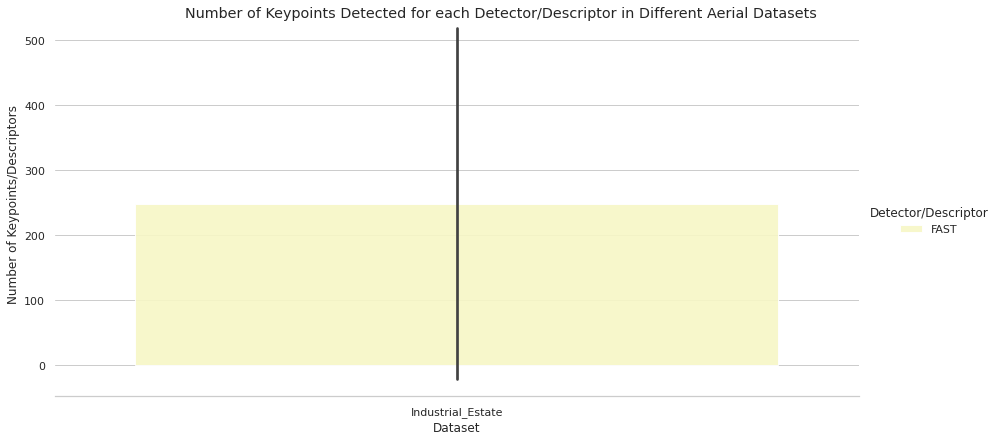

In [ ]:
import seaborn as sns
sns.set_theme(style='whitegrid')


# Draw a nested barplot by species and sex
g = sns.catplot(
    data=df_numkey_15, kind="bar",
    x="Dataset", y="Number of Keypoints", hue="Detector/Descriptor",
    ci="sd", palette="Spectral", alpha=.9, height=6, aspect=2
)
g.despine(left=True)
g.set_axis_labels("Dataset", "Number of Keypoints/Descriptors")
g.legend.set_title("Detector/Descriptor")
g.fig.suptitle("Number of Keypoints Detected for each Detector/Descriptor in Different Aerial Datasets")

In [ ]:
df_numkey_15.to_csv(f'drive/MyDrive/Fast_{Dataset}.csv')

In [ ]:

d = {'Dataset': [f'{Dataset}']*(num_detectors*len_files), 'Number of Keypoints':num_kps_agast+ num_kps_akaze + num_kps_brisk + num_kps_daisy + num_kps_fast + num_kps_freak + num_kps_gftt + num_kps_kaze + num_kps_mser + num_kps_orb + num_kps_rootsift + num_kps_sift + num_kps_briefstar + num_kps_superpoint+ num_kps_surf, 'Detector/Descriptor':['AGAST+SIFT']*len_files + ['AKAZE']*len_files + ['BRISK']*len_files + ['DAISY+SIFT']*len_files + ['FAST+SIFT']*len_files + ['BRISK+FREAK']*len_files + ['GFTT+SIFT']*len_files + ['KAZE']*len_files + ['MSER+SIFT']*len_files + ['ORB']*len_files +['RootSIFT']*len_files +['SIFT']*len_files + ['STAR+BRIEF']*len_files +  ['SuperPoint']*len_files + ['SURF']*len_files  }
df_numkey_15 = pd.DataFrame(data=d)
df_numkey_15['Number of Keypoints'] = df_numkey_15['Number of Keypoints']/(len_files)

In [ ]:
len(left_files_path)

57

In [ ]:
len(right_files_path[1:])

56

In [ ]:
len_files = len(left_files_path) + len(right_files_path[1:])
num_detectors = 15

In [ ]:
d = {'Dataset': [f'{Dataset}']*(num_detectors*len_files), 'Number of Keypoints': num_kps_fast + num_kps_daisy, 'Detector/Descriptor':['FAST+SIFT']*len_files + ['DAISY + SIFT'] }



In [ ]:
df = pd.DataFrame.from_dict(d, orient='index')
df = df.transpose()

In [ ]:
df_numkey_15 = df
df_numkey_15['Number of Keypoints'] = df_numkey_15['Number of Keypoints']/(len_files)

Text(0.5, 0.98, 'Number of Keypoints Detected for each Detector/Descriptor in Different Aerial Datasets')

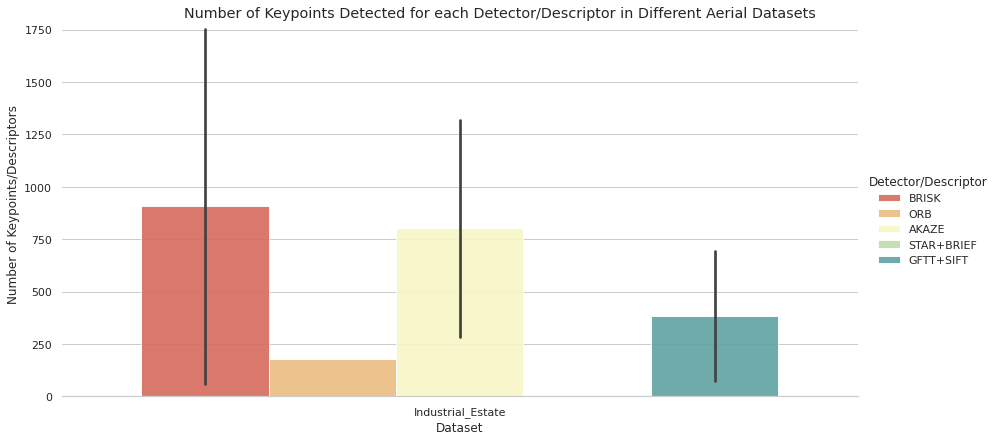

In [ ]:
import seaborn as sns
sns.set_theme(style='whitegrid')


# Draw a nested barplot by species and sex
g = sns.catplot(
    data=df_numkey_15, kind="bar",
    x="Dataset", y="Number of Keypoints", hue="Detector/Descriptor",
    ci="sd", palette="Spectral", alpha=.9, height=6, aspect=2
)
g.despine(left=True)
g.set_axis_labels("Dataset", "Number of Keypoints/Descriptors")
g.legend.set_title("Detector/Descriptor")
g.fig.suptitle("Number of Keypoints Detected for each Detector/Descriptor in Different Aerial Datasets")

In [ ]:
df_numkey_15.to_csv(f'drive/MyDrive/RootSift_{Dataset}.csv')

In [ ]:
len_files = len(left_files_path) + len(right_files_path[1:])
num_detectors = 15

In [ ]:
d = {'Dataset': [f'{Dataset}']*(num_detectors*len_files), 'Number of Keypoints': num_kps_rootsift, 'Detector/Descriptor': ['ROOTSIFT']*len_files }


In [ ]:
df = pd.DataFrame.from_dict(d, orient='index')
df = df.transpose()
df_numkey_15 = df
df_numkey_15['Number of Keypoints'] = df_numkey_15['Number of Keypoints']/(len_files)

Text(0.5, 0.98, 'Number of Keypoints Detected for each Detector/Descriptor in Different Aerial Datasets')

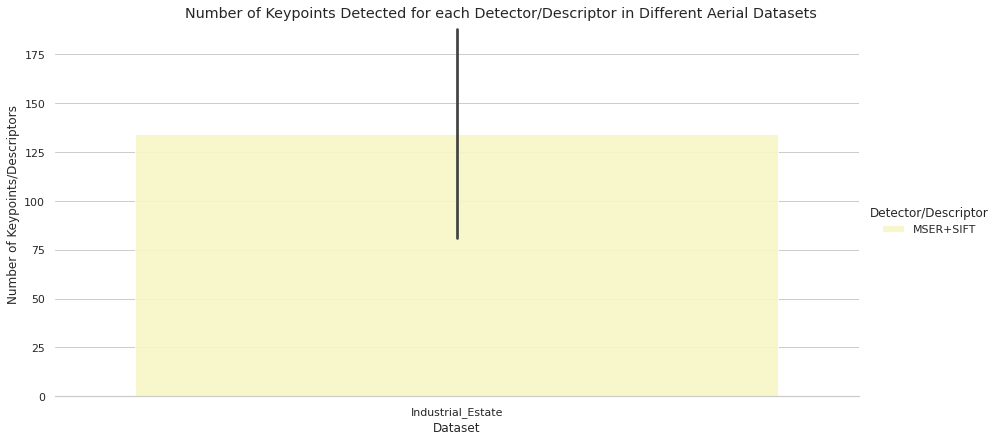

In [ ]:
import seaborn as sns
sns.set_theme(style='whitegrid')


# Draw a nested barplot by species and sex
g = sns.catplot(
    data=df_numkey_15, kind="bar",
    x="Dataset", y="Number of Keypoints", hue="Detector/Descriptor",
    ci="sd", palette="Spectral", alpha=.9, height=6, aspect=2
)
g.despine(left=True)
g.set_axis_labels("Dataset", "Number of Keypoints/Descriptors")
g.legend.set_title("Detector/Descriptor")
g.fig.suptitle("Number of Keypoints Detected for each Detector/Descriptor in Different Aerial Datasets")

In [ ]:
len_files = len(left_files_path) + len(right_files_path[1:])
num_detectors = 15

In [ ]:
d = {'Dataset': [f'{Dataset}']*(num_detectors*len_files), 'Number of Keypoints': num_kps_freak+num_kps_agast, 'Detector/Descriptor': ['BRISK+FREAK']*len_files+['AGAST+SIFT']*len_files  }


In [ ]:
df = pd.DataFrame.from_dict(d, orient='index')
df = df.transpose()

In [ ]:
df_numkey_15 = df
df_numkey_15['Number of Keypoints'] = df_numkey_15['Number of Keypoints']/(len_files)

Text(0.5, 0.98, 'Number of Keypoints Detected for each Detector/Descriptor in Different Aerial Datasets')

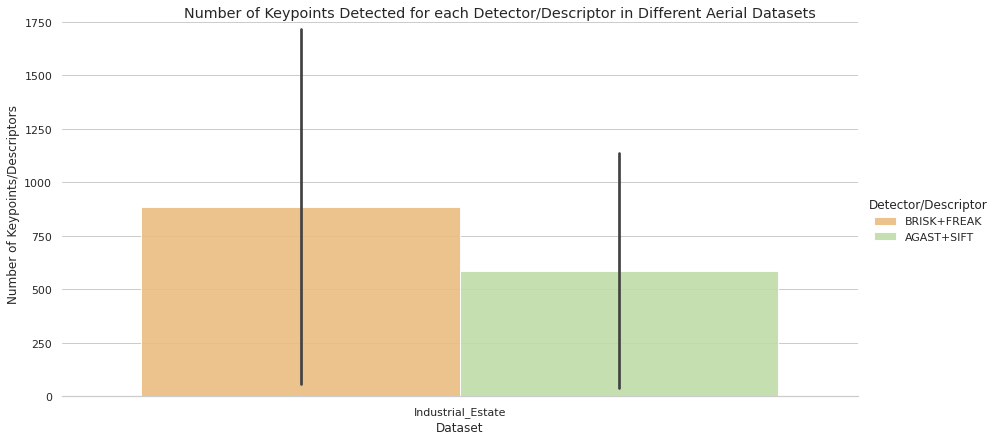

In [ ]:
import seaborn as sns
sns.set_theme(style='whitegrid')


# Draw a nested barplot by species and sex
g = sns.catplot(
    data=df_numkey_15, kind="bar",
    x="Dataset", y="Number of Keypoints", hue="Detector/Descriptor",
    ci="sd", palette="Spectral", alpha=.9, height=6, aspect=2
)
g.despine(left=True)
g.set_axis_labels("Dataset", "Number of Keypoints/Descriptors")
g.legend.set_title("Detector/Descriptor")
g.fig.suptitle("Number of Keypoints Detected for each Detector/Descriptor in Different Aerial Datasets")

In [ ]:
df_numkey_15.to_csv(f'drive/MyDrive/Num_Kypoints_15(2)_{Dataset}.csv')

In [ ]:
#d = {'Dataset': ['University Campus']*(3*len_files), 'Number of Keypoints': num_kps_rootsift + num_kps_superpoint + num_kps_surf, 'Detector/Descriptor':['ROOTSIFT']*101 + ['SuperPoint']*101 + ['SURF']*101  }
#df = pd.DataFrame(data=d)

In [ ]:
#df_13 = pd.read_csv('drive/MyDrive/Num_Key_13_{Dataset}.csv')
#frames = [df_13, df]
#df_15 = pd.concat(frames)

In [ ]:
#df_15.to_csv('drive/MyDrive/Num_Key_15_{Dataset}.csv')

In [ ]:
g.savefig(f'drive/MyDrive/Num_Kypoints_15(2)_{Dataset}.png')

In [ ]:
print(len(num_matches_akaze))

112


**Didn't get good matches with MSER, so initialize a dummy variable for matches:**

In [ ]:
num_matches_mser = [0]*len(num_matches_agast)

### **Total Number of Matches Detected for each Detector+Descriptor**

In [54]:
len_files = len(left_files_path) + len(right_files_path[1:])
num_detectors = 15

In [ ]:
d = {'Dataset': [f'{Dataset}']*(num_detectors*len_files), 'Number of Keypoints': num_kps_surf +, 'Detector/Descriptor':  ['SURF']*len_files }


In [ ]:
df = pd.DataFrame.from_dict(d, orient='index')
df = df.transpose()
df_numkey_15 = df
df_numkey_15['Number of Keypoints'] = df_numkey_15['Number of Keypoints']/(len_files)

In [ ]:
df_numkey_15.to_csv(f'drive/MyDrive/Num_Kypoints_2sift(0.75)_{Dataset}.csv')

In [55]:
du = {'Dataset': [f'{Dataset}']*(num_detectors*(len_files-1)), 'Number of Total Matches': num_kps_agast + num_kps_freak, 'Detector/Descriptor': ['AGAST+SIFT']*(len_files-1) + ['BRISK+FREAK']*(len_files-1) }

In [56]:
df2 = pd.DataFrame.from_dict(du, orient='index')
df2 = df2.transpose()

In [57]:
df_match_25 = df2
df_match_15 = df_match_25[:224]


In [58]:
 
 
df_match_15['Number of Total Matches'] = df_match_15['Number of Total Matches']/(len_files-1)
 
df_match_15['Number of Good Matches'] = num_good_matches_agast + num_good_matches_freak
 
df_match_15['Number of Good Matches'] = df_match_15['Number of Good Matches']/(len_files-1)
## df_match_15['Number of Good Matches'] = df_match_15['Number of Total Matches']/(len_files-1)
 
df_match_15['Recall Rate of Matches'] = df_match_15['Number of Good Matches']/df_match_15['Number of Total Matches']
df_match_15['1 - Precision Rate of Matches'] = (df_match_15['Number of Total Matches'] - df_match_15['Number of Good Matches'])/df_match_15['Number of Total Matches']
 
df_match_15['F-Score'] = (2* (1 - df_match_15['1 - Precision Rate of Matches']) * df_match_15['Recall Rate of Matches'])/((1 - df_match_15['1 - Precision Rate of Matches']) + df_match_15['Recall Rate of Matches'])
 
 
df_match_15.to_csv(f'drive/MyDrive/All_metrics_agastfreak(0.75)_{Dataset}.csv')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inst

In [ ]:
#df_match_15['Number of Total Matches'] =  num_matches_agast + num_matches_akaze + num_matches_brisk + num_matches_daisy + num_matches_fast + num_matches_freak + num_matches_gftt + num_matches_kaze + num_matches_mser + num_matches_orb + num_matches_rootsift + num_matches_sift + num_matches_briefstar + num_matches_superpoint+ num_matches_surf+ num_matches_surfsift
d = {'Dataset': [f'{Dataset}']*(num_detectors*(len_files-1)), 'Number of Total Matches': num_matches_agast + num_matches_akaze + num_matches_brisk + num_matches_daisy + num_matches_fast + num_matches_freak + num_matches_gftt + num_matches_kaze + num_matches_mser + num_matches_orb + num_matches_rootsift + num_matches_sift + num_matches_briefstar + num_matches_superpoint+ num_matches_surf, 'Detector/Descriptor':['AGAST+SIFT']*(len_files-1) + ['AKAZE']*(len_files-1) + ['BRISK']*(len_files-1) + ['DAISY+SIFT']*(len_files-1) + ['FAST+SIFT']*(len_files-1) + ['BRISK+FREAK']*(len_files-1) + ['GFTT+SIFT']*(len_files-1) + ['KAZE']*(len_files-1) + ['MSER+SIFT']*(len_files-1) + ['ORB']*(len_files-1) +['RootSIFT']*(len_files-1) +['SIFT']*(len_files-1) + ['STAR+BRIEF']*(len_files-1) +  ['SuperPoint']*(len_files-1) + ['SURF']*(len_files-1) }
df_match_15 = pd.DataFrame(data=d)
df_match_15['Number of Total Matches'] = df_match_15['Number of Total Matches']/(len_files-1)

In [ ]:
 import seaborn as sns
sns.set_theme(style='whitegrid')


# Draw a nested barplot by species and sex
g = sns.catplot(
    data=df_match_15e, kind="bar",
    x="Dataset", y="Number of Total Matches", hue="Detector/Descriptor",
    ci="sd", palette="Spectral", alpha=.9, height=10, aspect=0.5
)
g.despine(left=True)
g.set_axis_labels("Dataset ", "Total Number of Matches b/w Consecutive/Overlapping Images")
g.legend.set_title("Detector/Descriptor")
g.fig.suptitle("Total Number of Matches Detected for each Detector/Descriptor in Different Aerial Datasets")

In [ ]:
g.savefig(f'drive/MyDrive/Num_Matches_15_{Dataset}.png')

In [ ]:
#df_match_15.to_csv('drive/MyDrive/Num_Matches_15_{Dataset}.csv')

In [ ]:
print(min(num_good_matches_agast))

### **Total Number of Good/Robust Matches (NN+Lowe+RANSAC) Detected for each Detector+Descriptor**

**Didn't get good matches with MSER, so initialize a dummy variable for good matches:**

In [ ]:
num_good_matches_mser = [0]*len(num_good_matches_agast)

In [ ]:
df_match_15['Number of Good Matches'] = num_good_matches_agast + num_good_matches_akaze + num_good_matches_brisk + num_good_matches_daisy + num_good_matches_fast + num_good_matches_freak + num_good_matches_gftt + num_good_matches_kaze + num_good_matches_mser + num_good_matches_orb + num_good_matches_rootsift + num_good_matches_sift + num_good_matches_briefstar + num_good_matches_superpoint+ num_good_matches_surf
df_match_15['Number of Good Matches'] = df_match_15['Number of Good Matches']/(len_files-1)

In [ ]:
import seaborn as sns
sns.set_theme(style='whitegrid')


# Draw a nested barplot by species and sex
g = sns.catplot(
    data=df_match_15, kind="bar",
    x="Dataset", y="Number of Good Matches", hue="Detector/Descriptor",
    ci="sd", palette="Spectral", alpha=.9, height=10, aspect=0.5
)
g.despine(left=True)
g.set_axis_labels("Dataset", "Number of Good Matches b/w Consecutive/Overlapping Images")
g.legend.set_title("Detector/Descriptor")
g.fig.suptitle("Number of Good Matches (Lowe + RANSAC) Detected for each Detector/Descriptor in Different Aerial Datasets")

In [ ]:
g.savefig(f'drive/MyDrive/Num_Good_Matches_15_{Dataset}.png')

In [ ]:
#df_match_15.to_csv('drive/MyDrive/Num_Good_Matches_15_{Dataset}.csv')

### **Recall Rate for each Detector+Descriptor**

In [ ]:
df_match_15['Recall Rate of Matches'] = df_match_15['Number of Good Matches']/df_match_15['Number of Total Matches']

In [ ]:
import seaborn as sns
sns.set_theme(style='whitegrid')


g = sns.catplot(
    data=df_match_15, kind="bar",
    x="Dataset", y="Recall Rate of Matches", hue="Detector/Descriptor",
    ci="sd", palette="Spectral", alpha=.9, height=10, aspect=0.5
)
g.despine(left=True)
g.set_axis_labels("Dataset", "Precision of Matches")
g.legend.set_title("Detector/Descriptor")
g.fig.suptitle("Recall Rate of Matches Detected (Good/Total) for each Detector/Descriptor in Different Aerial Datasets (Higher the Better)")

In [ ]:
g.savefig(f'drive/MyDrive/Recall_Rate_Matches_15_{Dataset}.png')

### **1-Precision Rate for each Detector+Descriptor**

In [ ]:
df_match_15['1 - Precision Rate of Matches'] = (df_match_15['Number of Total Matches'] - df_match_15['Number of Good Matches'])/df_match_15['Number of Total Matches']

In [ ]:
import seaborn as sns
sns.set_theme(style='whitegrid')


# Draw a nested barplot by species and sex
g = sns.catplot(
    data=df_match_15, kind="bar",
    x="Dataset", y="1 - Precision Rate of Matches", hue="Detector/Descriptor",
    ci="sd", palette="Spectral", alpha=.9, height=10, aspect=0.5
)
g.despine(left=True)
g.set_axis_labels("Dataset (100 Images)", "1 - Precision Rate of Matches")
g.legend.set_title("Detector/Descriptor")
g.fig.suptitle("1 - Precision rate of Matches Detected (False/Total Matches) for each Detector/Descriptor in Different Aerial Datasets (Lower the Better)")

In [ ]:
g.savefig(f'drive/MyDrive/One_minus_Precision_Rate_Matches_15_{Dataset}.png')

### **F-Score for each Detector+Descriptor**


In [ ]:
df_match_15['F-Score'] = (2* (1 - df_match_15['1 - Precision Rate of Matches']) * df_match_15['Recall Rate of Matches'])/((1 - df_match_15['1 - Precision Rate of Matches']) + df_match_15['Recall Rate of Matches'])

In [ ]:
import seaborn as sns
sns.set_theme(style='whitegrid')


# Draw a nested barplot by species and sex
g = sns.catplot(
    data=df_match_15, kind="bar",
    x="Dataset", y="F-Score", hue="Detector/Descriptor",
    ci="sd", palette="Spectral", alpha=.9, height=10, aspect=0.5
)
g.despine(left=True)
g.set_axis_labels("Dataset", "F-Score")
g.legend.set_title("Detector/Descriptor")
g.fig.suptitle("F-Score of Matches Detected (2*P*R/P+R) for each Detector/Descriptor in Different Aerial Datasets (Higher the Better)")

In [ ]:
g.savefig(f'drive/MyDrive/F_Score_Rate_Matches_15_{Dataset}.png')

In [ ]:
df_match_15.to_csv(f'drive/MyDrive/All_metrics_15_{Dataset}.csv')

### **Time for each Detector+Descriptor**

In [ ]:
len_files = len(left_files_path) + len(right_files_path[1:])
num_detectors = 15

In [ ]:
de = {'Dataset': [f'{Dataset}']*(num_detectors), 'Time': [time_all[0]] , 'Detector/Descriptor':['SURF']*(1)} 


In [ ]:
df_time  = pd.DataFrame.from_dict(de, orient='index')
df_time = df_time.transpose() 

In [ ]:
import seaborn as sns
sns.set_theme(style='whitegrid')


# Draw a nested barplot by species and sex
g = sns.catplot(
    data=df_time, kind="bar",
    x="Dataset", y="Time", hue="Detector/Descriptor",
    ci="sd", palette="Spectral", alpha=.9, height=10, aspect=0.5
)
g.despine(left=True)
g.set_axis_labels("Dataset", "Time (in sec)")
g.legend.set_title("Detector/Descriptor")
g.fig.suptitle("Time taken during Feature Extraction by each Detector/Descriptor in Different Aerial Datasets (Lower the Better)")

TypeError: ignored

In [ ]:
g.savefig(f'drive/MyDrive/Time_15_{Dataset}.png')

In [ ]:
df_time.to_csv(f'drive/MyDrive/Time_15surf(0.75)_{Dataset}.csv')